In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\Donat\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Variables

In [4]:
num_topics = 5
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## Load data

In [5]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus

corpus = load_data()

## Preprocessing

In [6]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0it [00:00, ?it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:02, 462.58it/s]


### TD-IDF

In [7]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus =  vectorizer.fit_transform(corpus["token"])

# Clustering

In [8]:
tdidf_ap_clustering = AffinityPropagation(random_state=0)
tdidf_ap_clustering.fit(tfidf_corpus.toarray())

AffinityPropagation(random_state=0)

In [9]:
pickle.dump(tdidf_ap_clustering, open('ap_data/tdidf_ap_clustering', 'wb'))

In [21]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, corpus):
    labels = model.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if (n_clusters_ == 0):
        print('No clusters found')
        return
    
    clusters = []
    print("Top terms per cluster:")
    for i in range(n_clusters_):
        print("Cluster %d:" % i)
        vectorizer_terms = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
        tfidf_corpus_terms = vectorizer_terms.fit_transform(corpus.iloc[np.where(model.labels_ == i)]["token"])
        top_words = get_top_words(vectorizer_terms, tfidf_corpus_terms)
        print(top_words)
        clusters.append(top_words)
        print("\n")
        
    return clusters

clusters = print_and_get_clusters(tdidf_ap_clustering, corpus)

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('domain', 'distribution', 'algorithm', 'target', 'adaptation', 'discrepancy', 'source', 'feature', 'sdas', 'data')


Cluster 73:
('signal', 'noise', 'latent', 'regression', 'model', 'accumulation', 'observation', 'memory', 'factor', 'data')


Cluster 74:
('dantzig', 'selector', 'sparse', 'factor', 'method', 'recovery', 'signal', 'approach', 'effect', 'exhibiting')


Cluster 75:
('control', 'learning', 'exploration', 'reinforcement', 'rl', 'problem', 'function', 'process', 'value', 'dynamic')


Cluster 76:
('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 77:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 78:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')


Cluster 79:
('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluste

('game', 'graph', 'lmrl2', 'learning', 'stochastic', 'hypernode', 'algorithm', 'gradient', 'ligs', 'problem')


Cluster 140:
('sample', 'problem', 'distribution', 'bandit', 'arm', 'bound', 'setting', 'model', 'approach', 'player')


Cluster 141:
('matrix', 'completion', 'bound', 'algorithm', 'rank', 'norm', 'approach', 'low', 'error', 'structure')


Cluster 142:
('hmc', 'subsampling', 'data', 'method', 'step', 'metropolized', 'estimator', 'parameter', 'algorithm', 'carlo')


Cluster 143:
('pattern', 'attribute', 'latent', 'model', 'feature', 'temporal', 'bayes', 'naive', 'weighting', 'data')


Cluster 144:
('learning', 'concept', 'private', 'sample', 'privacy', 'time', 'algorithm', 'class', 'complexity', 'method')


Cluster 145:
('risk', 'score', 'method', 'algorithm', 'learning', 'prediction', 'breast', 'structed', 'task', 'structured')


Cluster 146:
('uncertainty', 'market', 'prediction', 'set', 'approach', 'function', 'statistical', 'artificial', 'quantifying', 'loss')


Cluster 14

# Visualization

In [18]:
def visualize_clustering_result(model, corpus):
    X = corpus.toarray()
    cluster_centers_indices = model.cluster_centers_indices_
    labels = model.labels_

    n_clusters_ = len(cluster_centers_indices)

    print('Estimated number of clusters: %d' % n_clusters_)

    plt.close('all')
    plt.figure(1)
    plt.clf()

    colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = X[cluster_centers_indices[k]]
        plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        for x in X[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

Estimated number of clusters: 179


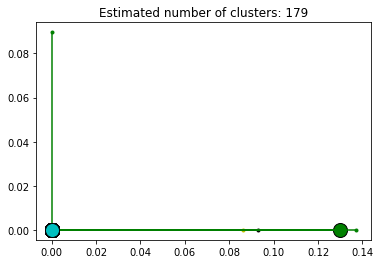

In [19]:
visualize_clustering_result(tdidf_ap_clustering, tfidf_corpus)

# Try different arguments for `AP`

damping: 0.5, max_iter: 200, convergence: 8, preference: -50
Estimated number of clusters: 1261


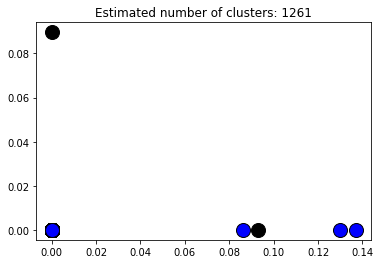

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('relational', 'exploration', 'model', 'context', 'count', 'domain', 'learning', 'problem', 'reinforcement', 'state')


Cluster 113:
('manifold', 'regularization', 'supervised', 'example', 'learning', 'result', 'semi', 'algorithm', 'analysis', 'labeled')


Cluster 114:
('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'als

('manifold', 'manopt', 'matlab', 'optimization', 'toolbox')


Cluster 228:
('time', 'process', 'change', 'covariance', 'interval', 'locally', 'mean', 'multivariate', 'smoothness', 'varying')


Cluster 229:
('convex', 'complexity', 'problem', 'algorithm', 'descent', 'dual', 'method', 'optimization', 'strongly', 'applied')


Cluster 230:
('model', 'sparse', 'markov', 'covariance', 'independence', 'matrix', 'data', 'dimensional', 'gaussian', 'high')


Cluster 231:
('step', 'algorithm', 'hmc', 'method', 'nut', 'carlo', 'monte', 'parameter', 'random', 'sampler')


Cluster 232:
('jackknife', 'ij', 'replicates', 'bootstrap', 'estimate', 'study', 'bagged', 'bagging', 'estimator', 'forest')


Cluster 233:
('ranking', 'regret', 'bipartite', 'loss', 'bound', 'proper', 'term', 'pairwise', 'surrogate', '2011')


Cluster 234:
('linear', 'model', 'rate', 'regression', 'achieve', 'aggregation', 'best', 'predictor', 'sparse', 'combination')


Cluster 235:
('structure', 'data', 'estimating', 'graphical'

('oracle', 'inequality', 'aggregation', 'bound', 'convex', 'improvement', 'obtain', 'previous', 'regression', 'result')


Cluster 346:
('random', 'graph', 'process', 'deviation', 'property', 'behavior', 'bound', 'dimension', 'exceptional', 'lower')


Cluster 347:
('information', 'anticausal', 'causal', 'direction', 'supervised', 'cause', 'effect', 'function', 'independence', 'learning')


Cluster 348:
('clustering', 'measure', 'axiom', 'elementary', 'hierarchical', 'notion', 'set', 'user', 'without', 'additivity')


Cluster 349:
('graph', 'bound', 'labelings', 'online', 'problem', 'algorithm', 'labeling', 'latent', 'predicting', 'prediction')


Cluster 350:
('example', 'information', 'student', 'learning', 'privileged', 'teacher', 'describes', 'intelligent', 'knowledge', 'paper')


Cluster 351:
('alexey', 'bibliography', 'chervonenkis', 'comment', 'introductory')


Cluster 352:
('alexey', 'bibliography', 'chervonenkis')


Cluster 353:
('system', 'learning', 'machine', 'common', 'comput

('subspace', 'learning', 'information', 'instance', 'partial', 'vector', 'algorithm', 'analyze', 'attribute', 'complexity')


Cluster 453:
('lasso', 'poisson', 'group', 'procedure', 'regression', 'analysis', 'approach', 'data', 'framework', 'inequality')


Cluster 454:
('causal', 'approach', 'effect', 'inference', 'observational', 'path', 'conditional', 'independency', 'one', 'study')


Cluster 455:
('order', 'partial', 'method', 'sampling', 'ai', 'algorithm', 'based', 'dag', 'bayesian', 'carlo')


Cluster 456:
('model', 'comparison', 'bound', 'error', 'pairwise', 'cardinal', 'class', 'compared', 'data', 'graph')


Cluster 457:
('rank', 'matrix', 'low', 'based', 'binary', 'bound', 'consider', 'constraint', 'estimation', 'measurement')


Cluster 458:
('gradient', 'local', 'stochastic', 'averaging', 'convergence', 'dsa', 'decentralized', 'problem', 'algorithm', 'alternative')


Cluster 459:
('collaborative', 'data', 'graph', 'statistical', 'unit', 'distributed', 'estimate', 'inference', 

('domain', 'transfer', 'adaptation', 'data', 'feature', 'model', 'classifier', 'flda', 'level', 'loss')


Cluster 562:
('online', 'optimal', 'pca', 'regret')


Cluster 563:
('local', 'gp', 'region', 'regression', 'data', 'boundary', 'prediction', 'two', 'set', 'gaussian')


Cluster 564:
('bandicoot', 'mobile', 'phone', 'extract', 'feature', 'metadata', 'python', 'toolbox', '1442', 'analyze')


Cluster 565:
('output', 'kernel', 'regression', 'input', 'structured', 'supervised', 'model', 'problem', 'space', 'approach')


Cluster 566:
('algorithm', 'er', 'matrix', 'spielman', 'spud', 'wang', 'wright', 'based', 'column', 'complexity')


Cluster 567:
('network', 'performance', 'echo', 'linear', 'mse', 'neural', 'setting', 'state', 'aforementioned', 'article')


Cluster 568:
('vertex', 'nomination', 'ml', 'scheme', 'based', 'graph', 'likelihood', 'prove', 'approach', 'bayes')


Cluster 569:
('kernel', 'distribution', 'characteristic', 'divisible', 'infinitely', 'mean', 'ii', 'probability', '

('estimator', 'density', 'divergence', 'based', 'dimensional', 'proposed', 'show', 'convergence', 'element', 'estimation')


Cluster 672:
('ordinal', 'data', 'distance', 'approach', 'problem', 'algorithm', 'depth', 'drawback', 'embedding', 'function')


Cluster 673:
('label', 'type', 'network', 'inference', 'al', 'consider', 'edgeexplain', 'et', 'graph', 'ha')


Cluster 674:
('stage', 'community', 'optimal', 'proportion', 'achieves', 'block', 'detection', 'model', 'procedure', 'statistical')


Cluster 675:
('distribution', 'error', 'count', 'general', 'graph', 'independent', 'network', 'result', 'subgraph', 'case')


Cluster 676:
('lda', 'sample', 'cgs', 'collapsed', 'parameter', 'approach', 'estimator', 'gibbs', 'computational', 'condition')


Cluster 677:
('tensor', 'completability', 'cp', 'rank', 'sampling', 'completion', 'entry', 'finite', 'number', 'polynomial')


Cluster 678:
('learning', 'approach', 'example', 'rule', 'class', 'data', 'description', 'exception', 'expression', 'g

('method', 'complexity', 'type', 'minimization', 'block', 'bound', 'cbcd', 'convex', 'strongly', 'coordinate')


Cluster 781:
('optimization', 'hyperparameter', 'learning', 'problem', 'uralg', 'algorithm', 'approach', 'bandit', 'based', 'bayesian')


Cluster 782:
('submatrix', 'algorithm', 'problem', 'localization', 'mean', 'message', 'noise', 'passing', 'community', 'elevated')


Cluster 783:
('bit', 'network', 'neural', 'quantized', 'accuracy', 'activation', 'qnns', 'weight', 'gradient', 'operation')


Cluster 784:
('community', 'network', 'method', 'weighted', 'detection', 'node', 'null', 'algorithm', 'background', 'ccme')


Cluster 785:
('data', 'method', 'persistence', 'diagram', 'kernel', 'tda', 'topological', 'weight', 'accurate', 'advantage')


Cluster 786:
('pycobra', 'learning', 'python', 'ensemble', 'visualisation', 'algorithm', 'available', 'documentation', 'http', 'library')


Cluster 787:
('kernel', 'kelp', 'java', 'algorithm', 'learning', 'based', 'easy', 'enables', 'ext

('function', 'kernel', 'memory', 'online', 'amount', 'based', 'classification', 'data', 'learning', 'method')


Cluster 898:
('algorithm', 'annealing', 'convergence', 'evaluation', 'global', 'noisy', 'problem', 'rate', 'simulated', 'accuracy')


Cluster 899:
('convex', 'non', 'approach', 'descent', 'low', 'projected', 'algorithm', 'dimensional', 'gradient', 'rank')


Cluster 900:
('label', 'multi', 'library', 'method', 'python', 'scikit', 'classification', 'division', 'implementation', 'multilearn')


Cluster 901:
('algorithm', 'risk', 'empirical', 'problem', 'computationally', 'design', 'generalized', 'large', 'linear', 'minimizer')


Cluster 902:
('algorithm', 'variable', 'selection', 'heuristic', 'proposed', 'backward', 'family', 'feature', 'forward', 'lasso')


Cluster 903:
('regret', 'policy', 'model', 'choice', 'pricing', 'customer', 'distribution', 'feature', 'firm', 'parameter')


Cluster 904:
('gl', 'method', 'matrix', 'consistent', 'covariance', 'sample', 'thresholded', 'data

('logical', 'prediction', 'deep', 'drm', 'explanation', 'local', 'drms', 'feature', 'model', 'provided')


Cluster 1016:
('dirichlet', 'topic', 'model', 'distribution', 'smoothness', 'vector', 'sparsity', 'variational', 'autoencoder', 'competitive')


Cluster 1017:
('estimator', 'subsampling', 'also', 'asymptotic', 'based', 'estimation', 'optimal', 'poisson', 'probability', 'data')


Cluster 1018:
('spurious', 'valley', 'model', 'dimension', 'exist', 'intrinsic', 'network', 'neural', 'non', 'absence')


Cluster 1019:
('cubic', 'regularization', 'svrc', 'method', 'stochastic', 'algorithm', 'hessian', 'lite', 'local', 'minimum')


Cluster 1020:
('constraint', 'process', 'linear', 'function', 'gaussian', 'set', 'approach', 'gp', 'operator', 'posterior')


Cluster 1021:
('loss', 'boosting', 'multiclass', 'algorithm', 'mcboost', 'margin', 'codewords', 'function', 'procedure', 'descent')


Cluster 1022:
('approximation', 'entropy', 'method', 'moment', 'programming', 'scheme', 'action', 'appr

('condition', 'error', 'identifiability', 'anms', 'variance', 'algorithm', 'identifiable', 'new', 'additive', 'doe')


Cluster 1135:
('communication', 'gadmm', 'worker', 'distributed', 'efficient', 'problem', 'framework', 'learning', 'algorithm', 'alternating')


Cluster 1136:
('player', 'arm', 'assume', 'bandit', 'loss', 'multi', 'work', '2016', 'action', 'adversarial')


Cluster 1137:
('eda', 'model', 'dae', 'algorithm', 'overfitting', 'problem', 'complex', 'distribution', 'optimization', 'autoencoders')


Cluster 1138:
('data', 'graphical', 'model', 'approach', 'assumption', 'based', 'bayesian', 'distribution', 'estimation', 'gaussian')


Cluster 1139:
('loss', 'sequence', 'memoryless', 'attribute', 'convex', 'function', 'result', 'stochastic', 'bregman', 'differentiable')


Cluster 1140:
('method', 'bo', 'dragonfly', 'optimisation', 'bayesian', 'function', 'handling', 'applied', 'available', 'domain')


Cluster 1141:
('graphical', 'model', 'change', 'network', 'high', 'work', 'algo

('norm', 'rate', 'sobolev', 'space', 'stronger', 'used', 'algorithm', 'bound', 'case', 'combination')


Cluster 1253:
('model', 'averaging', 'cv', 'prediction', 'high', 'method', 'cox', 'dimensional', 'process', 'proposed')


Cluster 1254:
('data', 'kernel', 'learning', 'model', 'adaptive', 'framework', 'based', 'matrix', 'non', 'parametric')


Cluster 1255:
('learning', 'disentangled', 'data', 'representation', 'unsupervised', 'disentanglement', 'evaluation', 'model', 'bias', 'covering')


Cluster 1256:
('distribution', 'image', 'noise', 'random', 'robustness', 'smoothing', 'case', 'classifier', 'dimensional', 'ha')


Cluster 1257:
('scikit', 'survival', 'event', 'time', 'analysis', 'instruction', 'learn', 'library', 'machine', 'model')


Cluster 1258:
('clustering', 'tensor', 'convex', 'data', 'analysis', 'cluster', 'co', 'coco', 'estimator', 'business')


Cluster 1259:
('graph', 'backbone', 'clof', 'forest', 'node', 'problem', 'representation', 'core', 'data', 'inferring')


Cluster

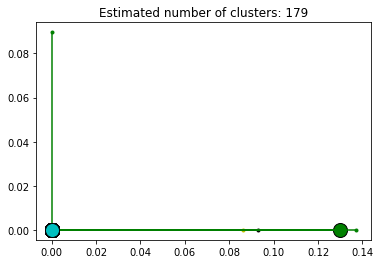

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('dantzig', 'selector', 'sparse', 'factor', 'method', 'recovery', 'signal', 'approach', 'effect', 'exhibiting')


Cluster 75:
('control', 'learning', 'exploration', 'reinforcement', 'rl', 'problem', 'function', 'process', 'value', 'dynamic')


Cluster 76:
('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 77:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 78:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')


Cluster 79:
('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluster 80:
('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 81:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')



('state', 'reservoir', 'system', 'input', 'memory', 'space', 'time', 'fading', 'filter', 'feature')


Cluster 153:
('image', 'convolutional', 'invariance', 'network', 'information', 'representation', 'model', 'data', 'neural', 'patch')


Cluster 154:
('constraint', 'algorithm', 'problem', 'convex', 'time', 'optimization', 'regret', 'online', 'set', 'pesc')


Cluster 155:
('regression', 'modal', 'loss', 'learning', 'model', 'symbolic', 'correntropy', 'risk', 'dynamical', 'mmsr')


Cluster 156:
('factor', 'data', 'outcome', 'principal', 'marginal', 'analysis', 'model', 'curve', 'latent', 'correlated')


Cluster 157:
('data', 'bayesian', 'inference', 'approximation', 'ep', 'framework', 'model', 'imaging', 'correction', 'method')


Cluster 158:
('interaction', 'high', 'data', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'problem', 'matrix')


Cluster 159:
('graph', 'algorithm', 'problem', 'learning', 'random', 'model', 'data', 'spectral', 'framework', 'time')


Cluster 16

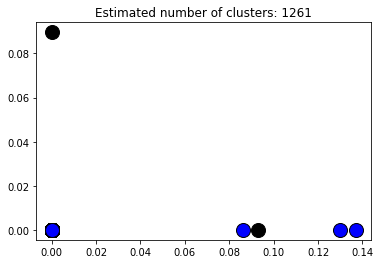

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'learning', 'lmm', 'based', 'data', 'edge', 'algorithm', 'criterion', 'network', 'skeleton')


Cluster 123:
('dimension', 'similarity', 'independent', 'algorithm', 'computation', 'data', 'jaccard', 'large', 'result', 'twitter')


Cluster 124:
('model',

('step', 'algorithm', 'hmc', 'method', 'nut', 'carlo', 'monte', 'parameter', 'random', 'sampler')


Cluster 232:
('jackknife', 'ij', 'replicates', 'bootstrap', 'estimate', 'study', 'bagged', 'bagging', 'estimator', 'forest')


Cluster 233:
('ranking', 'regret', 'bipartite', 'loss', 'bound', 'proper', 'term', 'pairwise', 'surrogate', '2011')


Cluster 234:
('linear', 'model', 'rate', 'regression', 'achieve', 'aggregation', 'best', 'predictor', 'sparse', 'combination')


Cluster 235:
('structure', 'data', 'estimating', 'graphical', 'model', 'node', 'graph', 'method', 'multi', 'network')


Cluster 236:
('graph', 'time', 'commute', 'hitting', 'distance', 'random', 'vertex', 'degree', 'expected', 'learning')


Cluster 237:
('bayesian', 'posterior', 'latent', 'inference', 'present', 'regbayes', 'regularization', 'distribution', 'infinite', 'prior')


Cluster 238:
('prior', 'model', 'parameter', 'approach', 'nn', 'scale', 'hierarchical', 'network', 'relevance', 'using')


Cluster 239:
('data'

('graph', 'bound', 'labelings', 'online', 'problem', 'algorithm', 'labeling', 'latent', 'predicting', 'prediction')


Cluster 350:
('example', 'information', 'student', 'learning', 'privileged', 'teacher', 'describes', 'intelligent', 'knowledge', 'paper')


Cluster 351:
('alexey', 'bibliography', 'chervonenkis', 'comment', 'introductory')


Cluster 352:
('alexey', 'bibliography', 'chervonenkis')


Cluster 353:
('system', 'learning', 'machine', 'common', 'computing', 'delay', 'demonstrate', 'descent', 'encoding', 'far')


Cluster 354:
('beamformers', 'meg', 'vector', 'beamforming', 'proposed', 'activity', 'case', 'covariance', 'data', 'dimension')


Cluster 355:
('data', 'set', 'different', 'combine', 'constraint', 'algorithm', 'causal', 'intervention', 'model', 'overlapping')


Cluster 356:
('entropy', 'function', 'cone', 'proper', 'rule', 'scoring', 'space', 'associated', 'density', 'derivative')


Cluster 357:
('bound', 'arm', 'mean', 'sample', 'distribution', 'problem', 'stratum', '

('sum', 'formulation', 'path', 'covariance', 'model', 'arbitrary', 'graphical', 'matrix', 'gaussian', 'topology')


Cluster 469:
('gesture', 'recognition', 'available', 'challenge', 'multimodal', 'art', 'camera', 'data', 'including', 'overview')


Cluster 470:
('td', 'method', 'parameter', 'step', 'update', 'difference', 'different', 'emphasizing', 'emphatic', 'function')


Cluster 471:
('auction', 'price', 'reserve', 'revenue', 'problem', 'algorithm', 'learning', 'second', 'analysis', 'cast')


Cluster 472:
('coordinate', 'data', 'big', 'descent', 'iteration', 'method', 'node', 'partition', 'problem', '3tb')


Cluster 473:
('empirical', 'learning', 'risk', 'statistic', 'incomplete', 'data', 'erm', 'functionals', 'minimization', 'optimization')


Cluster 474:
('learning', 'regularization', 'iterative', 'consider', 'convex', 'function', 'loss', 'new', 'achieved', 'algorithm')


Cluster 475:
('network', 'community', 'detection', 'internet', 'overlapping', 'scale', 'approach', 'inference'

('rank', 'spearman', 'list', 'multivariate', 'aggregation', 'correlation', 'missing', 'ranked', 'aggregating', 'best')


Cluster 588:
('link', 'model', 'network', 'nonparametric', 'prediction')


Cluster 589:
('spurious', 'fit', 'model', 'discovery', 'goodness', 'variable', 'algorithm', 'asymptotic', 'better', 'correlation')


Cluster 590:
('data', 'functional', 'markov', 'graphical', 'model', 'prior', 'random', 'hyper', 'multivariate', 'process')


Cluster 591:
('autoregressive', 'distribution', 'estimation', 'nade', 'neural', 'also', 'architecture', 'deep', 'model', 'performance')


Cluster 592:
('algorithm', 'consistency', 'density', 'erratum', 'estimation', 'gradient', 'line', 'mean', 'shift', 'paper')


Cluster 593:
('backtracking', 'data', 'dimensional', 'high', 'interaction', 'modelling')


Cluster 594:
('cross', 'fold', 'validation', 'least', 'variance', 'square', 'also', 'case', 'density', 'estimation')


Cluster 595:
('model', 'method', 'matrix', 'fast', 'nystrã', 'approximat


Cluster 706:
('label', 'class', 'classification', 'easy', 'hard', 'confusing', 'multiclass', 'learning', 'proposed', 'also')


Cluster 707:
('fisher', 'probability', 'consistency', 'prior', 'adjusted', 'algorithm', 'cde', 'class', 'consistent', 'count')


Cluster 708:
('bag', 'openxbow', 'toolkit', 'word', 'feature', 'input', 'acoustic', 'bow', 'classification', 'crossmodal')


Cluster 709:
('rank', 'given', 'tensor', 'completion', 'matrix', 'bound', 'data', 'low', 'view', 'probability')


Cluster 710:
('model', 'network', 'constraint', 'iterative', 'mip', 'order', 'problem', 'topological', 'algorithm', 'based')


Cluster 711:
('control', 'dynamic', 'learning', 'stability', 'controller', 'gaussian', 'gp', 'process', 'result', 'acting')


Cluster 712:
('algorithm', 'bound', 'gradient', 'regression', 'term', 'condition', 'consider', 'dimension', 'error', 'initial')


Cluster 713:
('classification', 'class', 'label', 'procedure', 'set', 'expected', 'number', 'risk', 'size', 'confidence')

('state', 'clinical', 'data', 'patient', 'time', 'hasmm', 'model', 'care', 'ehr', 'markov')


Cluster 826:
('bootstrap', 'give', 'regression', 'dimension', 'high', 'method', 'conservative', 'consider', 'estimate', 'grows')


Cluster 827:
('rsg', 'local', 'method', 'problem', 'bound', 'property', 'set', 'sg', 'complexity', 'condition')


Cluster 828:
('gp', 'approach', 'local', 'prediction', 'region', 'regression', 'response', 'boundary', 'datasets', 'input')


Cluster 829:
('posterior', 'data', 'subset', 'distribution', 'full', 'method', 'sample', 'sampling', 'across', 'approach')


Cluster 830:
('experience', 'replay', 'control', 'learning', 'method', 'reinforcement', 'replayed', 'buffer', 'choice', 'exploration')


Cluster 831:
('condition', 'sdar', 'error', 'iteration', 'solution', 'approach', 'high', 'algorithm', 'bound', 'certain')


Cluster 832:
('algorithm', 'change', 'point', 'graphical', 'model', 'large', 'also', 'data', 'gaussian', 'number')


Cluster 833:
('regression', 'app

('method', 'model', 'prediction', 'probabilistic', 'bayesian', 'correlation', 'ensemble', 'mixture', 'multivariate', 'normal')


Cluster 942:
('problem', 'arm', 'reward', 'stochastic', 'deceptive', 'spl', 'environment', 'feedback', 'location', 'optimal')


Cluster 943:
('hyperparameters', 'algorithm', 'tuning', 'default', 'learning', 'machine', 'tunability', 'based', 'measure', 'user')


Cluster 944:
('agent', 'swarm', 'mean', 'deep', 'embedding', 'representation', 'system', 'concatenation', 'decentralized', 'end')


Cluster 945:
('architecture', 'search', 'neural', 'progress', 'recognition', 'strategy', 'according', 'aspect', 'automated', 'categorize')


Cluster 946:
('matrix', 'time', 'algorithm', 'running', 'improved', 'optimal', 'problem', 'space', 'consider', 'direction')


Cluster 947:
('method', 'convergence', 'first', 'order', 'second', 'art', 'direction', 'empirical', 'global', 'linear')


Cluster 948:
('method', 'performance', 'kernel', 'recognition', 'speech', 'attain', 'fea

('dpps', 'sampling', 'dppy', 'point', 'probability', 'python', 'across', 'algorithm', 'approximate', 'challenge')


Cluster 1062:
('bayes', 'empirical', 'density', 'attractor', 'concentration', 'energy', 'framework', 'jump', 'kernel', 'learning')


Cluster 1063:
('network', 'node', 'horseshoe', 'model', 'neural', 'selection', 'bayesian', 'number', 'predictive', 'approach')


Cluster 1064:
('mala', 'algorithm', 'langevin', 'step', 'bound', 'concave', 'density', 'log', 'metropolis', 'mixing')


Cluster 1065:
('image', 'convolutional', 'architecture', 'augmentation', 'data', 'invariance', 'network', 'small', 'transformation', 'cnns')


Cluster 1066:
('constraint', 'algorithm', 'regret', 'violation', 'online', 'achieve', 'convex', 'long', 'optimization', 'paper')


Cluster 1067:
('regression', 'modal', 'risk', 'function', 'study', 'computational', 'estimation', 'excess', 'generalization', 'learning')


Cluster 1068:
('data', 'fake', 'model', 'piece', 'source', 'receiver', 'analysis', 'driv

('group', 'clustering', 'algorithm', 'overlap', 'estimated', 'structure', 'syncytial', 'used', 'approach', 'burst')


Cluster 1179:
('layer', 'tensor', 'activation', 'connected', 'fully', 'multilinear', 'regression', 'structure', 'contraction', 'convolutional')


Cluster 1180:
('automatic', 'model', 'sparsity', 'art', 'bisn', 'dimension', 'gradient', 'graphical', 'method', 'sparse')


Cluster 1181:
('algorithm', 'coordinate', 'submodular', 'approximation', 'function', 'continuous', 'maximization', 'monotone', 'problem', 'wise')


Cluster 1182:
('data', 'learning', 'distributed', 'unlabeled', 'dmee', 'node', 'rate', 'supervised', 'algorithm', 'error')


Cluster 1183:
('mahout', 'apache', 'dataflow', 'system', 'learning', 'machine', 'distributed', 'offering', 'scalable', 'several')


Cluster 1184:
('test', 'high', 'dimensional', 'alternative', 'parameter', 'adaptive', 'aispu', 'alzheimer', 'data', 'disease')


Cluster 1185:
('algorithm', 'system', 'adaptive', 'differential', 'convergence

Estimated number of clusters: 0


C:\Users\Donat\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


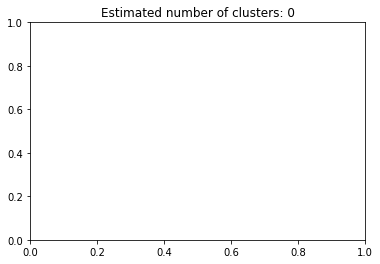

No clusters found
damping: 0.5, max_iter: 200, convergence: 15, preference: None
Estimated number of clusters: 179


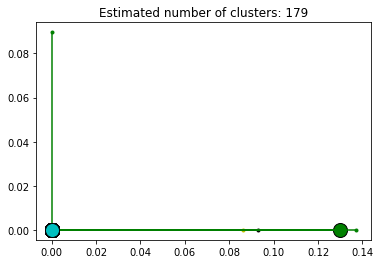

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('walk', 'distribution', 'efficiently', 'vaidya', 'time', 'learnable', 'top', 'random', 'model', 'sampling')


Cluster 122:
('process', 'gaussian', 'model', 'time', 'function', 'poisson', 'learning', 'intensity', 'constraint', 'markov')


Cluster 123:
('quantum', 'learning', 'distribution', 'disjunction', 'symmetric', 'agnostic', 'sample', 'distance', 'memory', 'bound')


Cluster 124:
('method', 'distributed', 'algorithm', 'cost', 'communication', 'prediction', 'learning', 'number', 'round', 'problem')


Cluster 125:
('matrix', 'rank', 'low', 'pca', 'optimization', 'robust', 'local', 'algorithm', 'model', 'problem')


Cluster 126:
('learning', 'python', 'learn', 'package', 'tslearn', 'series', 'scikit', 'model', 'time', 'audeep')


Cluster 127:
('dnns', 'map', 'dimensional', 'dae', 'model', 'transport', 'low', 'measure', 'eda', 'intrinsic')


Cluster 128:
('label', 'learning', 'multi', 'library', 'data', 'scikit', 'python', 'method', 'corrupted', 'theory')


Cluster 129:
('risk', 'lear

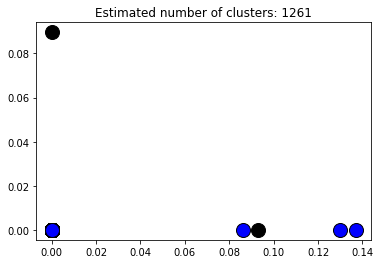

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('symbolic', 'dynamical', 'mmsr', 'system', 'expression', 'hybrid', 'learning', 'mathematical', 'modal', 'multi')


Cluster 109:
('based', 'feature', 'toolkit', 'collaborative', 'svdfeature', 'designed', 'factorization', 'filtering', 'information', 'allows')


Cluster 110:
('cpms', 'method', 'iteration', 'multivariate', 'performance', 'problem', 'smoothing', 'accurate', 'measure', 'optimizing')


Cluster 111:
('detection', 'attack', 'anomaly', 'bound', 'learning', 'analysis', 'centroid', 'issue', 'security', 'attacker')


Cluster 112:
('relational', 'exploration', 'model', 'context', 'count', 'domain', 'learning', 'problem', 'reinforcement', 'state')


Cluster 113:
('manifold', 'regularization', 'supervised', 'example', 'learning', 'result', 'semi', 'algorithm', 'analysis', 'labeled')


Cluster 114:
('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selectio


Cluster 223:
('adahedge', 'case', 'ftl', 'guarantee', 'worst', 'flipflop', 'loss', 'method', 'regret', 'constant')


Cluster 224:
('search', 'space', 'structured', 'function', 'output', 'approach', 'cost', 'prediction', 'loss', 'procedure')


Cluster 225:
('feature', 'selection', 'data', 'method', 'paradigm', 'proposed', 'approach', 'based', 'big', 'dimensional')


Cluster 226:
('boosting', 'example', 'method', 'training', 'algorithm', 'feature', 'sampling', 'adaptive', 'case', 'computer')


Cluster 227:
('manifold', 'manopt', 'matlab', 'optimization', 'toolbox')


Cluster 228:
('time', 'process', 'change', 'covariance', 'interval', 'locally', 'mean', 'multivariate', 'smoothness', 'varying')


Cluster 229:
('convex', 'complexity', 'problem', 'algorithm', 'descent', 'dual', 'method', 'optimization', 'strongly', 'applied')


Cluster 230:
('model', 'sparse', 'markov', 'covariance', 'independence', 'matrix', 'data', 'dimensional', 'gaussian', 'high')


Cluster 231:
('step', 'algorithm', '

('iteration', 'algorithm', 'policy', 'approximate', 'mpi', 'value', 'analysis', 'dp', 'tetri', 'approximation')


Cluster 339:
('issue', 'preface', 'special')


Cluster 340:
('equation', 'method', 'inference', 'matrix', 'solving', 'statistical', 'operator', 'problem', 'rigorous', 'solution')


Cluster 341:
('learning', 'poem', 'risk', 'ad', 'bandit', 'counterfactual', 'crm', 'feedback', 'minimization', 'principle')


Cluster 342:
('distance', 'bound', 'matrix', 'density', 'quantum', 'rank', 'entropy', 'estimation', 'low', 'lower')


Cluster 343:
('condition', 'learning', 'fast', 'central', 'rate', 'mixability', 'statistical', 'algorithm', 'online', 'show')


Cluster 344:
('asymptotic', 'regression', 'estimate', 'function', 'normality', 'variance', 'depends', 'dimension', 'explicitly', 'functional')


Cluster 345:
('oracle', 'inequality', 'aggregation', 'bound', 'convex', 'improvement', 'obtain', 'previous', 'regression', 'result')


Cluster 346:
('random', 'graph', 'process', 'deviatio

('rank', 'matrix', 'low', 'based', 'binary', 'bound', 'consider', 'constraint', 'estimation', 'measurement')


Cluster 458:
('gradient', 'local', 'stochastic', 'averaging', 'convergence', 'dsa', 'decentralized', 'problem', 'algorithm', 'alternative')


Cluster 459:
('collaborative', 'data', 'graph', 'statistical', 'unit', 'distributed', 'estimate', 'inference', 'matrix', 'performance')


Cluster 460:
('convergence', 'procedure', 'alternating', 'maximization', 'maximizer', 'random', 'show', '2013', 'andresen', 'approximate')


Cluster 461:
('score', 'structed', 'structured', 'task', 'measure', 'package', 'performance', 'prediction', 'adiyoss', 'aimed')


Cluster 462:
('matching', 'network', 'stereo', 'approach', 'convolutional', 'cost', 'data', 'image', 'neural', 'patch')


Cluster 463:
('gradient', 'policy', 'estimate', 'bayesian', 'critic', 'learning', 'method', 'action', 'actor', 'algorithm')


Cluster 464:
('kbrl', 'kbsf', 'learning', 'algorithm', 'reinforcement', 'transition', 'bas

('vertex', 'nomination', 'ml', 'scheme', 'based', 'graph', 'likelihood', 'prove', 'approach', 'bayes')


Cluster 569:
('kernel', 'distribution', 'characteristic', 'divisible', 'infinitely', 'mean', 'ii', 'probability', 'case', 'class')


Cluster 570:
('cut', 'graph', 'sample', 'based', 'consistency', 'cheeger', 'cloud', 'clustering', 'functionals', 'ground')


Cluster 571:
('feature', 'class', 'selection', 'based', 'classification', 'criterion', 'gaussian', 'information', 'informative', 'jointly')


Cluster 572:
('machine', 'factorization', 'fm', 'implementation', 'application', 'fastfm', 'model', 'range', 'access', 'classification')


Cluster 573:
('outcome', 'drug', 'effect', 'estimating', 'latent', 'method', 'model', 'sccs', 'approach', 'case')


Cluster 574:
('patient', 'feature', 'analysis', 'modality', 'model', 'poisson', 'unit', 'based', 'deep', 'ehr')


Cluster 575:
('cluster', 'data', 'low', 'matrix', 'method', 'rank', 'clustering', 'factorization', 'number', 'analysis')


Clu

('non', 'policy', 'parametric', 'algorithm', 'function', 'method', 'update', 'approximate', 'control', 'data')


Cluster 687:
('independence', 'test', 'statistic', 'distance', 'testing', 'vector', 'application', 'covariance', 'dependency', 'mutual')


Cluster 688:
('data', 'pca', 'sparse', 'element', 'sampling', 'algorithm', 'hybrid', 'sample', 'entry', 'recover')


Cluster 689:
('use', 'analysis', 'bayesian', 'learning', 'machine', 'nhst', 'result', 'abandonment', 'adopted', 'also')


Cluster 690:
('model', 'effect', 'learning', 'approach', 'exogenous', 'show', 'task', 'clear', 'combine', 'complex')


Cluster 691:
('tensor', 'regression', 'approach', 'bayesian', 'estimation', 'posterior', 'prior', 'algorithm', 'analysis', 'application')


Cluster 692:
('clustering', 'dimension', 'dimensional', 'discriminative', 'propose', 'sparse', 'algorithm', 'case', 'cast', 'cluster')


Cluster 693:
('tree', 'decision', 'dimension', 'ultrahigh', 'feature', 'label', 'dt', 'linear', 'model', 'sbt')



('bayesian', 'multinomial', 'regression', 'stick', 'construction', 'one', 'permuted', 'probability', 'augmented', 'binary')


Cluster 798:
('activity', 'social', 'user', 'action', 'algorithm', 'level', 'increase', 'online', 'point', 'process')


Cluster 799:
('model', 'mixture', 'problem', 'algorithm', 'information', 'side', 'component', 'one', 'parameter', 'search')


Cluster 800:
('matrix', 'bound', 'perturbation', 'covariance', 'eigenvectors', 'vector', 'new', 'norm', 'perturbed', 'random')


Cluster 801:
('hard', 'thresholding', 'bound', 'learning', 'sparsity', 'algorithm', 'machine', 'model', 'parameter', 'problem')


Cluster 802:
('graph', 'graphon', 'process', 'exchangeable', 'space', 'family', 'function', 'ha', 'measure', 'point')


Cluster 803:
('problem', 'method', 'regression', 'sgd', 'algorithm', 'applicable', 'linear', 'randomized', 'rla', 'aim')


Cluster 804:
('gaussian', 'ib', 'representation', 'information', 'data', 'embedding', 'set', 'arbitrary', 'bottleneck', 'bound

('data', 'spark', 'crowd', 'crowdsourced', 'learning', 'package', 'scalability', 'set', 'small', 'algorithm')


Cluster 913:
('algorithm', 'low', 'matrix', 'robust', 'alternating', 'pca', 'projection', 'rank', 'accelerated', 'new')


Cluster 914:
('matrix', 'value', 'singular', 'analysis', 'approach', 'completion', 'data', 'estimating', 'function', 'norm')


Cluster 915:
('kernel', 'learning', 'dynamic', 'environment', 'multi', 'performance', 'adaraker', 'nonlinear', 'unknown', 'based')


Cluster 916:
('learning', 'entity', 'latent', 'model', 'number', 'relational', 'rescal', 'factor', 'result', 'statistical')


Cluster 917:
('plda', 'sample', 'class', 'two', 'condition', 'joint', 'latent', 'model', 'nuisance', 'speaker')


Cluster 918:
('convolutional', 'kernel', 'representation', 'stability', 'analysis', 'deep', 'model', 'network', 'rkhs', 'signal')


Cluster 919:
('tensorly', 'tensor', 'deep', 'learning', 'method', 'python', 'allows', 'backend', 'library', 'machine')


Cluster 920:


('rank', 'nonconvex', 'low', 'matrix', 'optimization', 'approximation', 'condition', 'incoherence', 'local', 'minimum')


Cluster 1027:
('ms', 'subspace', 'problem', 'sample', 'minimal', 'optimization', 'algorithm', 'learning', 'expressiveness', 'heavily')


Cluster 1028:
('gaussian', 'pairwise', 'convergence', 'bp', 'mrf', 'condition', 'factorization', 'linear', 'model', 'distribution')


Cluster 1029:
('experiment', 'learning', 'multi', 'offline', 'online', 'task', 'bayesian', 'machine', 'optimization', 'show')


Cluster 1030:
('private', 'class', 'complexity', 'sample', 'concept', 'learning', 'privacy', 'differential', 'learner', 'pure')


Cluster 1031:
('data', 'group', 'ica', 'noise', 'wise', 'component', 'confounding', 'coroica', 'independent', 'model')


Cluster 1032:
('matrix', 'completion', 'collective', 'setting', 'based', 'considered', 'data', 'distribution', 'entry', 'exponential')


Cluster 1033:
('bayesian', 'predictor', 'may', 'probability', 'realizable', 'time', 'asympt

('eda', 'model', 'dae', 'algorithm', 'overfitting', 'problem', 'complex', 'distribution', 'optimization', 'autoencoders')


Cluster 1138:
('data', 'graphical', 'model', 'approach', 'assumption', 'based', 'bayesian', 'distribution', 'estimation', 'gaussian')


Cluster 1139:
('loss', 'sequence', 'memoryless', 'attribute', 'convex', 'function', 'result', 'stochastic', 'bregman', 'differentiable')


Cluster 1140:
('method', 'bo', 'dragonfly', 'optimisation', 'bayesian', 'function', 'handling', 'applied', 'available', 'domain')


Cluster 1141:
('graphical', 'model', 'change', 'network', 'high', 'work', 'algorithm', 'application', 'class', 'detection')


Cluster 1142:
('model', 'analysis', 'probability', 'conditional', 'distribution', 'independence', 'original', 'sensitivity', 'using', 'variation')


Cluster 1143:
('model', 'survival', 'individual', 'probability', 'distribution', 'patient', 'provide', 'time', 'evaluate', 'motivates')


Cluster 1144:
('convergence', 'rate', 'distribution', 'm

('algorithm', 'tree', 'model', 'regression', 'bayesian', 'birth', 'death', 'search', 'time', 'continuous')


Cluster 1250:
('control', 'cell', 'drug', 'policy', 'stochastic', 'system', 'dynamic', 'event', 'robust', 'application')


Cluster 1251:
('permutation', 'regression', 'assumption', 'response', 'stage', 'approach', 'data', 'estimated', 'linear', 'match')


Cluster 1252:
('norm', 'rate', 'sobolev', 'space', 'stronger', 'used', 'algorithm', 'bound', 'case', 'combination')


Cluster 1253:
('model', 'averaging', 'cv', 'prediction', 'high', 'method', 'cox', 'dimensional', 'process', 'proposed')


Cluster 1254:
('data', 'kernel', 'learning', 'model', 'adaptive', 'framework', 'based', 'matrix', 'non', 'parametric')


Cluster 1255:
('learning', 'disentangled', 'data', 'representation', 'unsupervised', 'disentanglement', 'evaluation', 'model', 'bias', 'covering')


Cluster 1256:
('distribution', 'image', 'noise', 'random', 'robustness', 'smoothing', 'case', 'classifier', 'dimensional', 'h

C:\Users\Donat\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


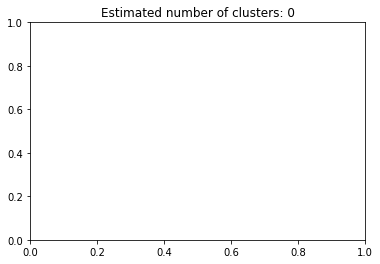

No clusters found
damping: 0.5, max_iter: 200, convergence: 30, preference: None
Estimated number of clusters: 179


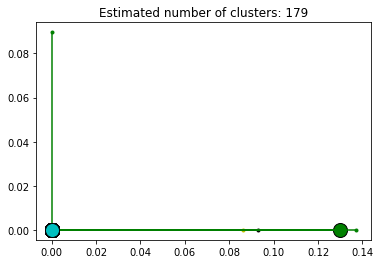

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 77:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 78:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')


Cluster 79:
('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluster 80:
('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 81:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 82:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 83:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'pro

('state', 'reservoir', 'system', 'input', 'memory', 'space', 'time', 'fading', 'filter', 'feature')


Cluster 153:
('image', 'convolutional', 'invariance', 'network', 'information', 'representation', 'model', 'data', 'neural', 'patch')


Cluster 154:
('constraint', 'algorithm', 'problem', 'convex', 'time', 'optimization', 'regret', 'online', 'set', 'pesc')


Cluster 155:
('regression', 'modal', 'loss', 'learning', 'model', 'symbolic', 'correntropy', 'risk', 'dynamical', 'mmsr')


Cluster 156:
('factor', 'data', 'outcome', 'principal', 'marginal', 'analysis', 'model', 'curve', 'latent', 'correlated')


Cluster 157:
('data', 'bayesian', 'inference', 'approximation', 'ep', 'framework', 'model', 'imaging', 'correction', 'method')


Cluster 158:
('interaction', 'high', 'data', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'problem', 'matrix')


Cluster 159:
('graph', 'algorithm', 'problem', 'learning', 'random', 'model', 'data', 'spectral', 'framework', 'time')


Cluster 16

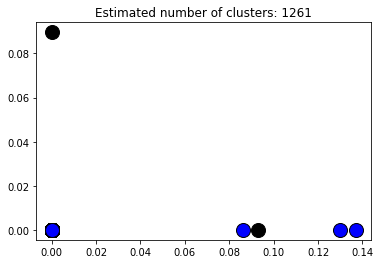

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('relational', 'exploration', 'model', 'context', 'count', 'domain', 'learning', 'problem', 'reinforcement', 'state')


Cluster 113:
('manifold', 'regularization', 'supervised', 'example', 'learning', 'result', 'semi', 'algorithm', 'analysis', 'labeled')


Cluster 114:
('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'als

('time', 'process', 'change', 'covariance', 'interval', 'locally', 'mean', 'multivariate', 'smoothness', 'varying')


Cluster 229:
('convex', 'complexity', 'problem', 'algorithm', 'descent', 'dual', 'method', 'optimization', 'strongly', 'applied')


Cluster 230:
('model', 'sparse', 'markov', 'covariance', 'independence', 'matrix', 'data', 'dimensional', 'gaussian', 'high')


Cluster 231:
('step', 'algorithm', 'hmc', 'method', 'nut', 'carlo', 'monte', 'parameter', 'random', 'sampler')


Cluster 232:
('jackknife', 'ij', 'replicates', 'bootstrap', 'estimate', 'study', 'bagged', 'bagging', 'estimator', 'forest')


Cluster 233:
('ranking', 'regret', 'bipartite', 'loss', 'bound', 'proper', 'term', 'pairwise', 'surrogate', '2011')


Cluster 234:
('linear', 'model', 'rate', 'regression', 'achieve', 'aggregation', 'best', 'predictor', 'sparse', 'combination')


Cluster 235:
('structure', 'data', 'estimating', 'graphical', 'model', 'node', 'graph', 'method', 'multi', 'network')


Cluster 236:
('

('oracle', 'inequality', 'aggregation', 'bound', 'convex', 'improvement', 'obtain', 'previous', 'regression', 'result')


Cluster 346:
('random', 'graph', 'process', 'deviation', 'property', 'behavior', 'bound', 'dimension', 'exceptional', 'lower')


Cluster 347:
('information', 'anticausal', 'causal', 'direction', 'supervised', 'cause', 'effect', 'function', 'independence', 'learning')


Cluster 348:
('clustering', 'measure', 'axiom', 'elementary', 'hierarchical', 'notion', 'set', 'user', 'without', 'additivity')


Cluster 349:
('graph', 'bound', 'labelings', 'online', 'problem', 'algorithm', 'labeling', 'latent', 'predicting', 'prediction')


Cluster 350:
('example', 'information', 'student', 'learning', 'privileged', 'teacher', 'describes', 'intelligent', 'knowledge', 'paper')


Cluster 351:
('alexey', 'bibliography', 'chervonenkis', 'comment', 'introductory')


Cluster 352:
('alexey', 'bibliography', 'chervonenkis')


Cluster 353:
('system', 'learning', 'machine', 'common', 'comput

('matching', 'network', 'stereo', 'approach', 'convolutional', 'cost', 'data', 'image', 'neural', 'patch')


Cluster 463:
('gradient', 'policy', 'estimate', 'bayesian', 'critic', 'learning', 'method', 'action', 'actor', 'algorithm')


Cluster 464:
('kbrl', 'kbsf', 'learning', 'algorithm', 'reinforcement', 'transition', 'based', 'kernel', 'computational', 'problem')


Cluster 465:
('information', 'analysis', 'sampling', 'theoretic', 'thompson', 'across', 'action', 'applies', 'bound', 'broad')


Cluster 466:
('regression', 'feature', 'compression', 'large', 'random', 'approach', 'conditionally', 'distribution', 'gaussian', 'manifold')


Cluster 467:
('loss', 'algorithm', 'boosting', 'class', 'fisher', 'function', 'proposed', 'al', 'application', 'consistent')


Cluster 468:
('sum', 'formulation', 'path', 'covariance', 'model', 'arbitrary', 'graphical', 'matrix', 'gaussian', 'topology')


Cluster 469:
('gesture', 'recognition', 'available', 'challenge', 'multimodal', 'art', 'camera', 'dat

('class', 'classifier', 'classification', 'imbalance', 'problem', 'cccd', 'cccds', 'digraph', 'art', 'cover')


Cluster 578:
('hidden', 'process', 'signal', 'variational', 'approach', 'approximation', 'diffusion', 'given', 'inference', 'method')


Cluster 579:
('class', 'model', 'data', 'extreme', 'novelty', 'one', 'detection', 'normal', 'abnormal', 'anomaly')


Cluster 580:
('momentum', 'gradient', 'method', 'size', 'step', 'stochastic', 'adaptation', 'constant', 'convex', 'equivalence')


Cluster 581:
('approach', 'chunk', 'learning', 'local', 'rate', 'svm', 'svms', 'computational', 'localized', 'method')


Cluster 582:
('risk', 'bipartite', 'class', 'probability', 'ranking', 'study', 'estimation', 'loss', 'analysis', 'based')


Cluster 583:
('factor', 'model', 'structured', 'observation', 'analysis', 'bayesian', 'data', 'dimensional', 'feature', 'latent')


Cluster 584:
('auction', 'advertiser', 'value', 'bid', 'environment', 'problem', 'active', 'ad', 'advertising', 'click')


Clus

('kernel', 'structure', 'gaussian', 'lstm', 'process', 'recurrent', 'application', 'function', 'gp', 'model')


Cluster 695:
('cnn', 'convolutional', 'csc', 'network', 'theoretical', 'forward', 'model', 'pas', 'sparse', 'alternative')


Cluster 696:
('method', 'dual', 'primal', 'variable', 'problem', 'spdc', 'better', 'convex', 'coordinate', 'empirical')


Cluster 697:
('method', 'distance', 'weighted', 'angle', 'based', 'classification', 'machine', 'support', 'svm', 'vector')


Cluster 698:
('kernel', 'minimax', 'class', 'density', 'estimation', 'estimator', 'mean', 'measure', 'paper', 'rate')


Cluster 699:
('clustering', 'random', 'model', 'cluster', 'ensemble', 'impact', 'number', 'similarity', 'size', 'assumption')


Cluster 700:
('algorithm', 'cost', 'clustering', 'hierarchical', 'approximation', 'problem', '2016', 'also', 'constant', 'cut')


Cluster 701:
('decision', 'multiagent', 'system', 'learning', 'planning', 'provides', 'support', 'agent', 'environment', 'library')


Clus

('algorithm', 'problem', 'library', 'optimization', 'stochastic', 'matlab', 'ml', 'sgdlibrary', 'use', 'approach')


Cluster 807:
('network', 'policy', 'action', 'bound', 'observation', 'side', 'structure', 'asymptotic', 'common', 'example')


Cluster 808:
('graphical', 'algorithm', 'cluster', 'dimensional', 'ecm', 'error', 'heterogeneous', 'high', 'model', 'cancer')


Cluster 809:
('mrr', 'sketched', 'sketch', 'problem', 'solution', 'classical', 'lsr', 'optimal', 'statistical', 'averaging')


Cluster 810:
('criterion', 'graph', 'adjustment', 'set', 'ancestral', 'class', 'graphical', 'acyclic', 'complete', 'covariate')


Cluster 811:
('stability', 'data', 'rate', 'preconditioning', 'risk', 'algorithm', 'analyzing', 'average', 'concave', 'empirical')


Cluster 812:
('averaging', 'batching', 'descent', 'gradient', 'least', 'mini', 'model', 'parallelizing', 'regression', 'square')


Cluster 813:
('dag', 'model', 'algorithm', 'learning', 'qvf', 'variance', 'class', 'data', 'distribution', 

('network', 'node', 'function', 'model', 'algorithm', 'associated', 'bias', 'class', 'constraint', 'edge')


Cluster 921:
('probabilistic', 'pyro', 'model', 'behavior', 'built', 'deep', 'programming', 'accelerated', 'accommodate', 'advanced')


Cluster 922:
('language', 'learning', 'iterated', 'network', 'agent', 'dynamic', 'learned', 'show', 'social', 'sustained')


Cluster 923:
('cluster', 'graph', 'subgraphs', 'weight', 'disjoint', 'semidefinite', 'clustering', 'distribution', 'edge', 'establish')


Cluster 924:
('kernel', 'sequence', 'data', 'domain', 'ordered', 'path', 'sequentialized', 'algorithm', 'arise', 'associated')


Cluster 925:
('data', 'sdm', 'netsdm', 'semantic', 'background', 'knowledge', 'mining', 'network', 'rule', 'algorithm')


Cluster 926:
('classifier', 'rejection', 'disagreement', 'algorithm', 'called', 'fast', 'pc', 'rate', 'active', 'coefficient')


Cluster 927:
('model', 'bipartite', 'community', 'addition', 'covariates', 'data', 'degree', 'detection', 'fitti

('persistence', 'density', 'diagram', 'data', 'feature', 'kernel', 'topological', 'describe', 'diagonal', 'estimate')


Cluster 1036:
('clustering', 'algorithm', 'approximation', 'better', 'good', 'number', 'setting', 'stochastic', 'user', 'additionally')


Cluster 1037:
('function', 'non', 'problem', 'smooth', 'algorithm', 'class', 'convergence', 'convex', 'method', 'also')


Cluster 1038:
('prediction', 'uncertainty', 'algorithm', 'quantifying', 'regression', 'able', 'approach', 'based', 'bounded', 'data')


Cluster 1039:
('simpledet', 'detection', 'object', 'training', 'framework', 'model', 'distributed', 'high', 'instance', 'large')


Cluster 1040:
('graph', 'graspy', 'python', 'package', 'algorithm', 'analyzing', 'apache', 'api', 'available', 'compliant')


Cluster 1041:
('function', 'communication', 'rate', 'algorithm', 'objective', 'convergence', 'convex', 'distributed', 'network', 'non')


Cluster 1042:
('diffusion', 'clustering', 'data', 'lund', 'algorithm', 'based', 'density'

('dkrr', 'learning', 'communication', 'distributed', 'optimal', 'performance', 'experiment', 'generalization', 'kernel', 'rate')


Cluster 1151:
('test', 'parallelism', 'nonparametric', 'minimax', 'proposed', 'distribution', 'study', 'anova', 'application', 'applied')


Cluster 1152:
('cornac', 'multimodal', 'recommender', 'auxiliary', 'data', 'framework', 'item', 'model', 'python', 'system')


Cluster 1153:
('algorithm', 'learning', 'pydml', 'classifier', 'distance', 'library', 'metric', 'nearest', 'provides', 'also')


Cluster 1154:
('covariance', 'estimate', 'rank', 'loss', 'one', 'portfolio', 'risk', 'asset', 'control', 'estimation')


Cluster 1155:
('space', 'framework', 'output', 'prediction', 'structured', 'algorithmic', 'general', 'implicit', 'loss', 'problem')


Cluster 1156:
('causal', 'jci', 'data', 'discovery', 'algorithm', 'different', 'implementation', 'approach', 'case', 'certain')


Cluster 1157:
('model', 'latent', 'feature', 'data', 'datasets', 'heterogeneous', 'alloc

damping: 0.5, max_iter: 400, convergence: 8, preference: -50
Estimated number of clusters: 1261


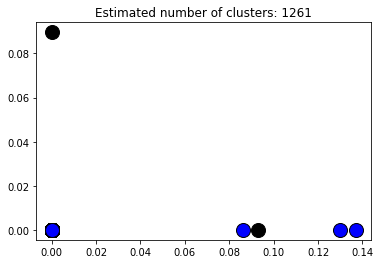

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('bag', 'learning', 'mil', 'algorithm', 'instance', 'label', 'application', 'class', 'hypothesis', 'sample')


Cluster 92:
('policy', 'algorithm', 'bound', 'iteration', 'chain', 'derive', 'learning', 'least', 'markov', 'performance')


Cluster 93:
('hierarchical', 'part', 'human', 'model', 'action', 'based', 'body', 'parsing', 'pose', 'poselets')


Cluster 94:
('algorithm', 'svm', 'training', 'bsgd', 'budget', 'sgd', 'budgeted', 'data', 'large', 'maintenance')


Cluster 95:
('model', 'classification', 'data', 'hierarchical', 'inference', 'effect', 'subject', 'accuracy', 'bayesian', 'estimation')


Cluster 96:
('memory', 'quantum', 'algorithm', 'associative', 'pattern', 'application', 'exponential', 'grover', 'intersection', 'model')


Cluster 97:
('error', 'policy', 'dpp', 'average', 'iteration', 'based', 'bound', 'dynamic', 'method', 'optimal')


Cluster 98:
('string', 'sally', 'data', 'learning', 'space', 'tool', 'vector', 'word', 'applied', 'embedding')


Cluster 99:
('function', 'm

('network', 'problem', 'data', 'difference', 'node', 'set', 'condition', 'two', 'across', 'algorithm')


Cluster 200:
('package', 'linear', 'problem', 'solving', 'clime', 'efficiently', 'estimation', 'fastclime', 'implement', 'large')


Cluster 201:
('learning', 'online', 'large', 'libol', 'algorithm', 'also', 'comprehensive', 'library', 'scale', 'user')


Cluster 202:
('dtsl', 'l1', 'markov', 'network', 'structure', 'tree', 'decision', 'dt', 'learning', 'using')


Cluster 203:
('metric', 'ground', 'distance', 'learning', 'feature', 'optimal', 'parameter', 'set', 'transport', 'algorithm')


Cluster 204:
('graph', 'matrix', 'prediction', 'sparsity', 'var', 'adjacency', 'autoregressive', 'feature', 'involves', 'joint')


Cluster 205:
('stochastic', 'gradient', 'logistic', 'observation', 'averaged', 'convexity', 'eigenvalue', 'generalized', 'local', 'regression')


Cluster 206:
('interaction', 'variable', 'computational', 'high', 'order', 'approach', 'class', 'data', 'informative', 'inter

('discrete', 'model', 'boltzmann', 'machine', 'restricted', 'hidden', 'product', 'simplices', 'state', 'variable')


Cluster 314:
('code', 'gpu', 'methodology', 'compilation', 'gp', 'individual', 'machine', 'also', 'assembly', 'generates')


Cluster 315:
('learning', 'new', 'active', 'complexity', 'compression', 'label', 'size', 'space', 'version', 'based')


Cluster 316:
('algorithm', 'approachability', 'condition', 'response', 'action', 'blackwell', 'certain', 'game', 'opponent', 'payoff')


Cluster 317:
('clustering', 'approach', 'based', 'consistency', 'minimisation', 'probabilistic', 'prototype', 'space', 'strong', 'applied')


Cluster 318:
('bound', 'analysis', 'bayesian', 'pac', 'extensive', 'learning', 'majority', 'mincq', 'propose', 'vote')


Cluster 319:
('algorithmic', 'leverage', 'sampling', 'based', 'data', 'method', 'result', 'leveraging', 'statistical', 'algorithm')


Cluster 320:
('matrix', 'distributed', 'factorization', 'algorithm', 'conquer', 'divide', 'framework', '

('cluster', 'computational', 'growing', 'localization', 'number', 'planted', 'problem', 'statistical', 'submatrices', 'submatrix')


Cluster 429:
('causal', 'effect', 'linear', 'cause', 'distribution', 'inference', 'non', 'residual', 'asymmetry', 'direction')


Cluster 430:
('test', 'partition', 'size', 'based', 'consistent', 'data', 'statistic', 'detecting', 'distribution', 'free')


Cluster 431:
('sampler', 'learning', 'dag', 'graph', 'method', 'structure', 'bayesian', 'conditional', 'distribution', 'gibbs')


Cluster 432:
('bound', 'dimension', 'learning', 'matrix', 'concentration', 'string', 'hankel', 'spectral', 'distribution', 'empirical')


Cluster 433:
('data', 'method', 'causal', 'cause', 'benchmark', 'discovery', 'problem', 'effect', 'observational', 'real')


Cluster 434:
('task', 'model', 'structure', 'learning', 'gaussian', 'problem', 'relationship', 'proposed', 'also', 'classification')


Cluster 435:
('learning', 'mllib', 'spark', 'machine', 'open', 'source', 'apache', '

('machine', 'boltzmann', 'restricted', 'universal', 'temporal', 'dependence', 'result', 'time', 'approximation', 'approximator')


Cluster 549:
('step', 'sgld', 'size', 'bias', 'gradient', 'stochastic', 'variance', 'asymptotic', 'data', 'decreasing')


Cluster 550:
('pesc', 'function', 'problem', 'constraint', 'evaluated', 'evaluation', 'information', 'objective', 'optimization', 'acquisition')


Cluster 551:
('structure', 'biclustering', 'matrix', 'data', 'minimax', 'optimal', 'also', 'block', 'bound', 'case')


Cluster 552:
('dimension', 'learner', 'teaching', 'training', 'hypothesis', 'linear', 'machine', 'regression', 'set', 'also')


Cluster 553:
('layer', 'hidden', 'network', 'data', 'deep', 'first', 'gamma', 'gbn', 'width', 'augmentable')


Cluster 554:
('method', 'derivative', 'estimator', 'regression', 'bias', 'difference', 'existing', 'first', 'framework', 'function')


Cluster 555:
('mechanism', 'crowdsourcing', 'incentive', 'payment', 'possible', 'worker', 'compatible', 'da

('clustering', 'graph', 'general', 'result', 'framework', 'including', 'model', 'new', 'node', 'observation')


Cluster 665:
('partitioning', 'uniform', 'hypergraphs', 'algorithm', 'hypergraph', 'sampling', 'tensor', 'work', 'approach', 'computer')


Cluster 666:
('algorithm', 'convex', 'function', 'optimal', 'optimization', 'two', 'analysis', 'bandit', 'feedback', 'order')


Cluster 667:
('coefficient', 'data', 'dynamic', 'model', 'perishability', 'pricing', 'varying')


Cluster 668:
('approach', 'compressed', 'effect', 'exhibiting', 'grouping', 'new', 'recovery', 'robust', 'sensing', 'sparse')


Cluster 669:
('surrogate', 'loss', 'consistency', 'function', 'ordinal', 'regression', 'absolute', 'fisher', 'method', 'binary')


Cluster 670:
('divergence', 'estimator', 'homogeneous', 'model', 'discrete', 'probabilistic', 'space', 'constant', 'localized', 'measure')


Cluster 671:
('estimator', 'density', 'divergence', 'based', 'dimensional', 'proposed', 'show', 'convergence', 'element', '

('optimization', 'hyperparameter', 'learning', 'problem', 'uralg', 'algorithm', 'approach', 'bandit', 'based', 'bayesian')


Cluster 782:
('submatrix', 'algorithm', 'problem', 'localization', 'mean', 'message', 'noise', 'passing', 'community', 'elevated')


Cluster 783:
('bit', 'network', 'neural', 'quantized', 'accuracy', 'activation', 'qnns', 'weight', 'gradient', 'operation')


Cluster 784:
('community', 'network', 'method', 'weighted', 'detection', 'node', 'null', 'algorithm', 'background', 'ccme')


Cluster 785:
('data', 'method', 'persistence', 'diagram', 'kernel', 'tda', 'topological', 'weight', 'accurate', 'advantage')


Cluster 786:
('pycobra', 'learning', 'python', 'ensemble', 'visualisation', 'algorithm', 'available', 'documentation', 'http', 'library')


Cluster 787:
('kernel', 'kelp', 'java', 'algorithm', 'learning', 'based', 'easy', 'enables', 'extensive', 'implementation')


Cluster 788:
('estimation', 'causality', 'integrated', 'kernel', 'matrix', 'order', 'process', 'a

('convex', 'non', 'approach', 'descent', 'low', 'projected', 'algorithm', 'dimensional', 'gradient', 'rank')


Cluster 900:
('label', 'multi', 'library', 'method', 'python', 'scikit', 'classification', 'division', 'implementation', 'multilearn')


Cluster 901:
('algorithm', 'risk', 'empirical', 'problem', 'computationally', 'design', 'generalized', 'large', 'linear', 'minimizer')


Cluster 902:
('algorithm', 'variable', 'selection', 'heuristic', 'proposed', 'backward', 'family', 'feature', 'forward', 'lasso')


Cluster 903:
('regret', 'policy', 'model', 'choice', 'pricing', 'customer', 'distribution', 'feature', 'firm', 'parameter')


Cluster 904:
('gl', 'method', 'matrix', 'consistent', 'covariance', 'sample', 'thresholded', 'data', 'graphical', 'result')


Cluster 905:
('learning', 'measurement', 'theory', 'vector', 'approximately', 'bit', 'compressed', 'correct', 'one', 'pac')


Cluster 906:
('clustering', 'approximation', 'kernel', 'mean', 'nystrom', 'linear', 'work', 'algorithm', 

('cox', 'proposed', 'methodology', 'proportional', 'data', 'event', 'function', 'likelihood', 'log', 'loss')


Cluster 1015:
('logical', 'prediction', 'deep', 'drm', 'explanation', 'local', 'drms', 'feature', 'model', 'provided')


Cluster 1016:
('dirichlet', 'topic', 'model', 'distribution', 'smoothness', 'vector', 'sparsity', 'variational', 'autoencoder', 'competitive')


Cluster 1017:
('estimator', 'subsampling', 'also', 'asymptotic', 'based', 'estimation', 'optimal', 'poisson', 'probability', 'data')


Cluster 1018:
('spurious', 'valley', 'model', 'dimension', 'exist', 'intrinsic', 'network', 'neural', 'non', 'absence')


Cluster 1019:
('cubic', 'regularization', 'svrc', 'method', 'stochastic', 'algorithm', 'hessian', 'lite', 'local', 'minimum')


Cluster 1020:
('constraint', 'process', 'linear', 'function', 'gaussian', 'set', 'approach', 'gp', 'operator', 'posterior')


Cluster 1021:
('loss', 'boosting', 'multiclass', 'algorithm', 'mcboost', 'margin', 'codewords', 'function', 'pro

('algorithm', 'high', 'dimension', 'horseshoe', 'mcmc', 'model', 'also', 'application', 'approximate', 'chain')


Cluster 1133:
('network', 'assumption', 'data', 'graphical', 'model', 'observation', 'connected', 'dimensional', 'gaussian', 'high')


Cluster 1134:
('condition', 'error', 'identifiability', 'anms', 'variance', 'algorithm', 'identifiable', 'new', 'additive', 'doe')


Cluster 1135:
('communication', 'gadmm', 'worker', 'distributed', 'efficient', 'problem', 'framework', 'learning', 'algorithm', 'alternating')


Cluster 1136:
('player', 'arm', 'assume', 'bandit', 'loss', 'multi', 'work', '2016', 'action', 'adversarial')


Cluster 1137:
('eda', 'model', 'dae', 'algorithm', 'overfitting', 'problem', 'complex', 'distribution', 'optimization', 'autoencoders')


Cluster 1138:
('data', 'graphical', 'model', 'approach', 'assumption', 'based', 'bayesian', 'distribution', 'estimation', 'gaussian')


Cluster 1139:
('loss', 'sequence', 'memoryless', 'attribute', 'convex', 'function', 're

('algorithm', 'approximation', 'function', 'loss', 'polynomial', 'attempt', 'complexity', 'efficient', 'error', 'interactive')


Cluster 1249:
('algorithm', 'tree', 'model', 'regression', 'bayesian', 'birth', 'death', 'search', 'time', 'continuous')


Cluster 1250:
('control', 'cell', 'drug', 'policy', 'stochastic', 'system', 'dynamic', 'event', 'robust', 'application')


Cluster 1251:
('permutation', 'regression', 'assumption', 'response', 'stage', 'approach', 'data', 'estimated', 'linear', 'match')


Cluster 1252:
('norm', 'rate', 'sobolev', 'space', 'stronger', 'used', 'algorithm', 'bound', 'case', 'combination')


Cluster 1253:
('model', 'averaging', 'cv', 'prediction', 'high', 'method', 'cox', 'dimensional', 'process', 'proposed')


Cluster 1254:
('data', 'kernel', 'learning', 'model', 'adaptive', 'framework', 'based', 'matrix', 'non', 'parametric')


Cluster 1255:
('learning', 'disentangled', 'data', 'representation', 'unsupervised', 'disentanglement', 'evaluation', 'model', 'bia

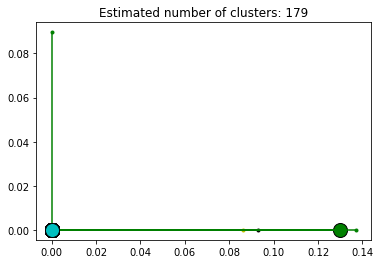

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 77:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 78:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')


Cluster 79:
('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluster 80:
('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 81:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 82:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 83:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'pro

('constraint', 'algorithm', 'problem', 'convex', 'time', 'optimization', 'regret', 'online', 'set', 'pesc')


Cluster 155:
('regression', 'modal', 'loss', 'learning', 'model', 'symbolic', 'correntropy', 'risk', 'dynamical', 'mmsr')


Cluster 156:
('factor', 'data', 'outcome', 'principal', 'marginal', 'analysis', 'model', 'curve', 'latent', 'correlated')


Cluster 157:
('data', 'bayesian', 'inference', 'approximation', 'ep', 'framework', 'model', 'imaging', 'correction', 'method')


Cluster 158:
('interaction', 'high', 'data', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'problem', 'matrix')


Cluster 159:
('graph', 'algorithm', 'problem', 'learning', 'random', 'model', 'data', 'spectral', 'framework', 'time')


Cluster 160:
('data', 'supervised', 'graph', 'unlabeled', 'semi', 'consistency', 'learning', 'cut', 'based', 'harmonic')


Cluster 161:
('dual', 'method', 'convex', 'problem', 'primal', 'complexity', 'algorithm', 'iteration', 'solution', 'optimization')


Clust

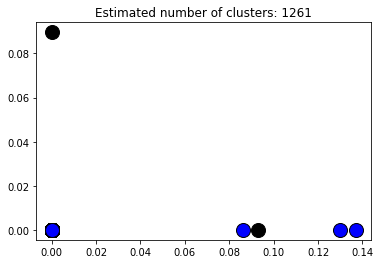

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'learning', 'lmm', 'based', 'data', 'edge', 'algorithm', 'criterion', 'network', 'skeleton')


Cluster 123:
('dimension', 'similarity', 'independent', 'algorithm', 'computation', 'data', 'jaccard', 'large', 'result', 'twitter')


Cluster 124:
('model', 'sign', 'handshape', 'signer', 'affine', 'hand', 'aff', 'appearance', 'approach', 'classification')


Cluster 125:
('method', 'model', 'nonparametric', 'variable', 'learning', 'problem', 'proposed', 'regularization', 'selection', 'show')


Cluster 126:
('matrix', 'cluster', 'similarity', 'clustering', 'factorization', 'given', 'based', 'left', 'stochastic', 'algorithm')


Cluster 127:
('consistent', 'convergence', 'maximum', 'unfolding', 'variance', 'assumption', 'convex', 'dimensionality', 'e

('bayesian', 'posterior', 'latent', 'inference', 'present', 'regbayes', 'regularization', 'distribution', 'infinite', 'prior')


Cluster 238:
('prior', 'model', 'parameter', 'approach', 'nn', 'scale', 'hierarchical', 'network', 'relevance', 'using')


Cluster 239:
('data', 'missing', 'algorithm', 'imputation', 'likelihood', 'observed', 'alternating', 'dimensional', 'high', 'log')


Cluster 240:
('network', 'neural', 'dropout', 'overfitting', 'large', 'different', 'learning', 'many', 'net', 'number')


Cluster 241:
('question', 'concept', 'factor', 'learning', 'analytics', 'estimate', 'solution', 'underlying', 'analysis', 'based')


Cluster 242:
('graph', 'distribution', 'acyclic', 'additive', 'causal', 'directed', 'independence', 'method', 'model', 'noise')


Cluster 243:
('image', 'mixture', 'model', 'patch', 'prior', 'based', 'coding', 'comparable', 'compression', 'easily')


Cluster 244:
('chain', 'markov', 'inference', 'mcmc', 'distribution', 'sampling', 'advantage', 'approximation

('bound', 'arm', 'mean', 'sample', 'distribution', 'problem', 'stratum', 'carlo', 'deviation', 'enough')


Cluster 358:
('data', 'estimation', 'gaussian', 'learning', 'method', 'structure', 'algorithm', 'based', 'bayesian', 'concave')


Cluster 359:
('horizon', 'independent', 'strategy', 'asymptotic', 'dependent', 'likelihood', 'maximum', 'minimax', 'normalized', 'achievability')


Cluster 360:
('erm', 'multiclass', 'class', 'learner', 'setting', 'complexity', 'learning', 'principle', 'sample', 'bound')


Cluster 361:
('conditional', 'model', 'restricted', 'unit', 'boltzmann', 'distribution', 'machine', 'probability', 'input', 'layer')


Cluster 362:
('approach', 'causal', 'learning', 'statistical', 'variable', 'also', 'causality', 'dependency', 'machine', 'markov')


Cluster 363:
('inference', 'libra', 'model', 'network', 'learning', 'algorithm', 'exact', 'probabilistic', 'toolkit', 'academia')


Cluster 364:
('automaton', 'complexity', 'equivalence', 'learning', 'multiplicity', 'tree

('learning', 'regularization', 'iterative', 'consider', 'convex', 'function', 'loss', 'new', 'achieved', 'algorithm')


Cluster 475:
('network', 'community', 'detection', 'internet', 'overlapping', 'scale', 'approach', 'inference', 'latent', 'million')


Cluster 476:
('risk', 'patient', 'model', 'stratification', 'learning', 'time', 'admission', 'outcome', '000', 'approach')


Cluster 477:
('component', 'framework', 'learning', 'task', 'feature', 'formulation', 'multitask', 'new', 'study', 'two')


Cluster 478:
('learning', 'multitask', 'representation', 'task', 'method', 'data', 'feature', 'independent', 'learn', 'space')


Cluster 479:
('variable', 'model', 'selection', 'method', 'gradient', 'informative', 'proposed', 'assumption', 'example', 'free')


Cluster 480:
('lmrl2', 'game', 'learning', 'stochastic', 'algorithm', 'cooperative', 'discus', 'independent', 'learner', 'lenient')


Cluster 481:
('breast', 'cancer', 'risk', 'structure', 'feature', 'mammography', 'method', 'predictio


Cluster 593:
('backtracking', 'data', 'dimensional', 'high', 'interaction', 'modelling')


Cluster 594:
('cross', 'fold', 'validation', 'least', 'variance', 'square', 'also', 'case', 'density', 'estimation')


Cluster 595:
('model', 'method', 'matrix', 'fast', 'nystrã', 'approximation', 'prototype', 'efficient', 'spsd', 'accuracy')


Cluster 596:
('decision', 'data', 'different', 'objective', 'support', 'approach', 'function', 'maker', 'markov', 'multi')


Cluster 597:
('statistic', 'relationship', 'dependence', 'measure', 'equitability', 'ha', 'independence', 'new', 'pair', 'power')


Cluster 598:
('np', 'classification', 'classifier', 'error', 'type', 'neyman', 'paradigm', 'pearson', 'binary', 'construct')


Cluster 599:
('sketching', 'statistical', 'algorithm', 'data', 'problem', 'perspective', 'randomized', 'using', 'algorithmic', 'bound')


Cluster 600:
('model', 'planar', 'ising', 'learning', 'best', 'graphical', 'inference', 'variable', 'application', 'approximate')


Cluster 6

('rank', 'given', 'tensor', 'completion', 'matrix', 'bound', 'data', 'low', 'view', 'probability')


Cluster 710:
('model', 'network', 'constraint', 'iterative', 'mip', 'order', 'problem', 'topological', 'algorithm', 'based')


Cluster 711:
('control', 'dynamic', 'learning', 'stability', 'controller', 'gaussian', 'gp', 'process', 'result', 'acting')


Cluster 712:
('algorithm', 'bound', 'gradient', 'regression', 'term', 'condition', 'consider', 'dimension', 'error', 'initial')


Cluster 713:
('classification', 'class', 'label', 'procedure', 'set', 'expected', 'number', 'risk', 'size', 'confidence')


Cluster 714:
('item', 'setting', 'ranked', 'list', 'feedback', 'learner', 'ranking', 'top', 'online', 'relevance')


Cluster 715:
('approximation', 'point', 'pseudo', 'framework', 'new', 'power', 'data', 'ep', 'gaussian', 'method')


Cluster 716:
('stochastic', 'asc', 'composition', 'pg', 'gradient', 'method', 'algorithm', 'first', 'optimization', 'problem')


Cluster 717:
('bayesian', 'di

('gp', 'approach', 'local', 'prediction', 'region', 'regression', 'response', 'boundary', 'datasets', 'input')


Cluster 829:
('posterior', 'data', 'subset', 'distribution', 'full', 'method', 'sample', 'sampling', 'across', 'approach')


Cluster 830:
('experience', 'replay', 'control', 'learning', 'method', 'reinforcement', 'replayed', 'buffer', 'choice', 'exploration')


Cluster 831:
('condition', 'sdar', 'error', 'iteration', 'solution', 'approach', 'high', 'algorithm', 'bound', 'certain')


Cluster 832:
('algorithm', 'change', 'point', 'graphical', 'model', 'large', 'also', 'data', 'gaussian', 'number')


Cluster 833:
('regression', 'approach', 'model', 'outlier', 'robust', 'distribution', 'estimation', 'optimization', 'bias', 'dro')


Cluster 834:
('optimal', 'distance', 'regularized', 'transport', 'algorithm', 'alternate', 'data', 'divergence', 'framework', 'mover')


Cluster 835:
('elfi', 'inference', 'free', 'likelihood', 'method', 'component', 'distance', 'engine', 'graph', 'ha

('hyperparameters', 'algorithm', 'tuning', 'default', 'learning', 'machine', 'tunability', 'based', 'measure', 'user')


Cluster 944:
('agent', 'swarm', 'mean', 'deep', 'embedding', 'representation', 'system', 'concatenation', 'decentralized', 'end')


Cluster 945:
('architecture', 'search', 'neural', 'progress', 'recognition', 'strategy', 'according', 'aspect', 'automated', 'categorize')


Cluster 946:
('matrix', 'time', 'algorithm', 'running', 'improved', 'optimal', 'problem', 'space', 'consider', 'direction')


Cluster 947:
('method', 'convergence', 'first', 'order', 'second', 'art', 'direction', 'empirical', 'global', 'linear')


Cluster 948:
('method', 'performance', 'kernel', 'recognition', 'speech', 'attain', 'feature', 'model', 'set', 'acoustic')


Cluster 949:
('regression', 'method', 'proposed', 'derivative', 'error', 'estimation', 'estimator', 'absolute', 'asymptotic', 'deviation')


Cluster 950:
('norm', 'bound', 'hosvd', 'perturbation', 'sup', 'tensor', 'singular', 'low', 

('network', 'node', 'horseshoe', 'model', 'neural', 'selection', 'bayesian', 'number', 'predictive', 'approach')


Cluster 1064:
('mala', 'algorithm', 'langevin', 'step', 'bound', 'concave', 'density', 'log', 'metropolis', 'mixing')


Cluster 1065:
('image', 'convolutional', 'architecture', 'augmentation', 'data', 'invariance', 'network', 'small', 'transformation', 'cnns')


Cluster 1066:
('constraint', 'algorithm', 'regret', 'violation', 'online', 'achieve', 'convex', 'long', 'optimization', 'paper')


Cluster 1067:
('regression', 'modal', 'risk', 'function', 'study', 'computational', 'estimation', 'excess', 'generalization', 'learning')


Cluster 1068:
('data', 'fake', 'model', 'piece', 'source', 'receiver', 'analysis', 'driven', 'sender', 'analyzing')


Cluster 1069:
('model', 'network', 'edge', 'latent', 'covariates', 'space', 'statistical', 'algorithm', 'based', 'data')


Cluster 1070:
('clustering', 'guarantee', 'llpd', 'spectral', 'algorithm', 'cluster', 'dimensional', 'number',

('automatic', 'model', 'sparsity', 'art', 'bisn', 'dimension', 'gradient', 'graphical', 'method', 'sparse')


Cluster 1181:
('algorithm', 'coordinate', 'submodular', 'approximation', 'function', 'continuous', 'maximization', 'monotone', 'problem', 'wise')


Cluster 1182:
('data', 'learning', 'distributed', 'unlabeled', 'dmee', 'node', 'rate', 'supervised', 'algorithm', 'error')


Cluster 1183:
('mahout', 'apache', 'dataflow', 'system', 'learning', 'machine', 'distributed', 'offering', 'scalable', 'several')


Cluster 1184:
('test', 'high', 'dimensional', 'alternative', 'parameter', 'adaptive', 'aispu', 'alzheimer', 'data', 'disease')


Cluster 1185:
('algorithm', 'system', 'adaptive', 'differential', 'convergence', 'general', 'learning', 'method', 'optimization', 'condition')


Cluster 1186:
('explainability', 'toolkit', 'ai', 'explanation', 'method', 'different', '360', 'algorithm', 'also', 'data')


Cluster 1187:
('cost', 'gaussian', 'approximation', 'inference', 'computational', 'en

damping: 0.5, max_iter: 400, convergence: 15, preference: -50
Estimated number of clusters: 0


C:\Users\Donat\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


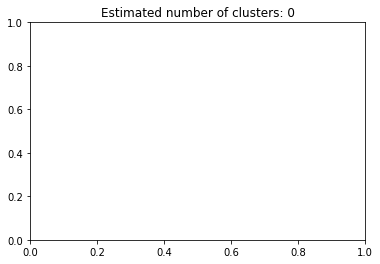

No clusters found
damping: 0.5, max_iter: 400, convergence: 15, preference: None
Estimated number of clusters: 179


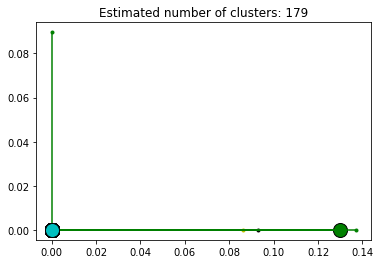

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('model', 'graphical', 'data', 'network', 'problem', 'method', 'gaussian', 'graph', 'node', 'lasso')


Cluster 85:
('patient', 'model', 'time', 'data', 'image', 'disease', 'risk', 'clinical', 'learning', 'mri')


Cluster 86:
('spurious', 'model', 'valley', 'local', 'recovery', 'fit', 'minimum', 'discovery', 'dimension', 'point')


Cluster 87:
('data', 'decision', 'objective', 'pomdps', 'function', 'information', 'analysis', 'solution', 'optimal', 'jl')


Cluster 88:
('classifier', 'error', 'np', 'type', 'classification', 'oracle', 'data', 'class', 'inequality', 'neyman')


Cluster 89:
('method', 'statistical', 'problem', 'sketching', 'data', 'mrr', 'algorithm', 'equation', 'randomized', 'sketched')


Cluster 90:
('loss', 'multiclass', 'problem', 'proper', 'sequence', 'algorithm', 'result', 'bayes', 'convex', 'function')


Cluster 91:
('lpcc', 'latent', 'part', 'algorithm', 'cluster', 'graph', 'true', 'model', 'data', 'pcc')


Cluster 92:
('hierarchical', 'algorithm', 'model', 'based', 

('attack', 'based', 'detection', 'method', 'random', 'learning', 'distribution', 'image', 'robustness', 'smoothing')


Cluster 164:
('ensemble', 'model', 'relational', 'method', 'learning', 'base', 'learner', 'prediction', 'data', 'exploration')


Cluster 165:
('kernel', 'square', 'least', 'regression', 'approximation', 'gradient', 'model', 'matrix', 'regularized', 'partial')


Cluster 166:
('dictionary', 'algorithm', 'local', 'learning', 'optimal', 'representation', 'asymptotic', 'reference', 'multiscale', 'robustness')


Cluster 167:
('class', 'detection', 'data', 'set', 'classifier', 'model', 'classification', 'method', 'problem', 'algorithm')


Cluster 168:
('model', 'survival', 'scikit', 'time', 'prediction', 'explanation', 'cox', 'event', 'proposed', 'method')


Cluster 169:
('toolbox', 'library', 'python', 'learning', 'data', 'ai', 'olps', 'software', 'reinforcement', 'source')


Cluster 170:
('algorithm', 'stochastic', 'gradient', 'optimization', 'nonconvex', 'problem', 'functi

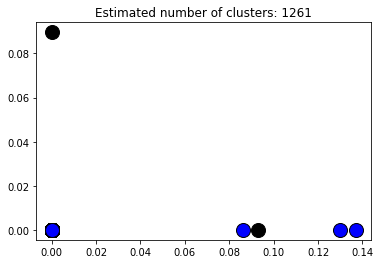

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'l

('jackknife', 'ij', 'replicates', 'bootstrap', 'estimate', 'study', 'bagged', 'bagging', 'estimator', 'forest')


Cluster 233:
('ranking', 'regret', 'bipartite', 'loss', 'bound', 'proper', 'term', 'pairwise', 'surrogate', '2011')


Cluster 234:
('linear', 'model', 'rate', 'regression', 'achieve', 'aggregation', 'best', 'predictor', 'sparse', 'combination')


Cluster 235:
('structure', 'data', 'estimating', 'graphical', 'model', 'node', 'graph', 'method', 'multi', 'network')


Cluster 236:
('graph', 'time', 'commute', 'hitting', 'distance', 'random', 'vertex', 'degree', 'expected', 'learning')


Cluster 237:
('bayesian', 'posterior', 'latent', 'inference', 'present', 'regbayes', 'regularization', 'distribution', 'infinite', 'prior')


Cluster 238:
('prior', 'model', 'parameter', 'approach', 'nn', 'scale', 'hierarchical', 'network', 'relevance', 'using')


Cluster 239:
('data', 'missing', 'algorithm', 'imputation', 'likelihood', 'observed', 'alternating', 'dimensional', 'high', 'log')




('graph', 'bound', 'labelings', 'online', 'problem', 'algorithm', 'labeling', 'latent', 'predicting', 'prediction')


Cluster 350:
('example', 'information', 'student', 'learning', 'privileged', 'teacher', 'describes', 'intelligent', 'knowledge', 'paper')


Cluster 351:
('alexey', 'bibliography', 'chervonenkis', 'comment', 'introductory')


Cluster 352:
('alexey', 'bibliography', 'chervonenkis')


Cluster 353:
('system', 'learning', 'machine', 'common', 'computing', 'delay', 'demonstrate', 'descent', 'encoding', 'far')


Cluster 354:
('beamformers', 'meg', 'vector', 'beamforming', 'proposed', 'activity', 'case', 'covariance', 'data', 'dimension')


Cluster 355:
('data', 'set', 'different', 'combine', 'constraint', 'algorithm', 'causal', 'intervention', 'model', 'overlapping')


Cluster 356:
('entropy', 'function', 'cone', 'proper', 'rule', 'scoring', 'space', 'associated', 'density', 'derivative')


Cluster 357:
('bound', 'arm', 'mean', 'sample', 'distribution', 'problem', 'stratum', '

('gesture', 'recognition', 'available', 'challenge', 'multimodal', 'art', 'camera', 'data', 'including', 'overview')


Cluster 470:
('td', 'method', 'parameter', 'step', 'update', 'difference', 'different', 'emphasizing', 'emphatic', 'function')


Cluster 471:
('auction', 'price', 'reserve', 'revenue', 'problem', 'algorithm', 'learning', 'second', 'analysis', 'cast')


Cluster 472:
('coordinate', 'data', 'big', 'descent', 'iteration', 'method', 'node', 'partition', 'problem', '3tb')


Cluster 473:
('empirical', 'learning', 'risk', 'statistic', 'incomplete', 'data', 'erm', 'functionals', 'minimization', 'optimization')


Cluster 474:
('learning', 'regularization', 'iterative', 'consider', 'convex', 'function', 'loss', 'new', 'achieved', 'algorithm')


Cluster 475:
('network', 'community', 'detection', 'internet', 'overlapping', 'scale', 'approach', 'inference', 'latent', 'million')


Cluster 476:
('risk', 'patient', 'model', 'stratification', 'learning', 'time', 'admission', 'outcome', 

('risk', 'bipartite', 'class', 'probability', 'ranking', 'study', 'estimation', 'loss', 'analysis', 'based')


Cluster 583:
('factor', 'model', 'structured', 'observation', 'analysis', 'bayesian', 'data', 'dimensional', 'feature', 'latent')


Cluster 584:
('auction', 'advertiser', 'value', 'bid', 'environment', 'problem', 'active', 'ad', 'advertising', 'click')


Cluster 585:
('wavelet', 'analysis', 'decomposition', 'forest', 'function', 'random', 'sparse', 'application', 'approach', 'approximation')


Cluster 586:
('matching', 'treatment', 'effect', 'group', 'based', 'causal', 'data', 'inference', 'information', 'mi')


Cluster 587:
('rank', 'spearman', 'list', 'multivariate', 'aggregation', 'correlation', 'missing', 'ranked', 'aggregating', 'best')


Cluster 588:
('link', 'model', 'network', 'nonparametric', 'prediction')


Cluster 589:
('spurious', 'fit', 'model', 'discovery', 'goodness', 'variable', 'algorithm', 'asymptotic', 'better', 'correlation')


Cluster 590:
('data', 'functi


Cluster 697:
('method', 'distance', 'weighted', 'angle', 'based', 'classification', 'machine', 'support', 'svm', 'vector')


Cluster 698:
('kernel', 'minimax', 'class', 'density', 'estimation', 'estimator', 'mean', 'measure', 'paper', 'rate')


Cluster 699:
('clustering', 'random', 'model', 'cluster', 'ensemble', 'impact', 'number', 'similarity', 'size', 'assumption')


Cluster 700:
('algorithm', 'cost', 'clustering', 'hierarchical', 'approximation', 'problem', '2016', 'also', 'constant', 'cut')


Cluster 701:
('decision', 'multiagent', 'system', 'learning', 'planning', 'provides', 'support', 'agent', 'environment', 'library')


Cluster 702:
('algorithm', 'analysis', 'descent', 'bound', 'ftrl', 'mirror', 'adaptive', 'learning', 'regret', 'allows')


Cluster 703:
('method', 'cost', 'algorithm', 'distributed', 'communication', 'existing', 'step', 'system', 'variable', 'block')


Cluster 704:
('learning', 'data', 'least', 'square', 'distributed', 'expectation', 'function', 'output', 'rat

('condition', 'error', 'classification', 'lipschitz', 'nearest', 'neighbor', 'probability', 'concept', 'convergence', 'excess')


Cluster 816:
('corrupted', 'label', 'learning', 'theory')


Cluster 817:
('algorithm', 'stream', 'pool', 'setting', 'based', 'element', 'select', 'interactive', 'precognitive', 'bound')


Cluster 818:
('distributed', 'framework', 'convex', 'efficient', 'general', 'non', 'cocoa', 'communication', 'datasets', 'ha')


Cluster 819:
('process', 'bound', 'empirical', 'probability', 'series', 'tail', 'time', 'class', 'condition', 'dependence')


Cluster 820:
('cluster', 'likelihood', 'response', 'variable', 'algorithm', 'penalized', 'regression', 'binomial', 'method', 'penalty')


Cluster 821:
('kernel', 'distance', 'hsic', 'independence', 'mmd', 'product', 'tensor', 'characteristic', 'statistic', 'also')


Cluster 822:
('list', 'rule', 'optimal', 'data', 'categorical', 'interpretable', 'produce', 'risk', 'according', 'accurate')


Cluster 823:
('singularity', 'net

('method', 'accuracy', 'dimension', 'randomized', 'cost', 'bootstrap', 'computation', 'error', 'general', 'given')


Cluster 933:
('base', 'distribution', 'model', 'problem', 'setting', 'classification', 'contamination', 'general', 'label', 'learning')


Cluster 934:
('method', 'order', 'approach', 'convergence', 'convex', 'empirical', 'fast', 'information', 'iteration', 'minibatch')


Cluster 935:
('distributed', 'optimization', 'model', 'algorithm', 'dscovr', 'parameter', 'coordinate', 'machine', 'asynchronous', 'block')


Cluster 936:
('online', 'rfd', 'algorithm', 'learning', 'direction', 'fd', 'frequent', 'application', 'matrix', 'newton')


Cluster 937:
('learning', 'bkrr', 'kernel', 'regression', 'ridge', 'algorithm', 'bias', 'boosted', 'boosting', 'iteration')


Cluster 938:
('spectral', 'clustering', 'general', 'algorithm', 'model', 'adjacency', 'community', 'detection', 'matrix', 'regularization')


Cluster 939:
('treatment', 'rule', 'individualized', 'data', 'estimator', 'pr

('group', 'model', 'covariance', 'subspace', 'dimensional', 'eigenvectors', 'method', 'use', 'across', 'algorithm')


Cluster 1053:
('non', 'constraint', 'convex', 'differentiable', 'optimization', 'goal', 'problem', 'solution', 'churn', 'constrained')


Cluster 1054:
('model', 'additive', 'algorithm', 'analysis', 'automatic', 'data', 'degree', 'empirical', 'fast', 'function')


Cluster 1055:
('data', 'ica', 'overcomplete', 'coherence', 'linear', 'algorithm', 'control', 'learning', 'representation', 'show')


Cluster 1056:
('data', 'datawig', 'missing', 'value', 'imputation', 'learning', 'table', 'code', 'existing', 'feature')


Cluster 1057:
('convergence', 'sgd', 'gradient', 'learning', 'rate', 'stochastic', 'analysis', 'assumption', 'bounded', 'function')


Cluster 1058:
('model', 'mcr', 'importance', 'prediction', 'vi', 'variable', 'class', 'well', 'based', 'coefficient')


Cluster 1059:
('mnist', 'data', 'morpho', 'quantitative', 'latent', 'learned', 'learning', 'model', 'represen

('model', 'molecule', 'several', 'decoder', 'property', 'able', 'art', 'deep', 'generative', 'graph')


Cluster 1171:
('distribution', 'latent', 'model', 'nonparametric', 'state', 'consistent', 'estimation', 'general', 'hidden', 'markov')


Cluster 1172:
('series', 'time', 'gluonts', 'modeling', 'model', 'python', 'addition', 'algorithm', 'anomaly', 'art')


Cluster 1173:
('model', 'factor', 'equation', 'variable', 'favar', 'set', 'var', 'dimensional', 'estimate', 'high')


Cluster 1174:
('tslearn', 'learning', 'machine', 'model', 'series', 'time', 'tool', 'allowing', 'application', 'available')


Cluster 1175:
('surface', 'closed', 'patch', 'point', 'prior', 'product', 'tensor', 'along', 'bayesian', 'edge')


Cluster 1176:
('algorithm', 'parallel', 'rapsa', 'stochastic', 'chosen', 'processor', 'randomly', 'set', 'training', 'block')


Cluster 1177:
('model', 'mpr', 'phase', 'retrieval', 'estimation', 'minimax', 'parametric', 'procedure', 'propose', 'semi')


Cluster 1178:
('group', 'c

damping: 0.5, max_iter: 400, convergence: 30, preference: -50
Estimated number of clusters: 0


C:\Users\Donat\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


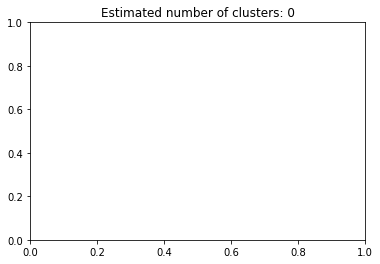

No clusters found
damping: 0.5, max_iter: 400, convergence: 30, preference: None
Estimated number of clusters: 179


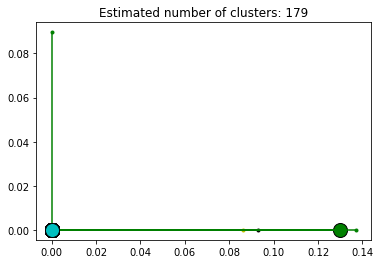

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 82:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 83:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'proposed')


Cluster 84:
('model', 'graphical', 'data', 'network', 'problem', 'method', 'gaussian', 'graph', 'node', 'lasso')


Cluster 85:
('patient', 'model', 'time', 'data', 'image', 'disease', 'risk', 'clinical', 'learning', 'mri')


Cluster 86:
('spurious', 'model', 'valley', 'local', 'recovery', 'fit', 'minimum', 'discovery', 'dimension', 'point')


Cluster 87:
('data', 'decision', 'objective', 'pomdps', 'function', 'information', 'analysis', 'solution', 'optimal', 'jl')


Cluster 88:
('classifier', 'error', 'np', 'type', 'classification', 'oracle', 'data', 'class', 'inequality', 'neyman')


Cluster 89:
('method', 'sta

('causal', 'effect', 'variable', 'data', 'model', 'method', 'algorithm', 'discovery', 'approach', 'learning')


Cluster 163:
('attack', 'based', 'detection', 'method', 'random', 'learning', 'distribution', 'image', 'robustness', 'smoothing')


Cluster 164:
('ensemble', 'model', 'relational', 'method', 'learning', 'base', 'learner', 'prediction', 'data', 'exploration')


Cluster 165:
('kernel', 'square', 'least', 'regression', 'approximation', 'gradient', 'model', 'matrix', 'regularized', 'partial')


Cluster 166:
('dictionary', 'algorithm', 'local', 'learning', 'optimal', 'representation', 'asymptotic', 'reference', 'multiscale', 'robustness')


Cluster 167:
('class', 'detection', 'data', 'set', 'classifier', 'model', 'classification', 'method', 'problem', 'algorithm')


Cluster 168:
('model', 'survival', 'scikit', 'time', 'prediction', 'explanation', 'cox', 'event', 'proposed', 'method')


Cluster 169:
('toolbox', 'library', 'python', 'learning', 'data', 'ai', 'olps', 'software', 'rei

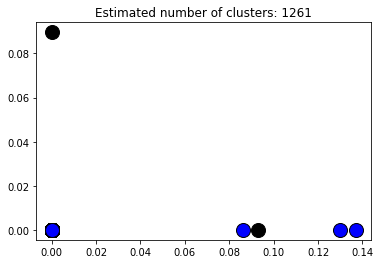

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('based', 'feature', 'toolkit', 'collaborative', 'svdfeature', 'designed', 'factorization', 'filtering', 'information', 'allows')


Cluster 110:
('cpms', 'method', 'iteration', 'multivariate', 'performance', 'problem', 'smoothing', 'accurate', 'measure', 'optimizing')


Cluster 111:
('detection', 'attack', 'anomaly', 'bound', 'learning', 'analysis', 'centroid', 'issue', 'security', 'attacker')


Cluster 112:
('relational', 'exploration', 'model', 'context', 'count', 'domain', 'learning', 'problem', 'reinforcement', 'state')


Cluster 113:
('manifold', 'regularization', 'supervised', 'example', 'learning', 'result', 'semi', 'algorithm', 'analysis', 'labeled')


Cluster 114:
('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topi

('preference', 'model', 'aggregation', 'problem', 'supervised', 'learning', 'unsupervised', 'available', 'develop', 'directly')


Cluster 220:
('network', 'prediction', 'signed', 'social', 'balance', 'global', 'local', 'clustering', 'sign', 'approach')


Cluster 221:
('model', 'disorder', 'psychiatric', 'among', 'comorbidity', 'data', 'latent', 'analysis', 'database', 'discrete')


Cluster 222:
('matrix', 'factorization', 'ha', 'hottopixx', 'model', 'input', 'linear', 'lp', 'nonnegative', 'two')


Cluster 223:
('adahedge', 'case', 'ftl', 'guarantee', 'worst', 'flipflop', 'loss', 'method', 'regret', 'constant')


Cluster 224:
('search', 'space', 'structured', 'function', 'output', 'approach', 'cost', 'prediction', 'loss', 'procedure')


Cluster 225:
('feature', 'selection', 'data', 'method', 'paradigm', 'proposed', 'approach', 'based', 'big', 'dimensional')


Cluster 226:
('boosting', 'example', 'method', 'training', 'algorithm', 'feature', 'sampling', 'adaptive', 'case', 'computer')





Cluster 330:
('agent', 'general', 'achieve', 'function', 'hypothesis', 'learning', 'reinforcement', 'bound', 'class', 'environment')


Cluster 331:
('entry', 'matrix', 'algebraic', 'completion', 'combinatorial', 'low', 'rank', 'approach', 'method', 'present')


Cluster 332:
('learning', 'reinforcement', 'safe', 'process', 'based', 'modification', 'safety', 'survey', 'analyze', 'approach')


Cluster 333:
('algorithm', 'best', 'drift', 'function', 'stationary', 'compared', 'non', 'online', 'adaptive', 'case')


Cluster 334:
('analysis', 'bayes', 'competence', 'estimate', 'expert', 'level', 'naive', 'optimal', 'problem', 'result')


Cluster 335:
('data', 'dimensional', 'high', 'svm', 'dwd', 'imbalanced', 'machine', 'classification', 'flame', 'classifier')


Cluster 336:
('learning', 'rlpy', 'function', 'reinforcement', 'value', 'allow', 'based', 'framework', 'library', 'package')


Cluster 337:
('cmr', 'regression', 'method', 'multivariate', 'calibrated', 'camel', 'convergence', 'dimensi

('variational', 'bayesian', 'inference', 'bayespy', 'model', 'python', 'support', 'user', 'advanced', 'also')


Cluster 443:
('gp', 'latent', 'non', 'variable', 'gaussian', 'learning', 'linear', 'lvm', 'method', 'process')


Cluster 444:
('density', 'algorithm', 'estimation', 'gradient', 'line', 'mean', 'shift', '1975', 'bound', 'cluster')


Cluster 445:
('learner', 'classification', 'classifier', 'core', 'data', 'bayesian', 'ever', 'kdb', 'linear', 'pas')


Cluster 446:
('class', 'classification', 'multi', 'support', 'unified', 'vector', 'view')


Cluster 447:
('addressing', 'environment', 'learning', 'non', 'repeating', 'stationarity', 'update')


Cluster 448:
('online', 'kernel', 'learning', 'large', 'algorithm', 'scale', 'approach', 'budget', 'applies', 'classification')


Cluster 449:
('kernel', 'estimator', 'mean', 'empirical', 'method', 'shrinkage', 'standard', 'used', 'algorithm', 'also')


Cluster 450:
('model', 'approximation', 'bound', 'matrix', 'algorithm', 'error', 'extens

('consistency', 'pca', 'framework', 'size', 'among', 'general', 'spike', 'analysis', 'asymptotic', 'component')


Cluster 542:
('ci', 'condition', 'cpds', 'ic', 'parameter', 'constraint', 'algorithmic', 'conditional', 'faithfulness', 'independence')


Cluster 543:
('distribution', 'regression', 'kernel', 'sampled', 'consistency', 'estimation', 'learning', 'problem', 'stage', 'al')


Cluster 544:
('nesterov', 'ode', 'scheme', 'accelerated', 'differential', 'equation', 'gradient', 'method', 'rate', 'algorithm')


Cluster 545:
('combinatorial', 'efficient', 'fpl', 'importance', 'online', 'optimization', 'performance', 'wa', 'algorithm', 'bandit')


Cluster 546:
('norm', 'box', 'spectral', 'support', 'learning', 'multitask', 'provide', 'regularizer', 'al', 'centered')


Cluster 547:
('density', 'minimum', 'approach', 'classification', 'cluster', 'clustering', 'high', 'hyperplanes', 'semi', 'supervised')


Cluster 548:
('machine', 'boltzmann', 'restricted', 'universal', 'temporal', 'depende

('java', 'jsat', 'library', '2009', 'al', 'analysis', 'et', 'learning', 'machine', 'statistical')


Cluster 641:
('model', 'class', 'minimal', 'suggest', 'using', 'algorithm', 'data', 'dimensional', 'high', 'accuracy')


Cluster 642:
('weka', 'user', 'learning', 'algorithm', 'auto', 'hyperparameter', 'new', 'optimization', 'accessible', 'among')


Cluster 643:
('pomdps', 'jl', 'decision', 'framework', 'making', 'juliapomdp', 'language', 'mdps', 'nature', 'sequential')


Cluster 644:
('time', 'construction', 'process', 'varying', 'carlo', 'generalized', 'model', 'monte', 'pitman', 'urn')


Cluster 645:
('merge', 'split', 'gibbs', 'particle', 'sampler', 'carlo', 'existing', 'method', 'mixture', 'model')


Cluster 646:
('optimization', 'problem', 'rank', 'constrained', 'technique', 'analysis', 'fa', 'certifiably', 'classical', 'convex')


Cluster 647:
('regularization', 'problem', 'aspect', 'local', 'method', 'condition', 'gradient', 'group', 'order', 'proximal')


Cluster 648:
('class', 

('matrix', 'data', 'singular', 'value', 'denoising', 'distributed', 'estimator', 'generalized', 'lead', 'low')


Cluster 745:
('information', 'dimension', 'estimator', 'model', 'approach', 'connection', 'data', 'distance', 'intrinsic', 'random')


Cluster 746:
('slab', 'spike', 'algorithm', 'ep', 'inference', 'model', 'prior', 'problem', 'proposed', 'address')


Cluster 747:
('rwf', 'flow', 'measurement', 'wf', 'wirtinger', 'algorithm', 'incremental', 'loss', 'phase', '2015')


Cluster 748:
('rimle', 'gaussian', 'improper', 'likelihood', 'robust', 'algorithm', 'breakdown', 'clustering', 'consistency', 'existence')


Cluster 749:
('model', 'linear', 'method', 'regression', 'algorithm', 'computationally', 'experiment', 'tractable', 'approximation', 'based')


Cluster 750:
('gcg', 'efficient', 'learning', 'matrix', 'algorithm', 'alternative', 'completion', 'conditional', 'convex', 'current')


Cluster 751:
('ftl', 'algorithm', 'domain', 'regret', 'convex', 'curved', 'enjoys', 'leader', 'l

('qda', 'analysis', 'da', 'discriminant', 'interaction', 'quadratic', 'bayes', 'classification', 'dimensionality', 'high')


Cluster 850:
('distribution', 'function', 'based', 'class', 'difficult', 'input', 'network', 'target', 'assumption', 'gradient')


Cluster 851:
('hypothesis', 'test', 'label', 'null', 'distribution', 'fit', 'goodness', 'paper', 'permutation', 'polynomial')


Cluster 852:
('density', 'dynamical', 'system', 'estimator', 'kernel', 'norm', 'convergence', 'estimation', 'lder', 'observation')


Cluster 853:
('task', 'method', 'provide', 'subset', 'data', 'domain', 'example', 'test', 'transfer', 'assumption')


Cluster 854:
('interaction', 'algorithm', 'data', 'high', 'linear', 'problem', 'search', 'subquadratic', 'time', 'variable')


Cluster 855:
('mtl', 'rate', 'task', 'bound', 'learning', 'norm', 'rademacher', 'also', 'complexity', 'excess')


Cluster 856:
('estimator', 'minimax', 'state', 'adaptive', 'density', 'emission', 'hidden', 'model', 'nonparametric', 'regul

Cluster 964:
('decision', 'unfairness', 'based', 'constraint', 'fair', 'framework', 'making', 'accuracy', 'algorithmic', 'boundary')


Cluster 965:
('matching', 'negative', 'non', 'score', 'approach', 'constant', 'data', 'distribution', 'estimation', 'form')


Cluster 966:
('value', 'dimension', 'model', 'conventional', 'diverging', 'early', 'linear', 'occur', 'sample', 'algorithm')


Cluster 967:
('shrinkage', 'prediction', 'regression', 'global', 'parameter', 'difficulty', 'horseshoe', 'improved', 'local', 'risk')


Cluster 968:
('estimator', 'label', 'population', 'prior', 'quantification', 'ratio', 'shift', 'target', 'assumption', 'problem')


Cluster 969:
('matching', 'data', 'empirical', 'optimal', 'optimization', 'transport', 'based', 'formulation', 'framework', 'inverse')


Cluster 970:
('set', 'system', 'dimension', 'vc', 'learning', 'machine', 'open', 'paper', 'studied', 'two')


Cluster 971:
('data', 'smart', 'labeled', 'learning', 'designed', 'help', 'open', 'platform', 're

('dynamic', 'implementation', 'library', 'selection', 'deslib', 'ensemble', 'containing', 'contrib', 'dc', 'de')


Cluster 1073:
('data', 'distance', 'functional', 'real', 'case', 'definition', 'dimensional', 'extension', 'mahalanobis', 'motivated')


Cluster 1074:
('online', 'learner', 'inverse', 'regression', 'sliced', 'dimension', 'reduction', 'step', 'doe', 'numerical')


Cluster 1075:
('sbm', 'block', 'energy', 'message', 'minimum', 'passing', 'community', 'connection', 'flow', 'general')


Cluster 1076:
('classifier', 'type', 'class', 'error', 'np', 'sample', 'parametric', 'proposed', 'algorithm', 'application')


Cluster 1077:
('factor', 'data', 'likelihood', 'marginal', 'principal', 'analysis', 'component', 'correlated', 'latent', 'pca')


Cluster 1078:
('svm', 'dual', 'kernel', 'norm', 'problem', 'case', 'data', 'general', 'machine', 'original')


Cluster 1079:
('bound', 'learning', 'dimensional', 'manifold', 'perturbation', 'classical', 'isomap', 'localization', 'low', 'probl

('mahout', 'apache', 'dataflow', 'system', 'learning', 'machine', 'distributed', 'offering', 'scalable', 'several')


Cluster 1184:
('test', 'high', 'dimensional', 'alternative', 'parameter', 'adaptive', 'aispu', 'alzheimer', 'data', 'disease')


Cluster 1185:
('algorithm', 'system', 'adaptive', 'differential', 'convergence', 'general', 'learning', 'method', 'optimization', 'condition')


Cluster 1186:
('explainability', 'toolkit', 'ai', 'explanation', 'method', 'different', '360', 'algorithm', 'also', 'data')


Cluster 1187:
('cost', 'gaussian', 'approximation', 'inference', 'computational', 'ensure', 'exact', 'model', 'process', 'quality')


Cluster 1188:
('gradient', 'learning', 'problem', 'carlo', 'monte', 'advance', 'estimation', 'machine', 'estimator', 'function')


Cluster 1189:
('matrix', 'skill', 'worker', 'component', 'correlation', 'estimation', 'observed', 'one', 'rank', 'sampling')


Cluster 1190:
('graph', 'learning', 'model', 'vertex', 'architecture', 'classification', '

damping: 0.5, max_iter: 600, convergence: 8, preference: -50
Estimated number of clusters: 1261


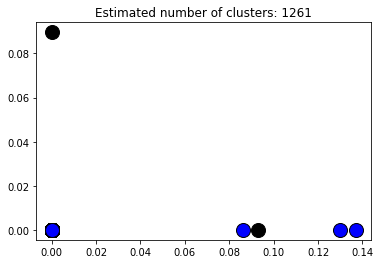

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'learning', 'lmm', 'based', 'data', 'edge', 'algorithm', 'criterion', 'network', 'skeleton')


Cluster 123:
('dimension'

('matrix', 'factorization', 'ha', 'hottopixx', 'model', 'input', 'linear', 'lp', 'nonnegative', 'two')


Cluster 223:
('adahedge', 'case', 'ftl', 'guarantee', 'worst', 'flipflop', 'loss', 'method', 'regret', 'constant')


Cluster 224:
('search', 'space', 'structured', 'function', 'output', 'approach', 'cost', 'prediction', 'loss', 'procedure')


Cluster 225:
('feature', 'selection', 'data', 'method', 'paradigm', 'proposed', 'approach', 'based', 'big', 'dimensional')


Cluster 226:
('boosting', 'example', 'method', 'training', 'algorithm', 'feature', 'sampling', 'adaptive', 'case', 'computer')


Cluster 227:
('manifold', 'manopt', 'matlab', 'optimization', 'toolbox')


Cluster 228:
('time', 'process', 'change', 'covariance', 'interval', 'locally', 'mean', 'multivariate', 'smoothness', 'varying')


Cluster 229:
('convex', 'complexity', 'problem', 'algorithm', 'descent', 'dual', 'method', 'optimization', 'strongly', 'applied')


Cluster 230:
('model', 'sparse', 'markov', 'covariance', 'in

('issue', 'preface', 'special')


Cluster 340:
('equation', 'method', 'inference', 'matrix', 'solving', 'statistical', 'operator', 'problem', 'rigorous', 'solution')


Cluster 341:
('learning', 'poem', 'risk', 'ad', 'bandit', 'counterfactual', 'crm', 'feedback', 'minimization', 'principle')


Cluster 342:
('distance', 'bound', 'matrix', 'density', 'quantum', 'rank', 'entropy', 'estimation', 'low', 'lower')


Cluster 343:
('condition', 'learning', 'fast', 'central', 'rate', 'mixability', 'statistical', 'algorithm', 'online', 'show')


Cluster 344:
('asymptotic', 'regression', 'estimate', 'function', 'normality', 'variance', 'depends', 'dimension', 'explicitly', 'functional')


Cluster 345:
('oracle', 'inequality', 'aggregation', 'bound', 'convex', 'improvement', 'obtain', 'previous', 'regression', 'result')


Cluster 346:
('random', 'graph', 'process', 'deviation', 'property', 'behavior', 'bound', 'dimension', 'exceptional', 'lower')


Cluster 347:
('information', 'anticausal', 'causal'

('online', 'kernel', 'learning', 'large', 'algorithm', 'scale', 'approach', 'budget', 'applies', 'classification')


Cluster 449:
('kernel', 'estimator', 'mean', 'empirical', 'method', 'shrinkage', 'standard', 'used', 'algorithm', 'also')


Cluster 450:
('model', 'approximation', 'bound', 'matrix', 'algorithm', 'error', 'extension', 'prototype', 'spsd', 'column')


Cluster 451:
('query', 'mechanism', 'data', 'smooth', 'continuous', 'answer', 'function', 'differential', 'differentially', 'discrete')


Cluster 452:
('subspace', 'learning', 'information', 'instance', 'partial', 'vector', 'algorithm', 'analyze', 'attribute', 'complexity')


Cluster 453:
('lasso', 'poisson', 'group', 'procedure', 'regression', 'analysis', 'approach', 'data', 'framework', 'inequality')


Cluster 454:
('causal', 'approach', 'effect', 'inference', 'observational', 'path', 'conditional', 'independency', 'one', 'study')


Cluster 455:
('order', 'partial', 'method', 'sampling', 'ai', 'algorithm', 'based', 'dag', 

('online', 'optimal', 'pca', 'regret')


Cluster 563:
('local', 'gp', 'region', 'regression', 'data', 'boundary', 'prediction', 'two', 'set', 'gaussian')


Cluster 564:
('bandicoot', 'mobile', 'phone', 'extract', 'feature', 'metadata', 'python', 'toolbox', '1442', 'analyze')


Cluster 565:
('output', 'kernel', 'regression', 'input', 'structured', 'supervised', 'model', 'problem', 'space', 'approach')


Cluster 566:
('algorithm', 'er', 'matrix', 'spielman', 'spud', 'wang', 'wright', 'based', 'column', 'complexity')


Cluster 567:
('network', 'performance', 'echo', 'linear', 'mse', 'neural', 'setting', 'state', 'aforementioned', 'article')


Cluster 568:
('vertex', 'nomination', 'ml', 'scheme', 'based', 'graph', 'likelihood', 'prove', 'approach', 'bayes')


Cluster 569:
('kernel', 'distribution', 'characteristic', 'divisible', 'infinitely', 'mean', 'ii', 'probability', 'case', 'class')


Cluster 570:
('cut', 'graph', 'sample', 'based', 'consistency', 'cheeger', 'cloud', 'clustering', 'fu

('label', 'type', 'network', 'inference', 'al', 'consider', 'edgeexplain', 'et', 'graph', 'ha')


Cluster 674:
('stage', 'community', 'optimal', 'proportion', 'achieves', 'block', 'detection', 'model', 'procedure', 'statistical')


Cluster 675:
('distribution', 'error', 'count', 'general', 'graph', 'independent', 'network', 'result', 'subgraph', 'case')


Cluster 676:
('lda', 'sample', 'cgs', 'collapsed', 'parameter', 'approach', 'estimator', 'gibbs', 'computational', 'condition')


Cluster 677:
('tensor', 'completability', 'cp', 'rank', 'sampling', 'completion', 'entry', 'finite', 'number', 'polynomial')


Cluster 678:
('learning', 'approach', 'example', 'rule', 'class', 'data', 'description', 'exception', 'expression', 'general')


Cluster 679:
('search', 'learning', 'partial', 'policy', 'tree', 'action', 'algorithm', 'branching', 'contribution', 'making')


Cluster 680:
('kernel', 'data', 'proposed', 'rank', 'approximation', 'complexity', 'hierarchical', 'learning', 'low', 'method')

('method', 'complexity', 'type', 'minimization', 'block', 'bound', 'cbcd', 'convex', 'strongly', 'coordinate')


Cluster 781:
('optimization', 'hyperparameter', 'learning', 'problem', 'uralg', 'algorithm', 'approach', 'bandit', 'based', 'bayesian')


Cluster 782:
('submatrix', 'algorithm', 'problem', 'localization', 'mean', 'message', 'noise', 'passing', 'community', 'elevated')


Cluster 783:
('bit', 'network', 'neural', 'quantized', 'accuracy', 'activation', 'qnns', 'weight', 'gradient', 'operation')


Cluster 784:
('community', 'network', 'method', 'weighted', 'detection', 'node', 'null', 'algorithm', 'background', 'ccme')


Cluster 785:
('data', 'method', 'persistence', 'diagram', 'kernel', 'tda', 'topological', 'weight', 'accurate', 'advantage')


Cluster 786:
('pycobra', 'learning', 'python', 'ensemble', 'visualisation', 'algorithm', 'available', 'documentation', 'http', 'library')


Cluster 787:
('kernel', 'kelp', 'java', 'algorithm', 'learning', 'based', 'easy', 'enables', 'ext

('learning', 'multi', 'output', 'scikit', 'framework', 'multiflow', 'stream', 'data', 'including', 'art')


Cluster 886:
('projection', 'dimension', 'dimensional', 'distance', 'doe', 'euclidean', 'exist', 'image', 'johnson', 'lindenstrauss')


Cluster 887:
('method', 'distributed', 'communication', 'cost', 'function', 'al', 'algorithm', 'approach', 'approximate', 'based')


Cluster 888:
('information', 'side', 'learning', 'matrix', 'model', 'low', 'rank', 'corrupted', 'missing', 'observation')


Cluster 889:
('data', 'analysis', 'performance', 'proposed', 'article', 'behavior', 'large', 'learning', 'limit', 'parametrization')


Cluster 890:
('low', 'matrix', 'rank', 'algorithm', 'manifold', 'optimization', 'pca', 'robust', 'underlying', 'based')


Cluster 891:
('asynchronous', 'algorithm', 'parallel', 'optimization', 'theoretical', 'analysis', 'assumption', 'core', 'incremental', 'architecture')


Cluster 892:
('manifold', 'convex', 'nomad', 'sdp', 'datasets', 'solution', 'approach', '

('change', 'point', 'regression', 'estimate', 'model', 'parameter', 'rate', 'size', 'computational', 'dimensional')


Cluster 999:
('batch', 'training', 'size', 'data', 'network', 'neural', 'model', 'algorithm', 'available', 'effect')


Cluster 1000:
('estimator', 'distributed', 'svm', 'linear', 'inference', 'machine', 'data', 'mdl', 'asymptotic', 'efficiency')


Cluster 1001:
('local', 'recovery', 'minimum', 'spurious', 'point', 'rip', 'constant', 'exact', 'guarantee', 'inexistence')


Cluster 1002:
('attribute', 'latent', 'pattern', 'model', 'slam', 'dimensional', 'high', 'learning', 'selection', 'structured')


Cluster 1003:
('graph', 'spectral', 'approximation', 'reduction', 'restricted', 'cut', 'guarantee', 'one', 'problem', 'without')


Cluster 1004:
('datasets', 'method', 'approach', 'gaussian', 'gp', 'large', 'likelihood', 'model', 'using', 'classification')


Cluster 1005:
('feature', 'hot', 'linear', 'one', 'penalization', 'continuous', 'model', 'binarsity', 'encoded', 'encod

('package', 'python', 'pyts', 'classification', 'series', 'time', 'algorithm', 'api', 'bsd', 'clause')


Cluster 1109:
('graph', 'game', 'hypernode', 'problem', 'multiplayer', 'set', 'skill', 'relation', 'algorithm', 'positive')


Cluster 1110:
('ensemble', 'relational', 'learning', 'data', 'framework', 'inference', 'analysis', 'approach', 'collective', 'error')


Cluster 1111:
('data', 'driven', 'interaction', 'penalization', 'result', 'analysis', 'based', 'hawkes', 'low', 'martingale')


Cluster 1112:
('model', 'afdag', 'network', 'aci', 'additive', 'based', 'causal', 'conditional', 'consistency', 'data')


Cluster 1113:
('policy', 'gradient', 'action', 'epg', 'critic', 'deterministic', 'expected', 'gaussian', 'derive', 'exponential')


Cluster 1114:
('cluster', 'graph', 'model', 'based', 'graphical', 'latent', 'inference', 'variable', 'data', 'feature')


Cluster 1115:
('graph', 'kernel', 'grakel', 'library', 'learn', 'many', 'problem', 'python', 'scikit', 'accurately')


Cluster 11

('lag', 'approach', 'order', 'var', 'component', 'forecasting', 'hlag', 'lasso', 'selection', 'structure')


Cluster 1221:
('convex', 'approach', 'non', 'class', 'estimation', 'estimator', 'label', 'problem', 'setting', 'conditional')


Cluster 1222:
('ridge', 'penalty', 'high', 'dimensional', 'model', 'negative', 'optimal', 'real', 'regularization', 'case')


Cluster 1223:
('commenting', 'behavior', 'youtube', 'constraint', 'group', 'user', 'bayesian', 'inattentive', 'inverse', 'learning')


Cluster 1224:
('forest', 'random', 'model', 'regression', 'success', 'based', 'empirical', 'explanation', 'forward', 'procedure')


Cluster 1225:
('operator', 'method', 'system', 'nonlinear', 'arnoldi', 'data', 'dynamical', 'subspace', 'using', 'develop')


Cluster 1226:
('estimator', 'outcome', 'correlated', 'data', 'dimensional', 'distributed', 'high', 'learning', 'supervised', 'block')


Cluster 1227:
('dnns', 'intrinsic', 'data', 'dimensional', 'dimensionality', 'low', 'covariates', 'error', '

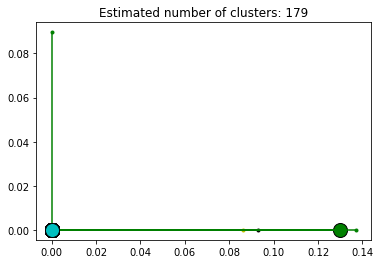

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 81:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 82:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 83:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'proposed')


Cluster 84:
('model', 'graphical', 'data', 'network', 'problem', 'method', 'gaussian', 'graph', 'node', 'lasso')


Cluster 85:
('patient', 'model', 'time', 'data', 'image', 'disease', 'risk', 'clinical', 'learning', 'mri')


Cluster 86:
('spurious', 'model', 'valley', 'local', 'recovery', 'fit', 'minimum', 'discovery', 'dimension', 'point')


Cluster 87:
('data', 'decision', 'objective', 'pomdps', 'function', 'information', 'analysis', 'solution', 'optimal', 'jl')


Cluster 88:
(

('interaction', 'high', 'data', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'problem', 'matrix')


Cluster 159:
('graph', 'algorithm', 'problem', 'learning', 'random', 'model', 'data', 'spectral', 'framework', 'time')


Cluster 160:
('data', 'supervised', 'graph', 'unlabeled', 'semi', 'consistency', 'learning', 'cut', 'based', 'harmonic')


Cluster 161:
('dual', 'method', 'convex', 'problem', 'primal', 'complexity', 'algorithm', 'iteration', 'solution', 'optimization')


Cluster 162:
('causal', 'effect', 'variable', 'data', 'model', 'method', 'algorithm', 'discovery', 'approach', 'learning')


Cluster 163:
('attack', 'based', 'detection', 'method', 'random', 'learning', 'distribution', 'image', 'robustness', 'smoothing')


Cluster 164:
('ensemble', 'model', 'relational', 'method', 'learning', 'base', 'learner', 'prediction', 'data', 'exploration')


Cluster 165:
('kernel', 'square', 'least', 'regression', 'approximation', 'gradient', 'model', 'matrix', 'regularized',

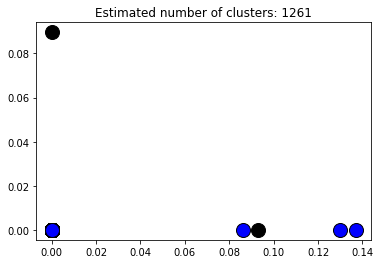

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('function', 'method', 'reward', 'arbitrary', 'decision', 'detailed', 'fitted', 'iteration', 'linear', 'number')


Cluster 100:
('tensor', 'manifold', 'data', 'gesture', 'geometry', 'space', 'using', 'method', 'product', 'action')


Cluster 101:
('linear', 'svr', 'kernel', 'method', 'support', 'svc', 'training', 'vector', 'regression', 'accuracy')


Cluster 102:
('matrix', 'factorization', 'nmf', 'data', 'nonnegative', 'sparse', 'technique', 'based', 'ha', 'posed')


Cluster 103:
('algorithm', 'model', 'procedure', 'variable', '2010', 'al', 'causal', 'condition', 'et', 'full')


Cluster 104:
('matrix', 'approximation', 'leverage', 'algorithm', 'score', 'statistical', 'extension', 'analysis', 'application', 'coherence')


Cluster 105:
('prior', 'bound', 'bayes', 'pac', 'data', 'svm', 'algorithm', 'generalization', 'separate', 'set')


Cluster 106:
('learning', 'machine', 'framework', 'computer', 'vision', 'graphical', 'research', 'algorithm', 'application', 'component')


Cluster 107:
(

Cluster 206:
('interaction', 'variable', 'computational', 'high', 'order', 'approach', 'class', 'data', 'informative', 'interest')


Cluster 207:
('anesthesia', 'patient', 'rl', 'control', 'human', 'specific', 'closed', 'loop', 'study', 'volunteer')


Cluster 208:
('algorithm', 'model', 'hem', 'variational', 'data', 'hmm', 'cluster', 'group', 'hidden', 'hierarchical')


Cluster 209:
('subspace', 'robust', 'convex', 'data', 'inverse', 'pca', 'recovery', 'algorithm', 'bottom', 'covariance')


Cluster 210:
('comparison', 'difference', 'evaluation', 'policy', 'survey', 'temporal')


Cluster 211:
('active', 'application', 'approximation', 'learning', 'regret', 'relative', 'smooth', 'using')


Cluster 212:
('analysis', 'nonlinear', 'source', 'feature', 'slow', 'algorithm', 'blind', 'extension', 'independent', 'mixture')


Cluster 213:
('distribution', 'natural', 'complexity', 'evolution', 'family', 'ne', 'paper', 'performance', 'search', 'strategy')


Cluster 214:
('dependency', 'high', 'ord

Cluster 308:
('ad', 'factor', 'local', 'map', 'algorithm', 'alternating', 'decomposition', 'direction', 'dual', 'ha')


Cluster 309:
('currennt', 'lstm', 'rnns', 'implementation', 'available', 'bidirectional', 'cuda', 'deep', 'memory', 'network')


Cluster 310:
('flare', 'estimation', 'lasso', 'matrix', 'method', 'package', 'precision', 'dimensional', 'high', 'regression')


Cluster 311:
('optimum', 'statistical', 'function', 'model', 'penalty', 'composite', 'error', 'estimator', 'linear', 'local')


Cluster 312:
('hkl', 'learning', 'kernel', 'formulation', 'generalization', 'multi', 'proposed', 'rule', 'set', 'ensemble')


Cluster 313:
('discrete', 'model', 'boltzmann', 'machine', 'restricted', 'hidden', 'product', 'simplices', 'state', 'variable')


Cluster 314:
('code', 'gpu', 'methodology', 'compilation', 'gp', 'individual', 'machine', 'also', 'assembly', 'generates')


Cluster 315:
('learning', 'new', 'active', 'complexity', 'compression', 'label', 'size', 'space', 'version', 'bas

('feature', 'rate', 'bound', 'dimension', 'estimator', 'matching', 'minimax', 'noise', 'problem', 'case')


Cluster 409:
('algorithm', 'step', 'data', 'sequence', 'size', 'dynamic', 'gradient', 'langevin', 'proposal', 'set')


Cluster 410:
('task', 'intermediate', 'learning', 'network', 'neural', 'hypothesis', 'optimization', 'training', 'two', 'using')


Cluster 411:
('string', 'similarity', 'harry', 'data', 'tool', 'analysis', 'common', 'designed', 'distance', 'kernel')


Cluster 412:
('gibbs', 'herded', 'model', 'algorithm', 'connected', 'convergence', 'graphical', 'probabilistic', 'called', 'crfs')


Cluster 413:
('part', 'level', 'compositional', 'model', 'object', 'complexity', 'executive', 'inference', 'representation', 'sharing')


Cluster 414:
('subspace', 'clustering', 'ssc', 'data', 'noise', 'noisy', 'sparse', 'added', 'adversarial', 'algorithm')


Cluster 415:
('go', 'reward', 'variance', 'algorithm', 'currently', 'domain', 'function', 'known', 'learning', 'mdps')


Cluster

('factor', 'dantzig', 'ha', 'logarithmic', 'method', 'sample', 'selector', 'size', 'accuracy', 'constrained')


Cluster 519:
('optimization', 'bound', 'lower', 'algorithm', 'convex', 'dimensionality', 'framework', 'natural', 'novel', 'polynomial')


Cluster 520:
('control', 'approximate', 'bayesian', 'exploration', 'regression', 'approach', 'dual', 'framework', 'intractable', 'learning')


Cluster 521:
('instance', 'learning', 'bag', 'new', 'theoretical', 'function', 'algorithm', 'correctly', 'framework', 'learn')


Cluster 522:
('convex', 'algorithm', 'approachability', 'set', 'vector', 'blackwell', 'oco', 'online', 'payoff', 'along')


Cluster 523:
('covariance', 'matrix', 'inverse', 'estimator', 'proposed', 'method', 'sparse', 'conditioned', 'estimation', 'well')


Cluster 524:
('string', 'data', 'process', 'gaussian', 'gp', 'gps', 'input', 'approach', 'bayesian', 'distributed')


Cluster 525:
('pico', 'review', 'supervision', 'article', 'clinical', 'distant', 'element', 'evidence',

('pi', 'vector', 'data', 'machine', 'pd', 'persistence', 'representation', 'tool', 'discriminatory', 'equation')


Cluster 629:
('clustering', 'spectral', 'algorithm', 'based', 'local', 'pca', 'method', 'neighborhood', 'principal', 'able')


Cluster 630:
('carlo', 'monte', 'size', 'batch', 'gradient', 'algorithm', 'derive', 'model', 'proximal', 'sparse')


Cluster 631:
('privacy', 'data', 'differential', 'posterior', 'provide', 'bound', 'metric', 'sampling', 'set', 'access')


Cluster 632:
('topic', 'model', 'refinery', 'learning', 'open', 'platform', 'source', 'web', 'adapt', 'algorithm')


Cluster 633:
('pattern', 'temporal', 'number', 'conceptors', 'large', 'network', 'neural', 'stored', 'account', 'addressed')


Cluster 634:
('model', 'algorithm', 'classification', 'formulation', 'svm', 'various', 'given', 'method', 'unified', 'accelerated')


Cluster 635:
('learn', 'imbalanced', 'scikit', 'learning', 'method', 'sampling', 'toolbox', 'contrib', 'documentation', 'machine')


Cluster

('slab', 'spike', 'algorithm', 'ep', 'inference', 'model', 'prior', 'problem', 'proposed', 'address')


Cluster 747:
('rwf', 'flow', 'measurement', 'wf', 'wirtinger', 'algorithm', 'incremental', 'loss', 'phase', '2015')


Cluster 748:
('rimle', 'gaussian', 'improper', 'likelihood', 'robust', 'algorithm', 'breakdown', 'clustering', 'consistency', 'existence')


Cluster 749:
('model', 'linear', 'method', 'regression', 'algorithm', 'computationally', 'experiment', 'tractable', 'approximation', 'based')


Cluster 750:
('gcg', 'efficient', 'learning', 'matrix', 'algorithm', 'alternative', 'completion', 'conditional', 'convex', 'current')


Cluster 751:
('ftl', 'algorithm', 'domain', 'regret', 'convex', 'curved', 'enjoys', 'leader', 'loss', 'set')


Cluster 752:
('matrix', 'outlier', 'algorithm', 'completion', 'criterion', 'defined', 'entry', 'noisy', 'optimization', 'begin')


Cluster 753:
('graph', 'distribution', 'model', 'given', 'independence', 'probability', 'case', 'condition', 'faith

('kernel', 'measure', 'distribution', 'embeddings', 'probability', 'characteristic', 'distance', 'mean', 'three', 'universal')


Cluster 862:
('absent', 'level', 'problem', 'categorical', 'decision', 'forest', 'random', 'tree', 'using', 'based')


Cluster 863:
('irls', 'linear', 'low', 'matrix', 'recovery', 'algorithm', 'hm', 'iteratively', 'least', 'observation')


Cluster 864:
('policy', 'scheme', 'td', 'trace', 'learning', 'process', 'based', 'bellman', 'equation', 'generalized')


Cluster 865:
('information', 'representation', 'invariance', 'learned', 'loss', 'network', 'term', 'training', 'using', 'weight')


Cluster 866:
('formula', 'approximate', 'cross', 'validation', '2017', 'data', 'logistic', 'multinomial', 'obuchi', 'regression')


Cluster 867:
('profile', 'action', 'bandit', 'setting', 'vector', 'case', 'data', 'feature', 'given', 'mapping')


Cluster 868:
('deep', 'process', 'gaussian', 'ergodicity', 'depth', 'resulting', 'used', 'class', 'construction', 'effective')


Cl

('shrinkage', 'prediction', 'regression', 'global', 'parameter', 'difficulty', 'horseshoe', 'improved', 'local', 'risk')


Cluster 968:
('estimator', 'label', 'population', 'prior', 'quantification', 'ratio', 'shift', 'target', 'assumption', 'problem')


Cluster 969:
('matching', 'data', 'empirical', 'optimal', 'optimization', 'transport', 'based', 'formulation', 'framework', 'inverse')


Cluster 970:
('set', 'system', 'dimension', 'vc', 'learning', 'machine', 'open', 'paper', 'studied', 'two')


Cluster 971:
('data', 'smart', 'labeled', 'learning', 'designed', 'help', 'open', 'platform', 'research', 'set')


Cluster 972:
('algorithm', 'hedge', 'stochastic', 'adaptive', 'case', 'learning', 'rate', 'anytime', 'easier', 'one')


Cluster 973:
('game', 'gradient', 'component', 'differentiable', 'guarantee', 'new', 'adversarial', 'algorithm', 'conservation', 'descent')


Cluster 974:
('partition', 'data', 'space', 'spatial', 'tree', 'model', 'partitioning', 'problem', 'proposed', 'random')


('interaction', 'detecting', 'estimator', 'hessian', 'matrix', 'principal', 'dimensional', 'high', 'method', 'problem')


Cluster 1084:
('algorithm', 'regularized', 'result', 'space', 'convergence', 'hilbert', 'optimal', 'projection', 'attainable', 'case')


Cluster 1085:
('method', 'policy', 'derivative', 'free', 'linear', 'optimization', 'setting', 'system', 'applied', 'class')


Cluster 1086:
('graph', 'learning', 'structured', 'data', 'algorithm', 'constraint', 'framework', 'problem', 'spectral', 'based')


Cluster 1087:
('gluoncv', 'gluonnlp', 'deep', 'language', 'learning', 'apache', 'computer', 'model', 'mxnet', 'natural')


Cluster 1088:
('screening', 'correlation', 'data', 'feature', 'aggregated', 'component', 'distributed', 'estimate', 'framework', 'estimator')


Cluster 1089:
('model', 'testing', 'identity', 'hardness', 'result', 'coloring', 'constraint', 'ising', 'parameter', 'polynomial')


Cluster 1090:
('estimator', 'matrix', 'class', 'data', 'approach', 'dimensional', '

('automatic', 'model', 'sparsity', 'art', 'bisn', 'dimension', 'gradient', 'graphical', 'method', 'sparse')


Cluster 1181:
('algorithm', 'coordinate', 'submodular', 'approximation', 'function', 'continuous', 'maximization', 'monotone', 'problem', 'wise')


Cluster 1182:
('data', 'learning', 'distributed', 'unlabeled', 'dmee', 'node', 'rate', 'supervised', 'algorithm', 'error')


Cluster 1183:
('mahout', 'apache', 'dataflow', 'system', 'learning', 'machine', 'distributed', 'offering', 'scalable', 'several')


Cluster 1184:
('test', 'high', 'dimensional', 'alternative', 'parameter', 'adaptive', 'aispu', 'alzheimer', 'data', 'disease')


Cluster 1185:
('algorithm', 'system', 'adaptive', 'differential', 'convergence', 'general', 'learning', 'method', 'optimization', 'condition')


Cluster 1186:
('explainability', 'toolkit', 'ai', 'explanation', 'method', 'different', '360', 'algorithm', 'also', 'data')


Cluster 1187:
('cost', 'gaussian', 'approximation', 'inference', 'computational', 'en

Estimated number of clusters: 0


C:\Users\Donat\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


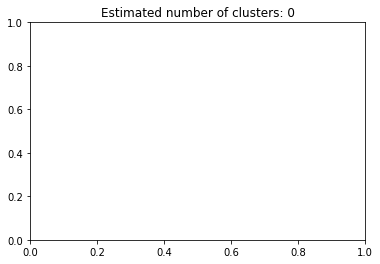

No clusters found
damping: 0.5, max_iter: 600, convergence: 15, preference: None
Estimated number of clusters: 179


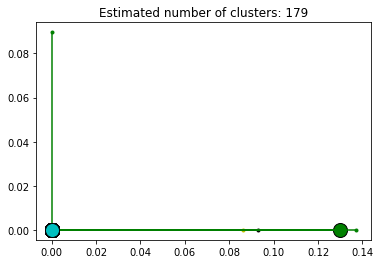

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 77:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 78:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')


Cluster 79:
('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluster 80:
('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 81:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 82:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 83:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'pro

('uncertainty', 'market', 'prediction', 'set', 'approach', 'function', 'statistical', 'artificial', 'quantifying', 'loss')


Cluster 147:
('function', 'communication', 'algorithm', 'optimization', 'network', 'decentralized', 'distributed', 'model', 'problem', 'learning')


Cluster 148:
('change', 'point', 'model', 'algorithm', 'system', 'data', 'graphical', 'penalty', 'surface', 'method')


Cluster 149:
('gabp', 'algorithm', 'convergence', 'gaussian', 'definite', 'positive', 'multivariate', 'node', 'extension', 'mg')


Cluster 150:
('function', 'data', 'coherence', 'ica', 'sparse', 'coding', 'hinge', 'overcomplete', 'algorithm', 'learning')


Cluster 151:
('convergence', 'stochastic', 'sgd', 'algorithm', 'gradient', 'function', 'method', 'problem', 'learning', 'rate')


Cluster 152:
('state', 'reservoir', 'system', 'input', 'memory', 'space', 'time', 'fading', 'filter', 'feature')


Cluster 153:
('image', 'convolutional', 'invariance', 'network', 'information', 'representation', 'model

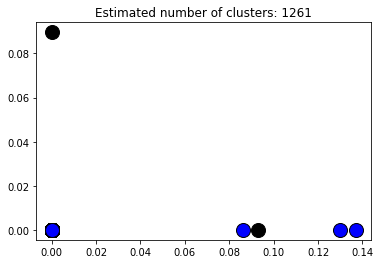

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('matrix', 'approximation', 'leverage', 'algorithm', 'score', 'statistical', 'extension', 'analysis', 'application', 'coherence')


Cluster 105:
('prior', 'bound', 'bayes', 'pac', 'data', 'svm', 'algorithm', 'generalization', 'separate', 'set')


Cluster 106:
('learning', 'machine', 'framework', 'computer', 'vision', 'graphical', 'research', 'algorithm', 'application', 'component')


Cluster 107:
('convex', 'non', 'algorithm', 'optimization', 'problem', 'risk', 'learning', 'objective', 'regularized', 'function')


Cluster 108:
('symbolic', 'dynamical', 'mmsr', 'system', 'expression', 'hybrid', 'learning', 'mathematical', 'modal', 'multi')


Cluster 109:
('based', 'feature', 'toolkit', 'collaborative', 'svdfeature', 'designed', 'factorization', 'filtering', 'information', 'allows')


Cluster 110:
('cpms', 'method', 'iteration', 'multivariate', 'performance', 'problem', 'smoothing', 'accurate', 'measure', 'optimizing')


Cluster 111:
('detection', 'attack', 'anomaly', 'bound', 'learning'

('analysis', 'nonlinear', 'source', 'feature', 'slow', 'algorithm', 'blind', 'extension', 'independent', 'mixture')


Cluster 213:
('distribution', 'natural', 'complexity', 'evolution', 'family', 'ne', 'paper', 'performance', 'search', 'strategy')


Cluster 214:
('dependency', 'high', 'order', 'label', 'algorithm', 'conditional', 'field', 'random', 'sequence', 'efficient')


Cluster 215:
('algorithm', 'data', 'point', 'vertex', 'convex', 'find', 'hull', 'noise', 'separability', 'contain')


Cluster 216:
('covariates', 'dirichlet', 'predictive', 'process', 'computation', 'density', 'mixture', 'model', 'number', 'performance')


Cluster 217:
('margin', 'max', 'topic', 'gibbs', 'model', 'loss', 'supervised', 'approach', 'classification', 'data')


Cluster 218:
('system', 'learning', 'linear', 'component', 'data', 'efficient', 'feature', 'number', 'reported', 'set')


Cluster 219:
('preference', 'model', 'aggregation', 'problem', 'supervised', 'learning', 'unsupervised', 'available', 'deve

('agent', 'general', 'achieve', 'function', 'hypothesis', 'learning', 'reinforcement', 'bound', 'class', 'environment')


Cluster 331:
('entry', 'matrix', 'algebraic', 'completion', 'combinatorial', 'low', 'rank', 'approach', 'method', 'present')


Cluster 332:
('learning', 'reinforcement', 'safe', 'process', 'based', 'modification', 'safety', 'survey', 'analyze', 'approach')


Cluster 333:
('algorithm', 'best', 'drift', 'function', 'stationary', 'compared', 'non', 'online', 'adaptive', 'case')


Cluster 334:
('analysis', 'bayes', 'competence', 'estimate', 'expert', 'level', 'naive', 'optimal', 'problem', 'result')


Cluster 335:
('data', 'dimensional', 'high', 'svm', 'dwd', 'imbalanced', 'machine', 'classification', 'flame', 'classifier')


Cluster 336:
('learning', 'rlpy', 'function', 'reinforcement', 'value', 'allow', 'based', 'framework', 'library', 'package')


Cluster 337:
('cmr', 'regression', 'method', 'multivariate', 'calibrated', 'camel', 'convergence', 'dimensional', 'high',

('learner', 'classification', 'classifier', 'core', 'data', 'bayesian', 'ever', 'kdb', 'linear', 'pas')


Cluster 446:
('class', 'classification', 'multi', 'support', 'unified', 'vector', 'view')


Cluster 447:
('addressing', 'environment', 'learning', 'non', 'repeating', 'stationarity', 'update')


Cluster 448:
('online', 'kernel', 'learning', 'large', 'algorithm', 'scale', 'approach', 'budget', 'applies', 'classification')


Cluster 449:
('kernel', 'estimator', 'mean', 'empirical', 'method', 'shrinkage', 'standard', 'used', 'algorithm', 'also')


Cluster 450:
('model', 'approximation', 'bound', 'matrix', 'algorithm', 'error', 'extension', 'prototype', 'spsd', 'column')


Cluster 451:
('query', 'mechanism', 'data', 'smooth', 'continuous', 'answer', 'function', 'differential', 'differentially', 'discrete')


Cluster 452:
('subspace', 'learning', 'information', 'instance', 'partial', 'vector', 'algorithm', 'analyze', 'attribute', 'complexity')


Cluster 453:
('lasso', 'poisson', 'group'

('network', 'decomposition', 'multiplication', 'rule', 'rank', 'conservative', 'discover', 'example', 'input', 'learning')


Cluster 512:
('bound', 'method', 'sampling', 'error', 'result', 'algorithm', 'empirical', 'learning', 'machine', 'matrix')


Cluster 513:
('algorithm', 'network', 'markov', 'mbr', 'bayesian', 'blanket', 'convergence', 'learning', 'probability', 'structure')


Cluster 514:
('efficient', 'exploration', 'convex', 'set', 'spanner', 'algorithm', 'bandit', 'design', 'experiment', 'general')


Cluster 515:
('carlo', 'discrepancy', 'kernel', 'monte', 'feature', 'map', 'qmc', 'sequence', 'approximation', 'based')


Cluster 516:
('model', 'output', 'data', 'dynamical', 'multi', 'system', 'dependent', 'variational', 'gaussian', 'gp')


Cluster 517:
('noise', 'model', 'signal', 'latent', 'regression', 'multiple', 'assumption', 'data', 'dimensional', 'factor')


Cluster 518:
('factor', 'dantzig', 'ha', 'logarithmic', 'method', 'sample', 'selector', 'size', 'accuracy', 'constr

('pi', 'vector', 'data', 'machine', 'pd', 'persistence', 'representation', 'tool', 'discriminatory', 'equation')


Cluster 629:
('clustering', 'spectral', 'algorithm', 'based', 'local', 'pca', 'method', 'neighborhood', 'principal', 'able')


Cluster 630:
('carlo', 'monte', 'size', 'batch', 'gradient', 'algorithm', 'derive', 'model', 'proximal', 'sparse')


Cluster 631:
('privacy', 'data', 'differential', 'posterior', 'provide', 'bound', 'metric', 'sampling', 'set', 'access')


Cluster 632:
('topic', 'model', 'refinery', 'learning', 'open', 'platform', 'source', 'web', 'adapt', 'algorithm')


Cluster 633:
('pattern', 'temporal', 'number', 'conceptors', 'large', 'network', 'neural', 'stored', 'account', 'addressed')


Cluster 634:
('model', 'algorithm', 'classification', 'formulation', 'svm', 'various', 'given', 'method', 'unified', 'accelerated')


Cluster 635:
('learn', 'imbalanced', 'scikit', 'learning', 'method', 'sampling', 'toolbox', 'contrib', 'documentation', 'machine')


Cluster

('tree', 'decision', 'dimension', 'ultrahigh', 'feature', 'label', 'dt', 'linear', 'model', 'sbt')


Cluster 694:
('kernel', 'structure', 'gaussian', 'lstm', 'process', 'recurrent', 'application', 'function', 'gp', 'model')


Cluster 695:
('cnn', 'convolutional', 'csc', 'network', 'theoretical', 'forward', 'model', 'pas', 'sparse', 'alternative')


Cluster 696:
('method', 'dual', 'primal', 'variable', 'problem', 'spdc', 'better', 'convex', 'coordinate', 'empirical')


Cluster 697:
('method', 'distance', 'weighted', 'angle', 'based', 'classification', 'machine', 'support', 'svm', 'vector')


Cluster 698:
('kernel', 'minimax', 'class', 'density', 'estimation', 'estimator', 'mean', 'measure', 'paper', 'rate')


Cluster 699:
('clustering', 'random', 'model', 'cluster', 'ensemble', 'impact', 'number', 'similarity', 'size', 'assumption')


Cluster 700:
('algorithm', 'cost', 'clustering', 'hierarchical', 'approximation', 'problem', '2016', 'also', 'constant', 'cut')


Cluster 701:
('decision'

('condition', 'error', 'classification', 'lipschitz', 'nearest', 'neighbor', 'probability', 'concept', 'convergence', 'excess')


Cluster 816:
('corrupted', 'label', 'learning', 'theory')


Cluster 817:
('algorithm', 'stream', 'pool', 'setting', 'based', 'element', 'select', 'interactive', 'precognitive', 'bound')


Cluster 818:
('distributed', 'framework', 'convex', 'efficient', 'general', 'non', 'cocoa', 'communication', 'datasets', 'ha')


Cluster 819:
('process', 'bound', 'empirical', 'probability', 'series', 'tail', 'time', 'class', 'condition', 'dependence')


Cluster 820:
('cluster', 'likelihood', 'response', 'variable', 'algorithm', 'penalized', 'regression', 'binomial', 'method', 'penalty')


Cluster 821:
('kernel', 'distance', 'hsic', 'independence', 'mmd', 'product', 'tensor', 'characteristic', 'statistic', 'also')


Cluster 822:
('list', 'rule', 'optimal', 'data', 'categorical', 'interpretable', 'produce', 'risk', 'according', 'accurate')


Cluster 823:
('singularity', 'net

('online', 'rfd', 'algorithm', 'learning', 'direction', 'fd', 'frequent', 'application', 'matrix', 'newton')


Cluster 937:
('learning', 'bkrr', 'kernel', 'regression', 'ridge', 'algorithm', 'bias', 'boosted', 'boosting', 'iteration')


Cluster 938:
('spectral', 'clustering', 'general', 'algorithm', 'model', 'adjacency', 'community', 'detection', 'matrix', 'regularization')


Cluster 939:
('treatment', 'rule', 'individualized', 'data', 'estimator', 'proposed', 'estimating', 'observational', 'optimal', 'using')


Cluster 940:
('algorithm', 'bo', 'function', 'hyperparameters', 'optimization', 'optimum', 'several', 'based', 'bayesian', 'converge')


Cluster 941:
('method', 'model', 'prediction', 'probabilistic', 'bayesian', 'correlation', 'ensemble', 'mixture', 'multivariate', 'normal')


Cluster 942:
('problem', 'arm', 'reward', 'stochastic', 'deceptive', 'spl', 'environment', 'feedback', 'location', 'optimal')


Cluster 943:
('hyperparameters', 'algorithm', 'tuning', 'default', 'learnin

('ensemble', 'algorithm', 'classifier', 'sample', 'summa', 'unsupervised', 'aggregation', 'base', 'data', 'estimate')


Cluster 1049:
('canonical', 'sample', 'correlation', 'accuracy', 'achieve', 'algorithm', 'analysis', 'complexity', 'covariance', 'data')


Cluster 1050:
('model', 'gaussian', 'process', 'matrix', 'mixture', 'computational', 'embarrassingly', 'expert', 'inference', 'inversion')


Cluster 1051:
('density', 'cluster', 'estimation', 'rate', 'dbscan', 'optimal', 'tree', 'algorithm', 'minimax', 'al')


Cluster 1052:
('group', 'model', 'covariance', 'subspace', 'dimensional', 'eigenvectors', 'method', 'use', 'across', 'algorithm')


Cluster 1053:
('non', 'constraint', 'convex', 'differentiable', 'optimization', 'goal', 'problem', 'solution', 'churn', 'constrained')


Cluster 1054:
('model', 'additive', 'algorithm', 'analysis', 'automatic', 'data', 'degree', 'empirical', 'fast', 'function')


Cluster 1055:
('data', 'ica', 'overcomplete', 'coherence', 'linear', 'algorithm', 'c

('cornac', 'multimodal', 'recommender', 'auxiliary', 'data', 'framework', 'item', 'model', 'python', 'system')


Cluster 1153:
('algorithm', 'learning', 'pydml', 'classifier', 'distance', 'library', 'metric', 'nearest', 'provides', 'also')


Cluster 1154:
('covariance', 'estimate', 'rank', 'loss', 'one', 'portfolio', 'risk', 'asset', 'control', 'estimation')


Cluster 1155:
('space', 'framework', 'output', 'prediction', 'structured', 'algorithmic', 'general', 'implicit', 'loss', 'problem')


Cluster 1156:
('causal', 'jci', 'data', 'discovery', 'algorithm', 'different', 'implementation', 'approach', 'case', 'certain')


Cluster 1157:
('model', 'latent', 'feature', 'data', 'datasets', 'heterogeneous', 'allocation', 'analysis', 'attribute', 'general')


Cluster 1158:
('gabp', 'algorithm', 'convergence', 'node', 'regularization', 'extension', 'gaussian', 'inference', 'mg', 'multivariate')


Cluster 1159:
('ai', 'toolbox', 'library', 'contains', 'learning', 'planning', 'python', 'reinforcem

damping: 0.5, max_iter: 600, convergence: 30, preference: -50
Estimated number of clusters: 0


C:\Users\Donat\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


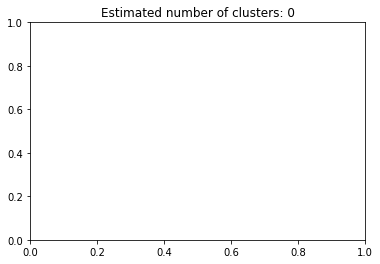

No clusters found
damping: 0.5, max_iter: 600, convergence: 30, preference: None
Estimated number of clusters: 179


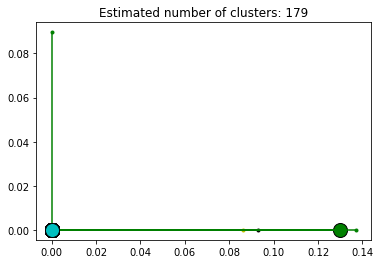

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 82:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 83:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'proposed')


Cluster 84:
('model', 'graphical', 'data', 'network', 'problem', 'method', 'gaussian', 'graph', 'node', 'lasso')


Cluster 85:
('patient', 'model', 'time', 'data', 'image', 'disease', 'risk', 'clinical', 'learning', 'mri')


Cluster 86:
('spurious', 'model', 'valley', 'local', 'recovery', 'fit', 'minimum', 'discovery', 'dimension', 'point')


Cluster 87:
('data', 'decision', 'objective', 'pomdps', 'function', 'information', 'analysis', 'solution', 'optimal', 'jl')


Cluster 88:
('classifier', 'error', 'np', 'type', 'classification', 'oracle', 'data', 'class', 'inequality', 'neyman')


Cluster 89:
('method', 'sta

('gabp', 'algorithm', 'convergence', 'gaussian', 'definite', 'positive', 'multivariate', 'node', 'extension', 'mg')


Cluster 150:
('function', 'data', 'coherence', 'ica', 'sparse', 'coding', 'hinge', 'overcomplete', 'algorithm', 'learning')


Cluster 151:
('convergence', 'stochastic', 'sgd', 'algorithm', 'gradient', 'function', 'method', 'problem', 'learning', 'rate')


Cluster 152:
('state', 'reservoir', 'system', 'input', 'memory', 'space', 'time', 'fading', 'filter', 'feature')


Cluster 153:
('image', 'convolutional', 'invariance', 'network', 'information', 'representation', 'model', 'data', 'neural', 'patch')


Cluster 154:
('constraint', 'algorithm', 'problem', 'convex', 'time', 'optimization', 'regret', 'online', 'set', 'pesc')


Cluster 155:
('regression', 'modal', 'loss', 'learning', 'model', 'symbolic', 'correntropy', 'risk', 'dynamical', 'mmsr')


Cluster 156:
('factor', 'data', 'outcome', 'principal', 'marginal', 'analysis', 'model', 'curve', 'latent', 'correlated')


Clus

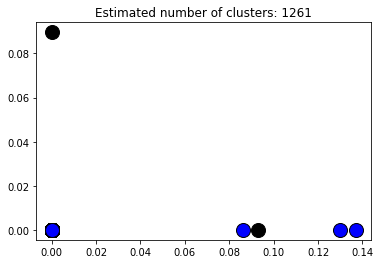

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'learning', 'lmm', 'based', 'data', 'edge', 'algorithm', 'criterion', 'network', 'skeleton')


Cluster 123:
('dimension'

('time', 'process', 'change', 'covariance', 'interval', 'locally', 'mean', 'multivariate', 'smoothness', 'varying')


Cluster 229:
('convex', 'complexity', 'problem', 'algorithm', 'descent', 'dual', 'method', 'optimization', 'strongly', 'applied')


Cluster 230:
('model', 'sparse', 'markov', 'covariance', 'independence', 'matrix', 'data', 'dimensional', 'gaussian', 'high')


Cluster 231:
('step', 'algorithm', 'hmc', 'method', 'nut', 'carlo', 'monte', 'parameter', 'random', 'sampler')


Cluster 232:
('jackknife', 'ij', 'replicates', 'bootstrap', 'estimate', 'study', 'bagged', 'bagging', 'estimator', 'forest')


Cluster 233:
('ranking', 'regret', 'bipartite', 'loss', 'bound', 'proper', 'term', 'pairwise', 'surrogate', '2011')


Cluster 234:
('linear', 'model', 'rate', 'regression', 'achieve', 'aggregation', 'best', 'predictor', 'sparse', 'combination')


Cluster 235:
('structure', 'data', 'estimating', 'graphical', 'model', 'node', 'graph', 'method', 'multi', 'network')


Cluster 236:
('

('random', 'graph', 'process', 'deviation', 'property', 'behavior', 'bound', 'dimension', 'exceptional', 'lower')


Cluster 347:
('information', 'anticausal', 'causal', 'direction', 'supervised', 'cause', 'effect', 'function', 'independence', 'learning')


Cluster 348:
('clustering', 'measure', 'axiom', 'elementary', 'hierarchical', 'notion', 'set', 'user', 'without', 'additivity')


Cluster 349:
('graph', 'bound', 'labelings', 'online', 'problem', 'algorithm', 'labeling', 'latent', 'predicting', 'prediction')


Cluster 350:
('example', 'information', 'student', 'learning', 'privileged', 'teacher', 'describes', 'intelligent', 'knowledge', 'paper')


Cluster 351:
('alexey', 'bibliography', 'chervonenkis', 'comment', 'introductory')


Cluster 352:
('alexey', 'bibliography', 'chervonenkis')


Cluster 353:
('system', 'learning', 'machine', 'common', 'computing', 'delay', 'demonstrate', 'descent', 'encoding', 'far')


Cluster 354:
('beamformers', 'meg', 'vector', 'beamforming', 'proposed', 

('auction', 'price', 'reserve', 'revenue', 'problem', 'algorithm', 'learning', 'second', 'analysis', 'cast')


Cluster 472:
('coordinate', 'data', 'big', 'descent', 'iteration', 'method', 'node', 'partition', 'problem', '3tb')


Cluster 473:
('empirical', 'learning', 'risk', 'statistic', 'incomplete', 'data', 'erm', 'functionals', 'minimization', 'optimization')


Cluster 474:
('learning', 'regularization', 'iterative', 'consider', 'convex', 'function', 'loss', 'new', 'achieved', 'algorithm')


Cluster 475:
('network', 'community', 'detection', 'internet', 'overlapping', 'scale', 'approach', 'inference', 'latent', 'million')


Cluster 476:
('risk', 'patient', 'model', 'stratification', 'learning', 'time', 'admission', 'outcome', '000', 'approach')


Cluster 477:
('component', 'framework', 'learning', 'task', 'feature', 'formulation', 'multitask', 'new', 'study', 'two')


Cluster 478:
('learning', 'multitask', 'representation', 'task', 'method', 'data', 'feature', 'independent', 'learn'

('link', 'model', 'network', 'nonparametric', 'prediction')


Cluster 589:
('spurious', 'fit', 'model', 'discovery', 'goodness', 'variable', 'algorithm', 'asymptotic', 'better', 'correlation')


Cluster 590:
('data', 'functional', 'markov', 'graphical', 'model', 'prior', 'random', 'hyper', 'multivariate', 'process')


Cluster 591:
('autoregressive', 'distribution', 'estimation', 'nade', 'neural', 'also', 'architecture', 'deep', 'model', 'performance')


Cluster 592:
('algorithm', 'consistency', 'density', 'erratum', 'estimation', 'gradient', 'line', 'mean', 'shift', 'paper')


Cluster 593:
('backtracking', 'data', 'dimensional', 'high', 'interaction', 'modelling')


Cluster 594:
('cross', 'fold', 'validation', 'least', 'variance', 'square', 'also', 'case', 'density', 'estimation')


Cluster 595:
('model', 'method', 'matrix', 'fast', 'nystrã', 'approximation', 'prototype', 'efficient', 'spsd', 'accuracy')


Cluster 596:
('decision', 'data', 'different', 'objective', 'support', 'approach

('classification', 'class', 'label', 'procedure', 'set', 'expected', 'number', 'risk', 'size', 'confidence')


Cluster 714:
('item', 'setting', 'ranked', 'list', 'feedback', 'learner', 'ranking', 'top', 'online', 'relevance')


Cluster 715:
('approximation', 'point', 'pseudo', 'framework', 'new', 'power', 'data', 'ep', 'gaussian', 'method')


Cluster 716:
('stochastic', 'asc', 'composition', 'pg', 'gradient', 'method', 'algorithm', 'first', 'optimization', 'problem')


Cluster 717:
('bayesian', 'distributed', 'learning', 'posterior', 'snep', 'data', 'server', 'across', 'algorithm', 'carlo')


Cluster 718:
('dictionary', 'optimal', 'representation', 'vector', 'class', 'given', 'recent', 'used', 'algorithmic', 'attaining')


Cluster 719:
('computational', 'statistical', 'algorithm', 'bound', 'distributed', 'number', 'optimality', 'smoothing', 'cost', 'estimation')


Cluster 720:
('hl', 'mrfs', 'model', 'probabilistic', 'data', 'logic', 'scale', 'structured', 'algorithm', 'inference')


C

('gp', 'approach', 'local', 'prediction', 'region', 'regression', 'response', 'boundary', 'datasets', 'input')


Cluster 829:
('posterior', 'data', 'subset', 'distribution', 'full', 'method', 'sample', 'sampling', 'across', 'approach')


Cluster 830:
('experience', 'replay', 'control', 'learning', 'method', 'reinforcement', 'replayed', 'buffer', 'choice', 'exploration')


Cluster 831:
('condition', 'sdar', 'error', 'iteration', 'solution', 'approach', 'high', 'algorithm', 'bound', 'certain')


Cluster 832:
('algorithm', 'change', 'point', 'graphical', 'model', 'large', 'also', 'data', 'gaussian', 'number')


Cluster 833:
('regression', 'approach', 'model', 'outlier', 'robust', 'distribution', 'estimation', 'optimization', 'bias', 'dro')


Cluster 834:
('optimal', 'distance', 'regularized', 'transport', 'algorithm', 'alternate', 'data', 'divergence', 'framework', 'mover')


Cluster 835:
('elfi', 'inference', 'free', 'likelihood', 'method', 'component', 'distance', 'engine', 'graph', 'ha

('online', 'rfd', 'algorithm', 'learning', 'direction', 'fd', 'frequent', 'application', 'matrix', 'newton')


Cluster 937:
('learning', 'bkrr', 'kernel', 'regression', 'ridge', 'algorithm', 'bias', 'boosted', 'boosting', 'iteration')


Cluster 938:
('spectral', 'clustering', 'general', 'algorithm', 'model', 'adjacency', 'community', 'detection', 'matrix', 'regularization')


Cluster 939:
('treatment', 'rule', 'individualized', 'data', 'estimator', 'proposed', 'estimating', 'observational', 'optimal', 'using')


Cluster 940:
('algorithm', 'bo', 'function', 'hyperparameters', 'optimization', 'optimum', 'several', 'based', 'bayesian', 'converge')


Cluster 941:
('method', 'model', 'prediction', 'probabilistic', 'bayesian', 'correlation', 'ensemble', 'mixture', 'multivariate', 'normal')


Cluster 942:
('problem', 'arm', 'reward', 'stochastic', 'deceptive', 'spl', 'environment', 'feedback', 'location', 'optimal')


Cluster 943:
('hyperparameters', 'algorithm', 'tuning', 'default', 'learnin

('model', 'additive', 'algorithm', 'analysis', 'automatic', 'data', 'degree', 'empirical', 'fast', 'function')


Cluster 1055:
('data', 'ica', 'overcomplete', 'coherence', 'linear', 'algorithm', 'control', 'learning', 'representation', 'show')


Cluster 1056:
('data', 'datawig', 'missing', 'value', 'imputation', 'learning', 'table', 'code', 'existing', 'feature')


Cluster 1057:
('convergence', 'sgd', 'gradient', 'learning', 'rate', 'stochastic', 'analysis', 'assumption', 'bounded', 'function')


Cluster 1058:
('model', 'mcr', 'importance', 'prediction', 'vi', 'variable', 'class', 'well', 'based', 'coefficient')


Cluster 1059:
('mnist', 'data', 'morpho', 'quantitative', 'latent', 'learned', 'learning', 'model', 'representation', 'unsupervised')


Cluster 1060:
('reservoir', 'esp', 'filter', 'input', 'memory', 'research', 'system', 'time', 'approximation', 'computing')


Cluster 1061:
('dpps', 'sampling', 'dppy', 'point', 'probability', 'python', 'across', 'algorithm', 'approximate', '

Cluster 1168:
('meta', 'learning', 'feature', 'algorithm', 'machine', 'package', 'automated', 'deal', 'experiment', 'extraction')


Cluster 1169:
('covariance', 'matrix', 'classifier', 'lda', 'estimator', 'sample', 'performance', 'analysis', 'approach', 'assumption')


Cluster 1170:
('model', 'molecule', 'several', 'decoder', 'property', 'able', 'art', 'deep', 'generative', 'graph')


Cluster 1171:
('distribution', 'latent', 'model', 'nonparametric', 'state', 'consistent', 'estimation', 'general', 'hidden', 'markov')


Cluster 1172:
('series', 'time', 'gluonts', 'modeling', 'model', 'python', 'addition', 'algorithm', 'anomaly', 'art')


Cluster 1173:
('model', 'factor', 'equation', 'variable', 'favar', 'set', 'var', 'dimensional', 'estimate', 'high')


Cluster 1174:
('tslearn', 'learning', 'machine', 'model', 'series', 'time', 'tool', 'allowing', 'application', 'available')


Cluster 1175:
('surface', 'closed', 'patch', 'point', 'prior', 'product', 'tensor', 'along', 'bayesian', 'edge'

damping: 0.8, max_iter: 200, convergence: 8, preference: -50
Estimated number of clusters: 1261


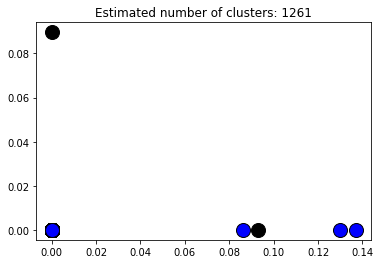

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('manifold', 'regularization', 'supervised', 'example', 'learning', 'result', 'semi', 'algorithm', 'analysis', 'labeled')


Cluster 114:
('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Clust

('ranking', 'regret', 'bipartite', 'loss', 'bound', 'proper', 'term', 'pairwise', 'surrogate', '2011')


Cluster 234:
('linear', 'model', 'rate', 'regression', 'achieve', 'aggregation', 'best', 'predictor', 'sparse', 'combination')


Cluster 235:
('structure', 'data', 'estimating', 'graphical', 'model', 'node', 'graph', 'method', 'multi', 'network')


Cluster 236:
('graph', 'time', 'commute', 'hitting', 'distance', 'random', 'vertex', 'degree', 'expected', 'learning')


Cluster 237:
('bayesian', 'posterior', 'latent', 'inference', 'present', 'regbayes', 'regularization', 'distribution', 'infinite', 'prior')


Cluster 238:
('prior', 'model', 'parameter', 'approach', 'nn', 'scale', 'hierarchical', 'network', 'relevance', 'using')


Cluster 239:
('data', 'missing', 'algorithm', 'imputation', 'likelihood', 'observed', 'alternating', 'dimensional', 'high', 'log')


Cluster 240:
('network', 'neural', 'dropout', 'overfitting', 'large', 'different', 'learning', 'many', 'net', 'number')


Clust

('learning', 'poem', 'risk', 'ad', 'bandit', 'counterfactual', 'crm', 'feedback', 'minimization', 'principle')


Cluster 342:
('distance', 'bound', 'matrix', 'density', 'quantum', 'rank', 'entropy', 'estimation', 'low', 'lower')


Cluster 343:
('condition', 'learning', 'fast', 'central', 'rate', 'mixability', 'statistical', 'algorithm', 'online', 'show')


Cluster 344:
('asymptotic', 'regression', 'estimate', 'function', 'normality', 'variance', 'depends', 'dimension', 'explicitly', 'functional')


Cluster 345:
('oracle', 'inequality', 'aggregation', 'bound', 'convex', 'improvement', 'obtain', 'previous', 'regression', 'result')


Cluster 346:
('random', 'graph', 'process', 'deviation', 'property', 'behavior', 'bound', 'dimension', 'exceptional', 'lower')


Cluster 347:
('information', 'anticausal', 'causal', 'direction', 'supervised', 'cause', 'effect', 'function', 'independence', 'learning')


Cluster 348:
('clustering', 'measure', 'axiom', 'elementary', 'hierarchical', 'notion', 'se

('kernel', 'estimator', 'mean', 'empirical', 'method', 'shrinkage', 'standard', 'used', 'algorithm', 'also')


Cluster 450:
('model', 'approximation', 'bound', 'matrix', 'algorithm', 'error', 'extension', 'prototype', 'spsd', 'column')


Cluster 451:
('query', 'mechanism', 'data', 'smooth', 'continuous', 'answer', 'function', 'differential', 'differentially', 'discrete')


Cluster 452:
('subspace', 'learning', 'information', 'instance', 'partial', 'vector', 'algorithm', 'analyze', 'attribute', 'complexity')


Cluster 453:
('lasso', 'poisson', 'group', 'procedure', 'regression', 'analysis', 'approach', 'data', 'framework', 'inequality')


Cluster 454:
('causal', 'approach', 'effect', 'inference', 'observational', 'path', 'conditional', 'independency', 'one', 'study')


Cluster 455:
('order', 'partial', 'method', 'sampling', 'ai', 'algorithm', 'based', 'dag', 'bayesian', 'carlo')


Cluster 456:
('model', 'comparison', 'bound', 'error', 'pairwise', 'cardinal', 'class', 'compared', 'data',

('vertex', 'nomination', 'ml', 'scheme', 'based', 'graph', 'likelihood', 'prove', 'approach', 'bayes')


Cluster 569:
('kernel', 'distribution', 'characteristic', 'divisible', 'infinitely', 'mean', 'ii', 'probability', 'case', 'class')


Cluster 570:
('cut', 'graph', 'sample', 'based', 'consistency', 'cheeger', 'cloud', 'clustering', 'functionals', 'ground')


Cluster 571:
('feature', 'class', 'selection', 'based', 'classification', 'criterion', 'gaussian', 'information', 'informative', 'jointly')


Cluster 572:
('machine', 'factorization', 'fm', 'implementation', 'application', 'fastfm', 'model', 'range', 'access', 'classification')


Cluster 573:
('outcome', 'drug', 'effect', 'estimating', 'latent', 'method', 'model', 'sccs', 'approach', 'case')


Cluster 574:
('patient', 'feature', 'analysis', 'modality', 'model', 'poisson', 'unit', 'based', 'deep', 'ehr')


Cluster 575:
('cluster', 'data', 'low', 'matrix', 'method', 'rank', 'clustering', 'factorization', 'number', 'analysis')


Clu

('tensor', 'completability', 'cp', 'rank', 'sampling', 'completion', 'entry', 'finite', 'number', 'polynomial')


Cluster 678:
('learning', 'approach', 'example', 'rule', 'class', 'data', 'description', 'exception', 'expression', 'general')


Cluster 679:
('search', 'learning', 'partial', 'policy', 'tree', 'action', 'algorithm', 'branching', 'contribution', 'making')


Cluster 680:
('kernel', 'data', 'proposed', 'rank', 'approximation', 'complexity', 'hierarchical', 'learning', 'low', 'method')


Cluster 681:
('root', 'square', 'norm', 'al', 'estimator', 'et', 'decomposable', 'slope', 'sparsity', 'weakly')


Cluster 682:
('dpvi', 'based', 'particle', 'search', 'variational', 'approximation', 'carlo', 'like', 'model', 'monte')


Cluster 683:
('model', 'rule', 'set', 'condition', 'form', 'method', 'advantage', 'bayesian', 'classification', 'classifier')


Cluster 684:
('measure', 'dependence', 'feature', 'robust', 'rcd', 'equitable', 'copula', 'equitability', 'relationship', 'selection')

('problem', 'method', 'regression', 'sgd', 'algorithm', 'applicable', 'linear', 'randomized', 'rla', 'aim')


Cluster 804:
('gaussian', 'ib', 'representation', 'information', 'data', 'embedding', 'set', 'arbitrary', 'bottleneck', 'bound')


Cluster 805:
('model', 'library', 'tick', 'core', 'dependent', 'emphasis', 'learning', 'process', 'python', 'statistical')


Cluster 806:
('algorithm', 'problem', 'library', 'optimization', 'stochastic', 'matlab', 'ml', 'sgdlibrary', 'use', 'approach')


Cluster 807:
('network', 'policy', 'action', 'bound', 'observation', 'side', 'structure', 'asymptotic', 'common', 'example')


Cluster 808:
('graphical', 'algorithm', 'cluster', 'dimensional', 'ecm', 'error', 'heterogeneous', 'high', 'model', 'cancer')


Cluster 809:
('mrr', 'sketched', 'sketch', 'problem', 'solution', 'classical', 'lsr', 'optimal', 'statistical', 'averaging')


Cluster 810:
('criterion', 'graph', 'adjustment', 'set', 'ancestral', 'class', 'graphical', 'acyclic', 'complete', 'covari

('gl', 'method', 'matrix', 'consistent', 'covariance', 'sample', 'thresholded', 'data', 'graphical', 'result')


Cluster 905:
('learning', 'measurement', 'theory', 'vector', 'approximately', 'bit', 'compressed', 'correct', 'one', 'pac')


Cluster 906:
('clustering', 'approximation', 'kernel', 'mean', 'nystrom', 'linear', 'work', 'algorithm', 'rank', 'relative')


Cluster 907:
('prediction', 'inference', 'lp', 'structured', 'instance', 'learning', 'linear', 'relaxation', 'test', 'tightness')


Cluster 908:
('problem', 'bandit', 'distribution', 'mixing', 'pay', 'paper', 'restless', 'sampling', 'version', 'accompanied')


Cluster 909:
('user', 'item', 'information', 'network', 'recommender', 'covariates', 'neighborhood', 'specific', 'data', 'method')


Cluster 910:
('agent', 'regret', 'bandit', 'delay', 'exp3', 'minimax', 'action', 'bound', 'communication', 'coop')


Cluster 911:
('cross', 'validation', 'performance', 'best', 'class', 'hazard', 'local', 'mathematical', 'multiplicative', '


Cluster 971:
('data', 'smart', 'labeled', 'learning', 'designed', 'help', 'open', 'platform', 'research', 'set')


Cluster 972:
('algorithm', 'hedge', 'stochastic', 'adaptive', 'case', 'learning', 'rate', 'anytime', 'easier', 'one')


Cluster 973:
('game', 'gradient', 'component', 'differentiable', 'guarantee', 'new', 'adversarial', 'algorithm', 'conservation', 'descent')


Cluster 974:
('partition', 'data', 'space', 'spatial', 'tree', 'model', 'partitioning', 'problem', 'proposed', 'random')


Cluster 975:
('subspace', 'data', 'incomplete', 'snipe', 'linear', 'streaming', 'algorithm', 'block', 'computational', 'efficiently')


Cluster 976:
('distributed', 'method', 'model', 'nonparametric', 'performance', 'adapt', 'analysis', 'asymptotic', 'automatically', 'benchmark')


Cluster 977:
('model', 'selection', 'dimension', 'estimator', 'verify', 'chervonenkis', 'compared', 'consistent', 'data', 'derive')


Cluster 978:
('sparse', 'model', 'regression', 'dependency', 'determination', 'pri

('function', 'non', 'problem', 'smooth', 'algorithm', 'class', 'convergence', 'convex', 'method', 'also')


Cluster 1038:
('prediction', 'uncertainty', 'algorithm', 'quantifying', 'regression', 'able', 'approach', 'based', 'bounded', 'data')


Cluster 1039:
('simpledet', 'detection', 'object', 'training', 'framework', 'model', 'distributed', 'high', 'instance', 'large')


Cluster 1040:
('graph', 'graspy', 'python', 'package', 'algorithm', 'analyzing', 'apache', 'api', 'available', 'compliant')


Cluster 1041:
('function', 'communication', 'rate', 'algorithm', 'objective', 'convergence', 'convex', 'distributed', 'network', 'non')


Cluster 1042:
('diffusion', 'clustering', 'data', 'lund', 'algorithm', 'based', 'density', 'distance', 'nonlinear', 'parameter')


Cluster 1043:
('algorithm', 'kernel', 'based', 'coefficient', 'rate', 'regression', 'convergence', 'function', 'local', 'minimizer')


Cluster 1044:
('change', 'point', 'data', 'kernel', 'model', 'selection', 'method', 'penalty', 

('network', 'neural', 'invariant', 'symmetry', 'group', 'probabilistic', 'action', 'characterize', 'compact', 'data')


Cluster 1148:
('model', 'graphical', 'parameter', 'estimator', 'inference', 'consistent', 'literature', 'statistical', 'allows', 'constant')


Cluster 1149:
('metropolized', 'algorithm', 'bound', 'hmc', 'mixing', 'carlo', 'monte', 'step', 'time', 'chain')


Cluster 1150:
('dkrr', 'learning', 'communication', 'distributed', 'optimal', 'performance', 'experiment', 'generalization', 'kernel', 'rate')


Cluster 1151:
('test', 'parallelism', 'nonparametric', 'minimax', 'proposed', 'distribution', 'study', 'anova', 'application', 'applied')


Cluster 1152:
('cornac', 'multimodal', 'recommender', 'auxiliary', 'data', 'framework', 'item', 'model', 'python', 'system')


Cluster 1153:
('algorithm', 'learning', 'pydml', 'classifier', 'distance', 'library', 'metric', 'nearest', 'provides', 'also')


Cluster 1154:
('covariance', 'estimate', 'rank', 'loss', 'one', 'portfolio', 'ris

('assortment', 'feature', 'information', 'optimization', 'product', 'model', 'bound', 'choice', 'contextual', 'dynamic')


damping: 0.8, max_iter: 200, convergence: 8, preference: None
Estimated number of clusters: 181


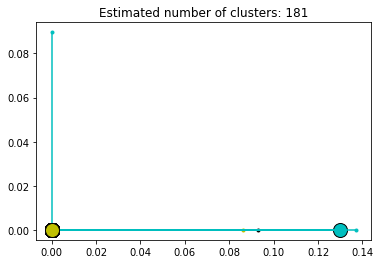

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('model', 'graphical', 'data', 'network', 'problem', 'method', 'gaussian', 'graph', 'node', 'lasso')


Cluster 87:
('patient', 'model', 'time', 'data', 'image', 'disease', 'risk', 'clinical', 'learning', 'mri')


Cluster 88:
('spurious', 'model', 'valley', 'local', 'recovery', 'fit', 'minimum', 'discovery', 'dimension', 'point')


Cluster 89:
('data', 'decision', 'objective', 'pomdps', 'function', 'information', 'analysis', 'solution', 'optimal', 'jl')


Cluster 90:
('classifier', 'error', 'type', 'np', 'classification', 'oracle', 'class', 'neyman', 'pearson', 'inequality')


Cluster 91:
('method', 'statistical', 'problem', 'sketching', 'data', 'mrr', 'algorithm', 'equation', 'randomized', 'sketched')


Cluster 92:
('loss', 'multiclass', 'problem', 'proper', 'sequence', 'algorithm', 'result', 'bayes', 'convex', 'function')


Cluster 93:
('lpcc', 'latent', 'part', 'algorithm', 'cluster', 'graph', 'true', 'model', 'data', 'pcc')


Cluster 94:
('hierarchical', 'algorithm', 'model', 'based

('data', 'supervised', 'graph', 'unlabeled', 'semi', 'consistency', 'learning', 'cut', 'based', 'harmonic')


Cluster 163:
('dual', 'method', 'convex', 'problem', 'primal', 'complexity', 'algorithm', 'iteration', 'solution', 'optimization')


Cluster 164:
('causal', 'effect', 'variable', 'data', 'model', 'method', 'algorithm', 'discovery', 'approach', 'learning')


Cluster 165:
('attack', 'based', 'detection', 'method', 'random', 'learning', 'distribution', 'image', 'robustness', 'smoothing')


Cluster 166:
('ensemble', 'model', 'relational', 'method', 'learning', 'base', 'learner', 'prediction', 'data', 'exploration')


Cluster 167:
('kernel', 'square', 'least', 'regression', 'approximation', 'gradient', 'model', 'matrix', 'regularized', 'partial')


Cluster 168:
('dictionary', 'algorithm', 'local', 'learning', 'optimal', 'representation', 'asymptotic', 'reference', 'multiscale', 'robustness')


Cluster 169:
('class', 'detection', 'data', 'set', 'classifier', 'model', 'classification'

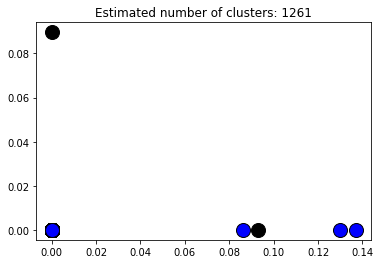

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('method', 'model', 'nonparametric', 'variable', 'learning', 'problem', 'proposed', 'regularization', 'selection', 'show')


Cluster 126:
('matrix', 'cluster', 'similarity', 'clustering', 'factorization', 'given', 'based', 'left', 'stochastic', 'algorithm')


Cluster 127:
('consistent', 'convergence', 'maximum', 'unfolding', 'variance', 'assumption', 'convex', 'dimensionality', 'example', 'fails')


Cluster 128:
('coefficient', 'design', 'performance', 'selection', 'variable', 'vector', 'also', 'analyzed', 'matching', 'omp')


Cluster 129:
('kernel', 'learning', 'random', 'curve', 'graph', 'prior', 'vertex', 'gaussian', 'large', 'process')


Cluster 130:
('angle', 'distribution', 'random', 'limiting', 'setting', 'vector', 'almost', 'also', 'always', 'among')


Cluster 131:
('clustering', 'learning', 'analysis', 'cluster', 'method', 'regression', 'classification', 'convex', 'generalized', 'non')


Cluster 132:
('group', 'prior', 'feature', 'bayesian', 'generalized', 'problem', 'selectio

('image', 'mixture', 'model', 'patch', 'prior', 'based', 'coding', 'comparable', 'compression', 'easily')


Cluster 244:
('chain', 'markov', 'inference', 'mcmc', 'distribution', 'sampling', 'advantage', 'approximation', 'carlo', 'core')


Cluster 245:
('cost', 'classifier', 'feature', 'test', 'cascade', 'time', 'algorithm', 'input', 'tree', 'accuracy')


Cluster 246:
('pgas', 'carlo', 'model', 'monte', 'particle', 'ancestor', 'markov', 'sampling', 'smc', 'state')


Cluster 247:
('cluster', 'edge', 'observed', 'algorithm', 'clustering', 'know', 'number', 'partially', 'problem', 'across')


Cluster 248:
('community', 'model', 'membership', 'learning', 'tensor', 'block', 'detection', 'guaranteed', 'method', 'stochastic')


Cluster 249:
('model', 'tree', 'learning', 'reinforcement', 'bayesian', 'cover', 'gaussian', 'linear', 'policy', 'space')


Cluster 250:
('model', 'force', 'periodic', 'latent', 'approach', 'lfms', 'linear', 'state', 'within', '2012')


Cluster 251:
('algorithm', 'pcfgs

('data', 'tensor', 'based', 'community', 'latent', 'modeling', 'problem', 'set', 'topic', 'accuracy')


Cluster 375:
('gaussian', 'process', 'design', 'function', 'prior', 'bayesian', 'covariates', 'distribution', 'estimation', 'kernel')


Cluster 376:
('ceka', 'algorithm', 'class', 'crowd', 'easier', 'function', 'instance', 'learning', 'make', 'model')


Cluster 377:
('analysis', 'linear', 'method', 'data', 'dimensionality', 'reduction', 'optimization', 'correlation', 'survey', 'canonical')


Cluster 378:
('causal', 'data', 'art', 'causation', 'coefficient', 'pair', 'random', 'relationship', 'state', 'variable')


Cluster 379:
('process', 'intensity', 'approach', 'gaussian', 'learning', 'method', 'paper', 'poisson', 'provide', 'theoretical')


Cluster 380:
('feature', 'paper', '2013', 'author', 'cup', 'kdd', 'model', 'set', 'engineering', 'first')


Cluster 381:
('matrix', 'sampling', 'element', 'leverage', 'score', 'approach', 'column', 'known', 'rank', 'row')


Cluster 382:
('algori

('image', 'large', 'data', 'learning', 'interpretation', 'patient', 'scale', 'system', 'text', 'approach')


Cluster 503:
('distribution', 'domain', 'source', 'target', 'approach', 'distance', 'embedding', 'may', 'space', 'adaptation')


Cluster 504:
('learning', 'function', 'monotonic', 'feature', 'accuracy', 'calibrated', 'interpolated', 'look', 'machine', 'problem')


Cluster 505:
('classifier', 'forest', 'random', 'best', 'study', 'family', 'set', 'test', '121', '17')


Cluster 506:
('distribution', 'emission', 'estimator', 'model', 'nonparametric', 'adaptive', 'estimation', 'hidden', 'least', 'markov')


Cluster 507:
('mri', 'fcd', 'lesion', 'negative', 'patient', 'cortical', 'epilepsy', 'rate', 'surface', 'across')


Cluster 508:
('data', 'study', 'heterogeneity', 'fused', 'lasso', 'method', 'parameter', 'power', 'set', 'analysis')


Cluster 509:
('lrp', 'implementation', 'model', 'network', 'algorithm', 'data', 'format', 'matlab', 'neural', 'prediction')


Cluster 510:
('graphic

('approximation', 'variational', 'estimator', 'gibbs', 'posterior', 'property', 'bayesian', 'convex', 'corresponding', 'datasets')


Cluster 622:
('inference', 'convergence', 'cvb', 'acvb', 'bayes', 'variational', 'averaged', 'bayesian', 'collapsed', 'detection')


Cluster 623:
('user', 'influence', 'network', 'algorithm', 'time', 'constraint', 'continuous', 'diffusion', 'estimation', 'multiple')


Cluster 624:
('algorithm', 'clustering', 'change', 'local', 'cluster', 'design', 'desirable', 'framework', 'interactive', 'practice')


Cluster 625:
('approach', 'efficient', 'lasso', 'across', 'communication', 'dataset', 'regression', 'sparse', 'split', 'algorithm')


Cluster 626:
('variational', 'approximation', 'linear', 'response', 'constraint', 'inference', 'method', 'achieved', 'allow', 'approxima')


Cluster 627:
('input', 'network', 'analysis', 'rnns', 'memory', 'result', 'stm', 'capacity', 'esns', 'linearly')


Cluster 628:
('pi', 'vector', 'data', 'machine', 'pd', 'persistence', 'r

('non', 'policy', 'parametric', 'algorithm', 'function', 'method', 'update', 'approximate', 'control', 'data')


Cluster 687:
('independence', 'test', 'statistic', 'distance', 'testing', 'vector', 'application', 'covariance', 'dependency', 'mutual')


Cluster 688:
('data', 'pca', 'sparse', 'element', 'sampling', 'algorithm', 'hybrid', 'sample', 'entry', 'recover')


Cluster 689:
('use', 'analysis', 'bayesian', 'learning', 'machine', 'nhst', 'result', 'abandonment', 'adopted', 'also')


Cluster 690:
('model', 'effect', 'learning', 'approach', 'exogenous', 'show', 'task', 'clear', 'combine', 'complex')


Cluster 691:
('tensor', 'regression', 'approach', 'bayesian', 'estimation', 'posterior', 'prior', 'algorithm', 'analysis', 'application')


Cluster 692:
('clustering', 'dimension', 'dimensional', 'discriminative', 'propose', 'sparse', 'algorithm', 'case', 'cast', 'cluster')


Cluster 693:
('tree', 'decision', 'dimension', 'ultrahigh', 'feature', 'label', 'dt', 'linear', 'model', 'sbt')



('gcg', 'efficient', 'learning', 'matrix', 'algorithm', 'alternative', 'completion', 'conditional', 'convex', 'current')


Cluster 751:
('ftl', 'algorithm', 'domain', 'regret', 'convex', 'curved', 'enjoys', 'leader', 'loss', 'set')


Cluster 752:
('matrix', 'outlier', 'algorithm', 'completion', 'criterion', 'defined', 'entry', 'noisy', 'optimization', 'begin')


Cluster 753:
('graph', 'distribution', 'model', 'given', 'independence', 'probability', 'case', 'condition', 'faithful', 'general')


Cluster 754:
('multilayer', 'layer', 'community', 'network', 'extraction', 'vertex', 'model', 'set', 'available', 'capture')


Cluster 755:
('gaussian', 'process', 'feature', 'spectral', 'variational', 'approach', 'approximation', 'computation', 'data', 'dimension')


Cluster 756:
('data', 'al', 'dimensional', 'et', 'dimensionality', 'geometric', 'high', 'insight', 'reduction', 'technique')


Cluster 757:
('ad', 'learning', 'machine', 'differentiation', 'automatic', 'technique', 'application', 'a

('policy', 'scheme', 'td', 'trace', 'learning', 'process', 'based', 'bellman', 'equation', 'generalized')


Cluster 865:
('information', 'representation', 'invariance', 'learned', 'loss', 'network', 'term', 'training', 'using', 'weight')


Cluster 866:
('formula', 'approximate', 'cross', 'validation', '2017', 'data', 'logistic', 'multinomial', 'obuchi', 'regression')


Cluster 867:
('profile', 'action', 'bandit', 'setting', 'vector', 'case', 'data', 'feature', 'given', 'mapping')


Cluster 868:
('deep', 'process', 'gaussian', 'ergodicity', 'depth', 'resulting', 'used', 'class', 'construction', 'effective')


Cluster 869:
('walk', 'vaidya', 'time', 'dikin', 'john', 'mixing', 'algorithm', 'sampling', 'barrier', 'based')


Cluster 870:
('tv', 'solver', 'method', 'modular', '1d', 'connection', 'denoising', 'easy', 'efficient', 'image')


Cluster 871:
('model', 'graphical', 'method', 'semiparametric', 'data', 'different', 'edge', 'existing', 'exponential', 'family')


Cluster 872:
('lo', 'e

('model', 'bipartite', 'community', 'addition', 'covariates', 'data', 'degree', 'detection', 'fitting', 'matched')


Cluster 928:
('policy', 'problem', 'cost', 'index', 'observation', 'optimal', 'posterior', 'threshold', 'time', 'variance')


Cluster 929:
('graph', 'algorithm', 'flow', 'min', 'problem', 'sum', 'walk', 'analyze', 'defined', 'framework')


Cluster 930:
('method', 'subspace', 'condition', 'deterministic', 'gradient', 'recovery', 'size', 'underlying', 'achieves', 'ambient')


Cluster 931:
('problem', 'sparse', 'optimization', 'approximately', 'class', 'function', 'hardness', 'loss', 'np', 'penalty')


Cluster 932:
('method', 'accuracy', 'dimension', 'randomized', 'cost', 'bootstrap', 'computation', 'error', 'general', 'given')


Cluster 933:
('base', 'distribution', 'model', 'problem', 'setting', 'classification', 'contamination', 'general', 'label', 'learning')


Cluster 934:
('method', 'order', 'approach', 'convergence', 'convex', 'empirical', 'fast', 'information', 'ite

('algorithm', 'pc', 'proposed', 'common', 'dimensional', 'estimation', 'gene', 'graph', 'high', 'large')


Cluster 1047:
('gabp', 'convergence', 'gaussian', 'extension', 'marginals', 'mg', 'multivariate', 'pairwise', 'paper', 'also')


Cluster 1048:
('ensemble', 'algorithm', 'classifier', 'sample', 'summa', 'unsupervised', 'aggregation', 'base', 'data', 'estimate')


Cluster 1049:
('canonical', 'sample', 'correlation', 'accuracy', 'achieve', 'algorithm', 'analysis', 'complexity', 'covariance', 'data')


Cluster 1050:
('model', 'gaussian', 'process', 'matrix', 'mixture', 'computational', 'embarrassingly', 'expert', 'inference', 'inversion')


Cluster 1051:
('density', 'cluster', 'estimation', 'rate', 'dbscan', 'optimal', 'tree', 'algorithm', 'minimax', 'al')


Cluster 1052:
('group', 'model', 'covariance', 'subspace', 'dimensional', 'eigenvectors', 'method', 'use', 'across', 'algorithm')


Cluster 1053:
('non', 'constraint', 'convex', 'differentiable', 'optimization', 'goal', 'problem',

('causal', 'jci', 'data', 'discovery', 'algorithm', 'different', 'implementation', 'approach', 'case', 'certain')


Cluster 1157:
('model', 'latent', 'feature', 'data', 'datasets', 'heterogeneous', 'allocation', 'analysis', 'attribute', 'general')


Cluster 1158:
('gabp', 'algorithm', 'convergence', 'node', 'regularization', 'extension', 'gaussian', 'inference', 'mg', 'multivariate')


Cluster 1159:
('ai', 'toolbox', 'library', 'contains', 'learning', 'planning', 'python', 'reinforcement', 'software', 'support')


Cluster 1160:
('gradient', 'stochastic', 'algorithm', 'nonconvex', 'optimization', 'variance', 'function', 'complexity', 'nested', 'point')


Cluster 1161:
('forest', 'decision', 'tree', 'axis', 'oblique', 'projection', 'sparse', 'split', 'sporf', 'aligned')


Cluster 1162:
('stochastic', 'gradient', 'submodular', 'continuous', 'convex', 'function', 'guarantee', 'method', 'monotone', 'approximation')


Cluster 1163:
('function', 'hypergraph', 'submodular', 'algorithm', 'decom

('estimator', 'outcome', 'correlated', 'data', 'dimensional', 'distributed', 'high', 'learning', 'supervised', 'block')


Cluster 1227:
('dnns', 'intrinsic', 'data', 'dimensional', 'dimensionality', 'low', 'covariates', 'error', 'high', 'study')


Cluster 1228:
('bottleneck', 'network', 'neural', 'wide', 'composition', 'gaussian', 'hidden', 'layer', 'limit', 'process')


Cluster 1229:
('otr', 'method', 'based', 'inference', 'optimal', 'proposed', 'subagging', 'treatment', 'ci', 'estimator')


Cluster 1230:
('agent', 'value', 'learning', 'centralised', 'decentralised', 'multi', 'qmix', 'action', 'fashion', 'joint')


Cluster 1231:
('imaging', 'data', 'collection', 'inverse', 'problem', 'setting', 'bayesian', 'computational', 'framework', 'image')


Cluster 1232:
('network', 'communication', 'optimization', 'agent', 'algorithm', 'dane', 'decentralized', 'distributed', 'local', 'computation')


Cluster 1233:
('learning', 'curriculum', 'reinforcement', 'task', 'framework', 'problem', 'cl',

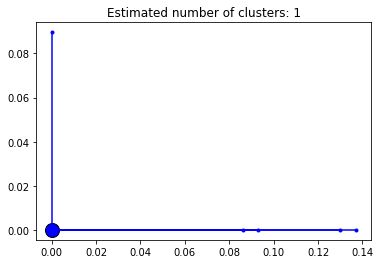

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


damping: 0.8, max_iter: 200, convergence: 15, preference: None
Estimated number of clusters: 180


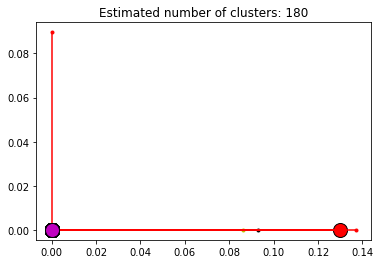

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 78:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 79:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')


Cluster 80:
('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluster 81:
('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 82:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 83:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 84:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'pro

('image', 'convolutional', 'invariance', 'network', 'information', 'representation', 'model', 'data', 'neural', 'patch')


Cluster 155:
('constraint', 'algorithm', 'problem', 'convex', 'time', 'optimization', 'regret', 'online', 'set', 'pesc')


Cluster 156:
('regression', 'modal', 'loss', 'learning', 'model', 'symbolic', 'correntropy', 'risk', 'dynamical', 'mmsr')


Cluster 157:
('factor', 'data', 'outcome', 'principal', 'marginal', 'analysis', 'model', 'curve', 'latent', 'correlated')


Cluster 158:
('data', 'bayesian', 'inference', 'approximation', 'ep', 'framework', 'model', 'imaging', 'correction', 'method')


Cluster 159:
('interaction', 'high', 'data', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'problem', 'matrix')


Cluster 160:
('graph', 'algorithm', 'problem', 'learning', 'random', 'model', 'data', 'spectral', 'framework', 'time')


Cluster 161:
('data', 'supervised', 'graph', 'unlabeled', 'semi', 'consistency', 'learning', 'cut', 'based', 'harmonic')


Cl

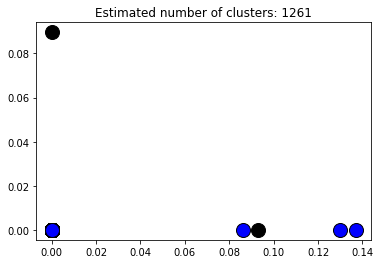

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'learning', 'lmm', 'based', 'data', 'edge', 'algorithm', 'criterion', 'network', 'skeleton')


Cluster 123:
('dimension', 'similarity', 'independent', 'algorithm', 'computation', 'data', 'jaccard', 'large', 'result', 'twitter')


Cluster 124:
('model', 'sign', 'handshape', 'signer', 'affine', 'hand', 'aff', 'appearance', 'approach', 'classification')


Cluster 125:
('method

('network', 'neural', 'dropout', 'overfitting', 'large', 'different', 'learning', 'many', 'net', 'number')


Cluster 241:
('question', 'concept', 'factor', 'learning', 'analytics', 'estimate', 'solution', 'underlying', 'analysis', 'based')


Cluster 242:
('graph', 'distribution', 'acyclic', 'additive', 'causal', 'directed', 'independence', 'method', 'model', 'noise')


Cluster 243:
('image', 'mixture', 'model', 'patch', 'prior', 'based', 'coding', 'comparable', 'compression', 'easily')


Cluster 244:
('chain', 'markov', 'inference', 'mcmc', 'distribution', 'sampling', 'advantage', 'approximation', 'carlo', 'core')


Cluster 245:
('cost', 'classifier', 'feature', 'test', 'cascade', 'time', 'algorithm', 'input', 'tree', 'accuracy')


Cluster 246:
('pgas', 'carlo', 'model', 'monte', 'particle', 'ancestor', 'markov', 'sampling', 'smc', 'state')


Cluster 247:
('cluster', 'edge', 'observed', 'algorithm', 'clustering', 'know', 'number', 'partially', 'problem', 'across')


Cluster 248:
('comm

('graph', 'bound', 'labelings', 'online', 'problem', 'algorithm', 'labeling', 'latent', 'predicting', 'prediction')


Cluster 350:
('example', 'information', 'student', 'learning', 'privileged', 'teacher', 'describes', 'intelligent', 'knowledge', 'paper')


Cluster 351:
('alexey', 'bibliography', 'chervonenkis', 'comment', 'introductory')


Cluster 352:
('alexey', 'bibliography', 'chervonenkis')


Cluster 353:
('system', 'learning', 'machine', 'common', 'computing', 'delay', 'demonstrate', 'descent', 'encoding', 'far')


Cluster 354:
('beamformers', 'meg', 'vector', 'beamforming', 'proposed', 'activity', 'case', 'covariance', 'data', 'dimension')


Cluster 355:
('data', 'set', 'different', 'combine', 'constraint', 'algorithm', 'causal', 'intervention', 'model', 'overlapping')


Cluster 356:
('entropy', 'function', 'cone', 'proper', 'rule', 'scoring', 'space', 'associated', 'density', 'derivative')


Cluster 357:
('bound', 'arm', 'mean', 'sample', 'distribution', 'problem', 'stratum', '

('regression', 'feature', 'compression', 'large', 'random', 'approach', 'conditionally', 'distribution', 'gaussian', 'manifold')


Cluster 467:
('loss', 'algorithm', 'boosting', 'class', 'fisher', 'function', 'proposed', 'al', 'application', 'consistent')


Cluster 468:
('sum', 'formulation', 'path', 'covariance', 'model', 'arbitrary', 'graphical', 'matrix', 'gaussian', 'topology')


Cluster 469:
('gesture', 'recognition', 'available', 'challenge', 'multimodal', 'art', 'camera', 'data', 'including', 'overview')


Cluster 470:
('td', 'method', 'parameter', 'step', 'update', 'difference', 'different', 'emphasizing', 'emphatic', 'function')


Cluster 471:
('auction', 'price', 'reserve', 'revenue', 'problem', 'algorithm', 'learning', 'second', 'analysis', 'cast')


Cluster 472:
('coordinate', 'data', 'big', 'descent', 'iteration', 'method', 'node', 'partition', 'problem', '3tb')


Cluster 473:
('empirical', 'learning', 'risk', 'statistic', 'incomplete', 'data', 'erm', 'functionals', 'minim

('spurious', 'fit', 'model', 'discovery', 'goodness', 'variable', 'algorithm', 'asymptotic', 'better', 'correlation')


Cluster 590:
('data', 'functional', 'markov', 'graphical', 'model', 'prior', 'random', 'hyper', 'multivariate', 'process')


Cluster 591:
('autoregressive', 'distribution', 'estimation', 'nade', 'neural', 'also', 'architecture', 'deep', 'model', 'performance')


Cluster 592:
('algorithm', 'consistency', 'density', 'erratum', 'estimation', 'gradient', 'line', 'mean', 'shift', 'paper')


Cluster 593:
('backtracking', 'data', 'dimensional', 'high', 'interaction', 'modelling')


Cluster 594:
('cross', 'fold', 'validation', 'least', 'variance', 'square', 'also', 'case', 'density', 'estimation')


Cluster 595:
('model', 'method', 'matrix', 'fast', 'nystrã', 'approximation', 'prototype', 'efficient', 'spsd', 'accuracy')


Cluster 596:
('decision', 'data', 'different', 'objective', 'support', 'approach', 'function', 'maker', 'markov', 'multi')


Cluster 597:
('statistic', 're

('clustering', 'random', 'model', 'cluster', 'ensemble', 'impact', 'number', 'similarity', 'size', 'assumption')


Cluster 700:
('algorithm', 'cost', 'clustering', 'hierarchical', 'approximation', 'problem', '2016', 'also', 'constant', 'cut')


Cluster 701:
('decision', 'multiagent', 'system', 'learning', 'planning', 'provides', 'support', 'agent', 'environment', 'library')


Cluster 702:
('algorithm', 'analysis', 'descent', 'bound', 'ftrl', 'mirror', 'adaptive', 'learning', 'regret', 'allows')


Cluster 703:
('method', 'cost', 'algorithm', 'distributed', 'communication', 'existing', 'step', 'system', 'variable', 'block')


Cluster 704:
('learning', 'data', 'least', 'square', 'distributed', 'expectation', 'function', 'output', 'rate', 'regularization')


Cluster 705:
('worker', 'honest', 'algorithm', 'label', 'unreliable', 'adversarial', 'strategy', 'adversary', 'labeling', 'probabilistic')


Cluster 706:
('label', 'class', 'classification', 'easy', 'hard', 'confusing', 'multiclass', '

('condition', 'error', 'classification', 'lipschitz', 'nearest', 'neighbor', 'probability', 'concept', 'convergence', 'excess')


Cluster 816:
('corrupted', 'label', 'learning', 'theory')


Cluster 817:
('algorithm', 'stream', 'pool', 'setting', 'based', 'element', 'select', 'interactive', 'precognitive', 'bound')


Cluster 818:
('distributed', 'framework', 'convex', 'efficient', 'general', 'non', 'cocoa', 'communication', 'datasets', 'ha')


Cluster 819:
('process', 'bound', 'empirical', 'probability', 'series', 'tail', 'time', 'class', 'condition', 'dependence')


Cluster 820:
('cluster', 'likelihood', 'response', 'variable', 'algorithm', 'penalized', 'regression', 'binomial', 'method', 'penalty')


Cluster 821:
('kernel', 'distance', 'hsic', 'independence', 'mmd', 'product', 'tensor', 'characteristic', 'statistic', 'also')


Cluster 822:
('list', 'rule', 'optimal', 'data', 'categorical', 'interpretable', 'produce', 'risk', 'according', 'accurate')


Cluster 823:
('singularity', 'net

('data', 'sdm', 'netsdm', 'semantic', 'background', 'knowledge', 'mining', 'network', 'rule', 'algorithm')


Cluster 926:
('classifier', 'rejection', 'disagreement', 'algorithm', 'called', 'fast', 'pc', 'rate', 'active', 'coefficient')


Cluster 927:
('model', 'bipartite', 'community', 'addition', 'covariates', 'data', 'degree', 'detection', 'fitting', 'matched')


Cluster 928:
('policy', 'problem', 'cost', 'index', 'observation', 'optimal', 'posterior', 'threshold', 'time', 'variance')


Cluster 929:
('graph', 'algorithm', 'flow', 'min', 'problem', 'sum', 'walk', 'analyze', 'defined', 'framework')


Cluster 930:
('method', 'subspace', 'condition', 'deterministic', 'gradient', 'recovery', 'size', 'underlying', 'achieves', 'ambient')


Cluster 931:
('problem', 'sparse', 'optimization', 'approximately', 'class', 'function', 'hardness', 'loss', 'np', 'penalty')


Cluster 932:
('method', 'accuracy', 'dimension', 'randomized', 'cost', 'bootstrap', 'computation', 'error', 'general', 'given')

('group', 'sparse', 'feature', 'lasso', 'reduction', 'set', 'tlfre', 'decomposition', 'layer', 'method')


Cluster 1046:
('algorithm', 'pc', 'proposed', 'common', 'dimensional', 'estimation', 'gene', 'graph', 'high', 'large')


Cluster 1047:
('gabp', 'convergence', 'gaussian', 'extension', 'marginals', 'mg', 'multivariate', 'pairwise', 'paper', 'also')


Cluster 1048:
('ensemble', 'algorithm', 'classifier', 'sample', 'summa', 'unsupervised', 'aggregation', 'base', 'data', 'estimate')


Cluster 1049:
('canonical', 'sample', 'correlation', 'accuracy', 'achieve', 'algorithm', 'analysis', 'complexity', 'covariance', 'data')


Cluster 1050:
('model', 'gaussian', 'process', 'matrix', 'mixture', 'computational', 'embarrassingly', 'expert', 'inference', 'inversion')


Cluster 1051:
('density', 'cluster', 'estimation', 'rate', 'dbscan', 'optimal', 'tree', 'algorithm', 'minimax', 'al')


Cluster 1052:
('group', 'model', 'covariance', 'subspace', 'dimensional', 'eigenvectors', 'method', 'use', 'a

('ai', 'toolbox', 'library', 'contains', 'learning', 'planning', 'python', 'reinforcement', 'software', 'support')


Cluster 1160:
('gradient', 'stochastic', 'algorithm', 'nonconvex', 'optimization', 'variance', 'function', 'complexity', 'nested', 'point')


Cluster 1161:
('forest', 'decision', 'tree', 'axis', 'oblique', 'projection', 'sparse', 'split', 'sporf', 'aligned')


Cluster 1162:
('stochastic', 'gradient', 'submodular', 'continuous', 'convex', 'function', 'guarantee', 'method', 'monotone', 'approximation')


Cluster 1163:
('function', 'hypergraph', 'submodular', 'algorithm', 'decomposable', 'learning', 'loop', 'minimization', 'new', 'problem')


Cluster 1164:
('point', 'change', 'community', 'model', 'structure', 'block', 'condition', 'method', 'network', 'stochastic')


Cluster 1165:
('thundergbm', 'gbdts', 'gpus', 'high', 'problem', 'dimensional', 'existing', 'forest', 'library', 'machine')


Cluster 1166:
('model', 'algorithm', 'bayesian', 'framework', 'selection', 'data', 

damping: 0.8, max_iter: 200, convergence: 30, preference: -50
Estimated number of clusters: 1


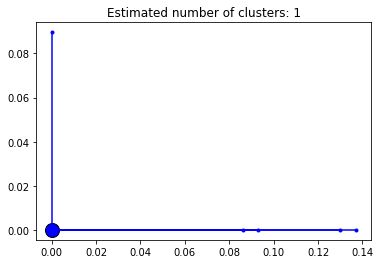

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


damping: 0.8, max_iter: 200, convergence: 30, preference: None
Estimated number of clusters: 180


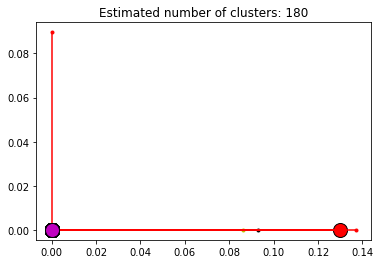

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 82:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 83:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 84:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'proposed')


Cluster 85:
('model', 'graphical', 'data', 'network', 'problem', 'method', 'gaussian', 'graph', 'node', 'lasso')


Cluster 86:
('patient', 'model', 'time', 'data', 'image', 'disease', 'risk', 'clinical', 'learning', 'mri')


Cluster 87:
('spurious', 'model', 'valley', 'local', 'recovery', 'fit', 'minimum', 'discovery', 'dimension', 'point')


Cluster 88:
('data', 'decision', 'objective', 'pomdps', 'function', 'information', 'analysis', 'solution', 'optimal', 'jl')


Cluster 89:
(

('convergence', 'stochastic', 'sgd', 'algorithm', 'gradient', 'function', 'method', 'problem', 'learning', 'rate')


Cluster 153:
('state', 'reservoir', 'system', 'input', 'memory', 'space', 'time', 'fading', 'filter', 'feature')


Cluster 154:
('image', 'convolutional', 'invariance', 'network', 'information', 'representation', 'model', 'data', 'neural', 'patch')


Cluster 155:
('constraint', 'algorithm', 'problem', 'convex', 'time', 'optimization', 'regret', 'online', 'set', 'pesc')


Cluster 156:
('regression', 'modal', 'loss', 'learning', 'model', 'symbolic', 'correntropy', 'risk', 'dynamical', 'mmsr')


Cluster 157:
('factor', 'data', 'outcome', 'principal', 'marginal', 'analysis', 'model', 'curve', 'latent', 'correlated')


Cluster 158:
('data', 'bayesian', 'inference', 'approximation', 'ep', 'framework', 'model', 'imaging', 'correction', 'method')


Cluster 159:
('interaction', 'high', 'data', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'problem', 'matrix')


C

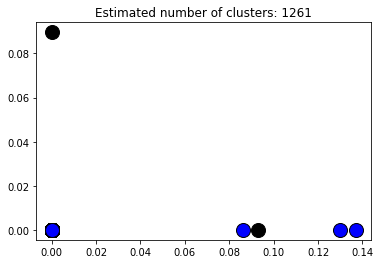

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'learning', 'lmm', 'based', 'data', 'edge', 'algorithm', 'criterion', 'network', 'skeleton')


Cluster 123:
('dimension', 'similarity', 'independent', 'algorithm', 'computation', 'data', 'jaccard', 'large', 'result', 'twitter')


Cluster 124:
('model', 'sign', 'handshape', 'signer', 'affine', 'hand', 'aff', 'appearance', 'approach', 'classification')


Cluster 125:
('method', 'model', 'nonparametric', 'variable', 'learning', 'problem', 'proposed', 'regularization', 'selection', 'show')


Cluster 126:
('matrix', 'cluster', 'similarity', 'clustering', 'factorization', 'given', 'based', 'left', 'stochastic', 'algorithm')


Cluster 127:
('consistent', 'convergence', 'maximum', 'unfolding', 'variance', 'assumption', 'convex', 'dimensionality', 'e

('prior', 'model', 'parameter', 'approach', 'nn', 'scale', 'hierarchical', 'network', 'relevance', 'using')


Cluster 239:
('data', 'missing', 'algorithm', 'imputation', 'likelihood', 'observed', 'alternating', 'dimensional', 'high', 'log')


Cluster 240:
('network', 'neural', 'dropout', 'overfitting', 'large', 'different', 'learning', 'many', 'net', 'number')


Cluster 241:
('question', 'concept', 'factor', 'learning', 'analytics', 'estimate', 'solution', 'underlying', 'analysis', 'based')


Cluster 242:
('graph', 'distribution', 'acyclic', 'additive', 'causal', 'directed', 'independence', 'method', 'model', 'noise')


Cluster 243:
('image', 'mixture', 'model', 'patch', 'prior', 'based', 'coding', 'comparable', 'compression', 'easily')


Cluster 244:
('chain', 'markov', 'inference', 'mcmc', 'distribution', 'sampling', 'advantage', 'approximation', 'carlo', 'core')


Cluster 245:
('cost', 'classifier', 'feature', 'test', 'cascade', 'time', 'algorithm', 'input', 'tree', 'accuracy')


Cl

('clustering', 'measure', 'axiom', 'elementary', 'hierarchical', 'notion', 'set', 'user', 'without', 'additivity')


Cluster 349:
('graph', 'bound', 'labelings', 'online', 'problem', 'algorithm', 'labeling', 'latent', 'predicting', 'prediction')


Cluster 350:
('example', 'information', 'student', 'learning', 'privileged', 'teacher', 'describes', 'intelligent', 'knowledge', 'paper')


Cluster 351:
('alexey', 'bibliography', 'chervonenkis', 'comment', 'introductory')


Cluster 352:
('alexey', 'bibliography', 'chervonenkis')


Cluster 353:
('system', 'learning', 'machine', 'common', 'computing', 'delay', 'demonstrate', 'descent', 'encoding', 'far')


Cluster 354:
('beamformers', 'meg', 'vector', 'beamforming', 'proposed', 'activity', 'case', 'covariance', 'data', 'dimension')


Cluster 355:
('data', 'set', 'different', 'combine', 'constraint', 'algorithm', 'causal', 'intervention', 'model', 'overlapping')


Cluster 356:
('entropy', 'function', 'cone', 'proper', 'rule', 'scoring', 'space'

('learning', 'regularization', 'iterative', 'consider', 'convex', 'function', 'loss', 'new', 'achieved', 'algorithm')


Cluster 475:
('network', 'community', 'detection', 'internet', 'overlapping', 'scale', 'approach', 'inference', 'latent', 'million')


Cluster 476:
('risk', 'patient', 'model', 'stratification', 'learning', 'time', 'admission', 'outcome', '000', 'approach')


Cluster 477:
('component', 'framework', 'learning', 'task', 'feature', 'formulation', 'multitask', 'new', 'study', 'two')


Cluster 478:
('learning', 'multitask', 'representation', 'task', 'method', 'data', 'feature', 'independent', 'learn', 'space')


Cluster 479:
('variable', 'model', 'selection', 'method', 'gradient', 'informative', 'proposed', 'assumption', 'example', 'free')


Cluster 480:
('lmrl2', 'game', 'learning', 'stochastic', 'algorithm', 'cooperative', 'discus', 'independent', 'learner', 'lenient')


Cluster 481:
('breast', 'cancer', 'risk', 'structure', 'feature', 'mammography', 'method', 'predictio

('approach', 'chunk', 'learning', 'local', 'rate', 'svm', 'svms', 'computational', 'localized', 'method')


Cluster 582:
('risk', 'bipartite', 'class', 'probability', 'ranking', 'study', 'estimation', 'loss', 'analysis', 'based')


Cluster 583:
('factor', 'model', 'structured', 'observation', 'analysis', 'bayesian', 'data', 'dimensional', 'feature', 'latent')


Cluster 584:
('auction', 'advertiser', 'value', 'bid', 'environment', 'problem', 'active', 'ad', 'advertising', 'click')


Cluster 585:
('wavelet', 'analysis', 'decomposition', 'forest', 'function', 'random', 'sparse', 'application', 'approach', 'approximation')


Cluster 586:
('matching', 'treatment', 'effect', 'group', 'based', 'causal', 'data', 'inference', 'information', 'mi')


Cluster 587:
('rank', 'spearman', 'list', 'multivariate', 'aggregation', 'correlation', 'missing', 'ranked', 'aggregating', 'best')


Cluster 588:
('link', 'model', 'network', 'nonparametric', 'prediction')


Cluster 589:
('spurious', 'fit', 'model',

('boolean', 'case', 'curriculum', 'feature', 'minimum', 'network', 'selection', 'set', 'study', 'target')


Cluster 725:
('distributed', 'dual', 'al', 'data', 'et', 'accelerated', 'coordinate', 'dadm', 'formulation', 'loss')


Cluster 726:
('order', 'method', 'second', 'learning', 'machine', 'optimization', 'stochastic', 'time', 'cost', 'first')


Cluster 727:
('regression', 'bias', 'distributed', 'learning', 'algorithm', 'base', 'data', 'kernel', 'network', 'regularization')


Cluster 728:
('optimization', 'search', 'gradient', 'line', 'probabilistic', 'stochastic', 'descent', 'deterministic', 'ha', 'method')


Cluster 729:
('assumption', 'instrumental', 'variable', 'causal', 'effect', 'method', 'possible', 'data', 'gaussianity', 'learning')


Cluster 730:
('algorithm', 'time', 'gtc', 'constraint', 'event', 'scalar', 'set', 'temporal', 'graph', 'gtcs')


Cluster 731:
('distributed', 'method', 'round', 'algorithm', 'class', 'communication', 'subset', 'number', 'setting', 'accelerated')

('subspace', 'problem', 'dimension', 'dpcp', 'approach', 'convex', 'data', 'dual', 'inlier', 'linear')


Cluster 838:
('papg', 'algorithm', 'point', 'prove', 'proximal', 'asynchronous', 'bound', 'communication', 'condition', 'convex')


Cluster 839:
('strategy', 'bound', 'optimal', 'bandit', 'confidence', 'constant', 'factor', 'finite', 'regret', 'time')


Cluster 840:
('thundersvm', 'svms', 'libsvm', 'svm', 'class', 'classification', 'cpu', 'gpus', 'high', 'identical')


Cluster 841:
('synthetic', 'control', 'robust', 'algorithm', 'counterfactual', 'data', 'estimation', 'method', 'classical', 'demonstrate')


Cluster 842:
('sampling', 'volume', 'response', 'linear', 'point', 'square', 'least', 'regression', 'solution', 'technique')


Cluster 843:
('affine', 'fading', 'homogeneous', 'input', 'memory', 'non', 'reservoir', 'state', 'time', 'class')


Cluster 844:
('nonlinear', 'deep', 'dynamic', 'equation', 'network', 'approach', 'differential', 'help', 'learning', 'partial')


Cluster 8

('matrix', 'time', 'algorithm', 'running', 'improved', 'optimal', 'problem', 'space', 'consider', 'direction')


Cluster 947:
('method', 'convergence', 'first', 'order', 'second', 'art', 'direction', 'empirical', 'global', 'linear')


Cluster 948:
('method', 'performance', 'kernel', 'recognition', 'speech', 'attain', 'feature', 'model', 'set', 'acoustic')


Cluster 949:
('regression', 'method', 'proposed', 'derivative', 'error', 'estimation', 'estimator', 'absolute', 'asymptotic', 'deviation')


Cluster 950:
('norm', 'bound', 'hosvd', 'perturbation', 'sup', 'tensor', 'singular', 'low', 'matrix', 'rank')


Cluster 951:
('multi', 'online', 'scale', 'auction', 'buyer', 'algorithm', 'bound', 'pricing', 'range', 'regret')


Cluster 952:
('bound', 'dimension', 'vc', 'linear', 'piecewise', 'dependence', 'function', 'network', 'number', 'prove')


Cluster 953:
('learning', 'finite', 'kernel', 'problem', 'representer', 'sample', 'theorem', 'algorithm', 'deep', 'dimensional')


Cluster 954:
('co

('persistence', 'density', 'diagram', 'data', 'feature', 'kernel', 'topological', 'describe', 'diagonal', 'estimate')


Cluster 1036:
('clustering', 'algorithm', 'approximation', 'better', 'good', 'number', 'setting', 'stochastic', 'user', 'additionally')


Cluster 1037:
('function', 'non', 'problem', 'smooth', 'algorithm', 'class', 'convergence', 'convex', 'method', 'also')


Cluster 1038:
('prediction', 'uncertainty', 'algorithm', 'quantifying', 'regression', 'able', 'approach', 'based', 'bounded', 'data')


Cluster 1039:
('simpledet', 'detection', 'object', 'training', 'framework', 'model', 'distributed', 'high', 'instance', 'large')


Cluster 1040:
('graph', 'graspy', 'python', 'package', 'algorithm', 'analyzing', 'apache', 'api', 'available', 'compliant')


Cluster 1041:
('function', 'communication', 'rate', 'algorithm', 'objective', 'convergence', 'convex', 'distributed', 'network', 'non')


Cluster 1042:
('diffusion', 'clustering', 'data', 'lund', 'algorithm', 'based', 'density'

('model', 'graphical', 'parameter', 'estimator', 'inference', 'consistent', 'literature', 'statistical', 'allows', 'constant')


Cluster 1149:
('metropolized', 'algorithm', 'bound', 'hmc', 'mixing', 'carlo', 'monte', 'step', 'time', 'chain')


Cluster 1150:
('dkrr', 'learning', 'communication', 'distributed', 'optimal', 'performance', 'experiment', 'generalization', 'kernel', 'rate')


Cluster 1151:
('test', 'parallelism', 'nonparametric', 'minimax', 'proposed', 'distribution', 'study', 'anova', 'application', 'applied')


Cluster 1152:
('cornac', 'multimodal', 'recommender', 'auxiliary', 'data', 'framework', 'item', 'model', 'python', 'system')


Cluster 1153:
('algorithm', 'learning', 'pydml', 'classifier', 'distance', 'library', 'metric', 'nearest', 'provides', 'also')


Cluster 1154:
('covariance', 'estimate', 'rank', 'loss', 'one', 'portfolio', 'risk', 'asset', 'control', 'estimation')


Cluster 1155:
('space', 'framework', 'output', 'prediction', 'structured', 'algorithmic', 'gen

('optimization', 'qm', 'asynchronous', 'saga', 'stochastic', 'convex', 'framework', 'algorithm', 'gradient', 'non')


Cluster 1241:
('bag', 'instance', 'learning', 'multi', 'function', 'graph', 'approach', 'network', 'classification', 'interpreting')


Cluster 1242:
('explanation', 'model', 'cens', 'prediction', 'also', 'accurate', 'case', 'contextual', 'data', 'hoc')


Cluster 1243:
('method', 'conic', 'optimization', 'quadratic', 'state', 'available', 'based', 'better', 'case', 'condition')


Cluster 1244:
('learning', 'model', 'feature', 'successor', 'based', 'input', 'agent', 'free', 'reinforcement', 'state')


Cluster 1245:
('column', 'bound', 'error', 'selection', 'algorithm', 'approximation', 'feature', 'small', 'subset', 'art')


Cluster 1246:
('exploration', 'problem', 'lq', 'continuous', 'control', 'entropy', 'exploitation', 'gaussian', 'learning', 'classical')


Cluster 1247:
('algorithm', 'gradient', 'statistical', 'stochastic', 'analysis', 'asymptotic', 'descent', 'behavio

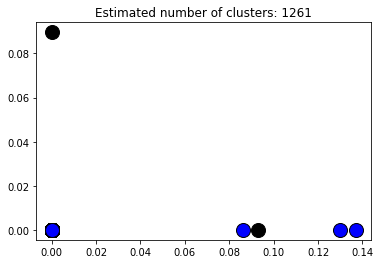

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('symbolic', 'dynamical', 'mmsr', 'system', 'expression', 'hybrid', 'learning', 'mathematical', 'modal', 'multi')


Cluster 109:
('based', 'feature', 'toolkit', 'collaborative', 'svdfeature', 'designed', 'factorization', 'filtering', 'information', 'allows')


Cluster 110:
('cpms', 'method', 'iteration', 'multivariate', 'performance', 'problem', 'smoothing', 'accurate', 'measure', 'optimizing')


Cluster 111:
('detection', 'attack', 'anomaly', 'bound', 'learning', 'analysis', 'centroid', 'issue', 'security', 'attacker')


Cluster 112:
('relational', 'exploration', 'model', 'context', 'count', 'domain', 'learning', 'problem', 'reinforcement', 'state')


Cluster 113:
('manifold', 'regularization', 'supervised', 'example', 'learning', 'result', 'semi', 'algorithm', 'analysis', 'labeled')


Cluster 114:
('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selectio

('model', 'disorder', 'psychiatric', 'among', 'comorbidity', 'data', 'latent', 'analysis', 'database', 'discrete')


Cluster 222:
('matrix', 'factorization', 'ha', 'hottopixx', 'model', 'input', 'linear', 'lp', 'nonnegative', 'two')


Cluster 223:
('adahedge', 'case', 'ftl', 'guarantee', 'worst', 'flipflop', 'loss', 'method', 'regret', 'constant')


Cluster 224:
('search', 'space', 'structured', 'function', 'output', 'approach', 'cost', 'prediction', 'loss', 'procedure')


Cluster 225:
('feature', 'selection', 'data', 'method', 'paradigm', 'proposed', 'approach', 'based', 'big', 'dimensional')


Cluster 226:
('boosting', 'example', 'method', 'training', 'algorithm', 'feature', 'sampling', 'adaptive', 'case', 'computer')


Cluster 227:
('manifold', 'manopt', 'matlab', 'optimization', 'toolbox')


Cluster 228:
('time', 'process', 'change', 'covariance', 'interval', 'locally', 'mean', 'multivariate', 'smoothness', 'varying')


Cluster 229:
('convex', 'complexity', 'problem', 'algorithm', 

('learning', 'active', 'imitation', 'policy', 'reduction', 'based', 'contribution', 'effort', 'expert', 'first')


Cluster 295:
('budget', 'labeling', 'worker', 'policy', 'allocation', 'crowdsourcing', 'decision', 'instance', 'computationally', 'data')


Cluster 296:
('rank', 'low', 'sparseness', 'subproblem', 'decomposition', 'exact', 'matrix', 'pursuit', 'solution', 'structure')


Cluster 297:
('summary', 'statistical', 'topological', 'data', 'landscape', 'number', 'persistence', 'space', 'standard', 'used')


Cluster 298:
('automaton', 'framework', 'learning', 'link', 'model', 'multiplicity', 'observable', 'operator', 'predictive', 'representation')


Cluster 299:
('samoa', 'advanced', 'algorithm', 'analysis', 'data', 'distributed', 'massive', 'mining', 'online', 'scalable')


Cluster 300:
('learning', 'sequential', 'complexity', 'online', 'learnability', 'measure', 'prediction', 'problem', 'setting', 'several')


Cluster 301:
('gesture', 'component', 'character', 'kinect', 'layer',

('tree', 'package', 'method', 'model', 'along', 'available', 'dedicated', 'leaf', 'originally', 'party')


Cluster 403:
('fixed', 'bandit', 'complexity', 'setting', 'confidence', 'model', 'armed', 'budget', 'lemma', 'two')


Cluster 404:
('asymptotic', 'bound', 'dictionary', 'learning', 'multiscale', 'non', 'robustness')


Cluster 405:
('time', 'series', 'algorithm', 'assumption', 'consistent', 'cluster', 'clustering', 'distribution', 'allowed', 'considered')


Cluster 406:
('ensemble', 'base', 'learner', 'method', 'prediction', 'accuracy', 'aggregate', 'diversity', 'individual', 'learning')


Cluster 407:
('test', 'algorithm', 'comparison', 'multiple', 'rank', 'mean', 'depends', 'outcome', 'pool', 'significant')


Cluster 408:
('feature', 'rate', 'bound', 'dimension', 'estimator', 'matching', 'minimax', 'noise', 'problem', 'case')


Cluster 409:
('algorithm', 'step', 'data', 'sequence', 'size', 'dynamic', 'gradient', 'langevin', 'proposal', 'set')


Cluster 410:
('task', 'intermediate

('bound', 'method', 'sampling', 'error', 'result', 'algorithm', 'empirical', 'learning', 'machine', 'matrix')


Cluster 513:
('algorithm', 'network', 'markov', 'mbr', 'bayesian', 'blanket', 'convergence', 'learning', 'probability', 'structure')


Cluster 514:
('efficient', 'exploration', 'convex', 'set', 'spanner', 'algorithm', 'bandit', 'design', 'experiment', 'general')


Cluster 515:
('carlo', 'discrepancy', 'kernel', 'monte', 'feature', 'map', 'qmc', 'sequence', 'approximation', 'based')


Cluster 516:
('model', 'output', 'data', 'dynamical', 'multi', 'system', 'dependent', 'variational', 'gaussian', 'gp')


Cluster 517:
('noise', 'model', 'signal', 'latent', 'regression', 'multiple', 'assumption', 'data', 'dimensional', 'factor')


Cluster 518:
('factor', 'dantzig', 'ha', 'logarithmic', 'method', 'sample', 'selector', 'size', 'accuracy', 'constrained')


Cluster 519:
('optimization', 'bound', 'lower', 'algorithm', 'convex', 'dimensionality', 'framework', 'natural', 'novel', 'polyn

('bound', 'loss', 'order', 'regret', 'different', 'gain', 'optimal', 'classical', 'decision', 'fundamentally')


Cluster 613:
('fdm', 'descent', 'method', 'rc', 'feasible', 'framework', 'problem', 'randomized', 'algorithm', 'assumption')


Cluster 614:
('lasso', 'scheme', 'algorithm', 'fast', 'guarantee', 'method', 'novel', 'oracle', 'parameter', 'regression')


Cluster 615:
('lpcc', 'algorithm', 'latent', 'data', 'learning', 'cluster', 'comparison', 'graph', 'part', 'set')


Cluster 616:
('algorithm', 'hierarchical', 'based', 'linkage', 'class', 'clustering', 'popular', 'property', 'prove', 'bisecting')


Cluster 617:
('disease', 'model', 'marker', 'clinical', 'complex', 'make', 'time', 'approach', 'chronic', 'data')


Cluster 618:
('svm', 'norm', 'coefficient', 'high', 'dimension', 'error', 'feature', 'rate', 'ultra', 'bound')


Cluster 619:
('inference', 'learning', 'training', 'variable', 'conditional', 'field', 'objective', 'random', 'algorithm', 'computational')


Cluster 620:
('

('model', 'network', 'constraint', 'iterative', 'mip', 'order', 'problem', 'topological', 'algorithm', 'based')


Cluster 711:
('control', 'dynamic', 'learning', 'stability', 'controller', 'gaussian', 'gp', 'process', 'result', 'acting')


Cluster 712:
('algorithm', 'bound', 'gradient', 'regression', 'term', 'condition', 'consider', 'dimension', 'error', 'initial')


Cluster 713:
('classification', 'class', 'label', 'procedure', 'set', 'expected', 'number', 'risk', 'size', 'confidence')


Cluster 714:
('item', 'setting', 'ranked', 'list', 'feedback', 'learner', 'ranking', 'top', 'online', 'relevance')


Cluster 715:
('approximation', 'point', 'pseudo', 'framework', 'new', 'power', 'data', 'ep', 'gaussian', 'method')


Cluster 716:
('stochastic', 'asc', 'composition', 'pg', 'gradient', 'method', 'algorithm', 'first', 'optimization', 'problem')


Cluster 717:
('bayesian', 'distributed', 'learning', 'posterior', 'snep', 'data', 'server', 'across', 'algorithm', 'carlo')


Cluster 718:
('di

('corrupted', 'label', 'learning', 'theory')


Cluster 817:
('algorithm', 'stream', 'pool', 'setting', 'based', 'element', 'select', 'interactive', 'precognitive', 'bound')


Cluster 818:
('distributed', 'framework', 'convex', 'efficient', 'general', 'non', 'cocoa', 'communication', 'datasets', 'ha')


Cluster 819:
('process', 'bound', 'empirical', 'probability', 'series', 'tail', 'time', 'class', 'condition', 'dependence')


Cluster 820:
('cluster', 'likelihood', 'response', 'variable', 'algorithm', 'penalized', 'regression', 'binomial', 'method', 'penalty')


Cluster 821:
('kernel', 'distance', 'hsic', 'independence', 'mmd', 'product', 'tensor', 'characteristic', 'statistic', 'also')


Cluster 822:
('list', 'rule', 'optimal', 'data', 'categorical', 'interpretable', 'produce', 'risk', 'according', 'accurate')


Cluster 823:
('singularity', 'network', 'learning', 'rbf', 'dynamic', 'result', 'analysis', 'dimensional', 'elimination', 'feedforward')


Cluster 824:
('algorithm', 'greedy', 

('data', 'sdm', 'netsdm', 'semantic', 'background', 'knowledge', 'mining', 'network', 'rule', 'algorithm')


Cluster 926:
('classifier', 'rejection', 'disagreement', 'algorithm', 'called', 'fast', 'pc', 'rate', 'active', 'coefficient')


Cluster 927:
('model', 'bipartite', 'community', 'addition', 'covariates', 'data', 'degree', 'detection', 'fitting', 'matched')


Cluster 928:
('policy', 'problem', 'cost', 'index', 'observation', 'optimal', 'posterior', 'threshold', 'time', 'variance')


Cluster 929:
('graph', 'algorithm', 'flow', 'min', 'problem', 'sum', 'walk', 'analyze', 'defined', 'framework')


Cluster 930:
('method', 'subspace', 'condition', 'deterministic', 'gradient', 'recovery', 'size', 'underlying', 'achieves', 'ambient')


Cluster 931:
('problem', 'sparse', 'optimization', 'approximately', 'class', 'function', 'hardness', 'loss', 'np', 'penalty')


Cluster 932:
('method', 'accuracy', 'dimension', 'randomized', 'cost', 'bootstrap', 'computation', 'error', 'general', 'given')

('persistence', 'density', 'diagram', 'data', 'feature', 'kernel', 'topological', 'describe', 'diagonal', 'estimate')


Cluster 1036:
('clustering', 'algorithm', 'approximation', 'better', 'good', 'number', 'setting', 'stochastic', 'user', 'additionally')


Cluster 1037:
('function', 'non', 'problem', 'smooth', 'algorithm', 'class', 'convergence', 'convex', 'method', 'also')


Cluster 1038:
('prediction', 'uncertainty', 'algorithm', 'quantifying', 'regression', 'able', 'approach', 'based', 'bounded', 'data')


Cluster 1039:
('simpledet', 'detection', 'object', 'training', 'framework', 'model', 'distributed', 'high', 'instance', 'large')


Cluster 1040:
('graph', 'graspy', 'python', 'package', 'algorithm', 'analyzing', 'apache', 'api', 'available', 'compliant')


Cluster 1041:
('function', 'communication', 'rate', 'algorithm', 'objective', 'convergence', 'convex', 'distributed', 'network', 'non')


Cluster 1042:
('diffusion', 'clustering', 'data', 'lund', 'algorithm', 'based', 'density'

('metropolized', 'algorithm', 'bound', 'hmc', 'mixing', 'carlo', 'monte', 'step', 'time', 'chain')


Cluster 1150:
('dkrr', 'learning', 'communication', 'distributed', 'optimal', 'performance', 'experiment', 'generalization', 'kernel', 'rate')


Cluster 1151:
('test', 'parallelism', 'nonparametric', 'minimax', 'proposed', 'distribution', 'study', 'anova', 'application', 'applied')


Cluster 1152:
('cornac', 'multimodal', 'recommender', 'auxiliary', 'data', 'framework', 'item', 'model', 'python', 'system')


Cluster 1153:
('algorithm', 'learning', 'pydml', 'classifier', 'distance', 'library', 'metric', 'nearest', 'provides', 'also')


Cluster 1154:
('covariance', 'estimate', 'rank', 'loss', 'one', 'portfolio', 'risk', 'asset', 'control', 'estimation')


Cluster 1155:
('space', 'framework', 'output', 'prediction', 'structured', 'algorithmic', 'general', 'implicit', 'loss', 'problem')


Cluster 1156:
('causal', 'jci', 'data', 'discovery', 'algorithm', 'different', 'implementation', 'appro

damping: 0.8, max_iter: 400, convergence: 8, preference: None
Estimated number of clusters: 181


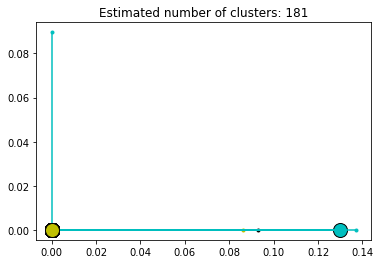

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 84:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 85:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'proposed')


Cluster 86:
('model', 'graphical', 'data', 'network', 'problem', 'method', 'gaussian', 'graph', 'node', 'lasso')


Cluster 87:
('patient', 'model', 'time', 'data', 'image', 'disease', 'risk', 'clinical', 'learning', 'mri')


Cluster 88:
('spurious', 'model', 'valley', 'local', 'recovery', 'fit', 'minimum', 'discovery', 'dimension', 'point')


Cluster 89:
('data', 'decision', 'objective', 'pomdps', 'function', 'information', 'analysis', 'solution', 'optimal', 'jl')


Cluster 90:
('classifier', 'error', 'type', 'np', 'classification', 'oracle', 'class', 'neyman', 'pearson', 'inequality')


Cluster 91:
('method', '

Estimated number of clusters: 1261


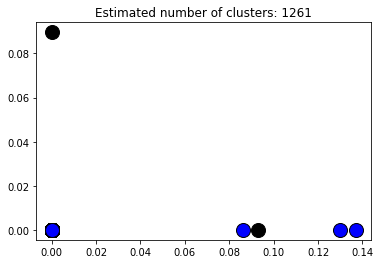

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'l

('boosting', 'example', 'method', 'training', 'algorithm', 'feature', 'sampling', 'adaptive', 'case', 'computer')


Cluster 227:
('manifold', 'manopt', 'matlab', 'optimization', 'toolbox')


Cluster 228:
('time', 'process', 'change', 'covariance', 'interval', 'locally', 'mean', 'multivariate', 'smoothness', 'varying')


Cluster 229:
('convex', 'complexity', 'problem', 'algorithm', 'descent', 'dual', 'method', 'optimization', 'strongly', 'applied')


Cluster 230:
('model', 'sparse', 'markov', 'covariance', 'independence', 'matrix', 'data', 'dimensional', 'gaussian', 'high')


Cluster 231:
('step', 'algorithm', 'hmc', 'method', 'nut', 'carlo', 'monte', 'parameter', 'random', 'sampler')


Cluster 232:
('jackknife', 'ij', 'replicates', 'bootstrap', 'estimate', 'study', 'bagged', 'bagging', 'estimator', 'forest')


Cluster 233:
('ranking', 'regret', 'bipartite', 'loss', 'bound', 'proper', 'term', 'pairwise', 'surrogate', '2011')


Cluster 234:
('linear', 'model', 'rate', 'regression', 'achi

('iteration', 'algorithm', 'policy', 'approximate', 'mpi', 'value', 'analysis', 'dp', 'tetri', 'approximation')


Cluster 339:
('issue', 'preface', 'special')


Cluster 340:
('equation', 'method', 'inference', 'matrix', 'solving', 'statistical', 'operator', 'problem', 'rigorous', 'solution')


Cluster 341:
('learning', 'poem', 'risk', 'ad', 'bandit', 'counterfactual', 'crm', 'feedback', 'minimization', 'principle')


Cluster 342:
('distance', 'bound', 'matrix', 'density', 'quantum', 'rank', 'entropy', 'estimation', 'low', 'lower')


Cluster 343:
('condition', 'learning', 'fast', 'central', 'rate', 'mixability', 'statistical', 'algorithm', 'online', 'show')


Cluster 344:
('asymptotic', 'regression', 'estimate', 'function', 'normality', 'variance', 'depends', 'dimension', 'explicitly', 'functional')


Cluster 345:
('oracle', 'inequality', 'aggregation', 'bound', 'convex', 'improvement', 'obtain', 'previous', 'regression', 'result')


Cluster 346:
('random', 'graph', 'process', 'deviatio

('information', 'analysis', 'sampling', 'theoretic', 'thompson', 'across', 'action', 'applies', 'bound', 'broad')


Cluster 466:
('regression', 'feature', 'compression', 'large', 'random', 'approach', 'conditionally', 'distribution', 'gaussian', 'manifold')


Cluster 467:
('loss', 'algorithm', 'boosting', 'class', 'fisher', 'function', 'proposed', 'al', 'application', 'consistent')


Cluster 468:
('sum', 'formulation', 'path', 'covariance', 'model', 'arbitrary', 'graphical', 'matrix', 'gaussian', 'topology')


Cluster 469:
('gesture', 'recognition', 'available', 'challenge', 'multimodal', 'art', 'camera', 'data', 'including', 'overview')


Cluster 470:
('td', 'method', 'parameter', 'step', 'update', 'difference', 'different', 'emphasizing', 'emphatic', 'function')


Cluster 471:
('auction', 'price', 'reserve', 'revenue', 'problem', 'algorithm', 'learning', 'second', 'analysis', 'cast')


Cluster 472:
('coordinate', 'data', 'big', 'descent', 'iteration', 'method', 'node', 'partition', '

('allocation', 'reward', 'bandit', 'estimation', 'performance', 'problem', 'strategy', 'covariates', 'function', 'important')


Cluster 541:
('consistency', 'pca', 'framework', 'size', 'among', 'general', 'spike', 'analysis', 'asymptotic', 'component')


Cluster 542:
('ci', 'condition', 'cpds', 'ic', 'parameter', 'constraint', 'algorithmic', 'conditional', 'faithfulness', 'independence')


Cluster 543:
('distribution', 'regression', 'kernel', 'sampled', 'consistency', 'estimation', 'learning', 'problem', 'stage', 'al')


Cluster 544:
('nesterov', 'ode', 'scheme', 'accelerated', 'differential', 'equation', 'gradient', 'method', 'rate', 'algorithm')


Cluster 545:
('combinatorial', 'efficient', 'fpl', 'importance', 'online', 'optimization', 'performance', 'wa', 'algorithm', 'bandit')


Cluster 546:
('norm', 'box', 'spectral', 'support', 'learning', 'multitask', 'provide', 'regularizer', 'al', 'centered')


Cluster 547:
('density', 'minimum', 'approach', 'classification', 'cluster', 'clus

('loss', 'multiclass', 'composite', 'proper', 'representation', 'function', 'result', 'show', 'binary', 'characterise')


Cluster 608:
('lpcc', 'latent', 'part', 'cluster', 'graph', 'pcc', 'true', 'algorithm', 'comparison', 'data')


Cluster 609:
('multiclass', 'problem', 'existing', 'method', 'gensvm', 'optimization', 'algorithm', 'dual', 'generalized', 'large')


Cluster 610:
('informative', 'sampling', 'cluster', 'outlier', 'survey', 'approach', 'design', 'extend', 'method', 'scalable')


Cluster 611:
('method', 'newton', 'hessian', 'mdps', 'approximate', 'algorithm', 'gauss', 'policy', 'ascent', 'convergence')


Cluster 612:
('bound', 'loss', 'order', 'regret', 'different', 'gain', 'optimal', 'classical', 'decision', 'fundamentally')


Cluster 613:
('fdm', 'descent', 'method', 'rc', 'feasible', 'framework', 'problem', 'randomized', 'algorithm', 'assumption')


Cluster 614:
('lasso', 'scheme', 'algorithm', 'fast', 'guarantee', 'method', 'novel', 'oracle', 'parameter', 'regression')


('fisher', 'probability', 'consistency', 'prior', 'adjusted', 'algorithm', 'cde', 'class', 'consistent', 'count')


Cluster 708:
('bag', 'openxbow', 'toolkit', 'word', 'feature', 'input', 'acoustic', 'bow', 'classification', 'crossmodal')


Cluster 709:
('rank', 'given', 'tensor', 'completion', 'matrix', 'bound', 'data', 'low', 'view', 'probability')


Cluster 710:
('model', 'network', 'constraint', 'iterative', 'mip', 'order', 'problem', 'topological', 'algorithm', 'based')


Cluster 711:
('control', 'dynamic', 'learning', 'stability', 'controller', 'gaussian', 'gp', 'process', 'result', 'acting')


Cluster 712:
('algorithm', 'bound', 'gradient', 'regression', 'term', 'condition', 'consider', 'dimension', 'error', 'initial')


Cluster 713:
('classification', 'class', 'label', 'procedure', 'set', 'expected', 'number', 'risk', 'size', 'confidence')


Cluster 714:
('item', 'setting', 'ranked', 'list', 'feedback', 'learner', 'ranking', 'top', 'online', 'relevance')


Cluster 715:
('approx

('algorithm', 'greedy', 'submodularity', 'approximation', 'ratio', 'application', 'selection', 'set', 'analysis', 'analyze')


Cluster 825:
('state', 'clinical', 'data', 'patient', 'time', 'hasmm', 'model', 'care', 'ehr', 'markov')


Cluster 826:
('bootstrap', 'give', 'regression', 'dimension', 'high', 'method', 'conservative', 'consider', 'estimate', 'grows')


Cluster 827:
('rsg', 'local', 'method', 'problem', 'bound', 'property', 'set', 'sg', 'complexity', 'condition')


Cluster 828:
('gp', 'approach', 'local', 'prediction', 'region', 'regression', 'response', 'boundary', 'datasets', 'input')


Cluster 829:
('posterior', 'data', 'subset', 'distribution', 'full', 'method', 'sample', 'sampling', 'across', 'approach')


Cluster 830:
('experience', 'replay', 'control', 'learning', 'method', 'reinforcement', 'replayed', 'buffer', 'choice', 'exploration')


Cluster 831:
('condition', 'sdar', 'error', 'iteration', 'solution', 'approach', 'high', 'algorithm', 'bound', 'certain')


Cluster 8

('kernel', 'sequence', 'data', 'domain', 'ordered', 'path', 'sequentialized', 'algorithm', 'arise', 'associated')


Cluster 925:
('data', 'sdm', 'netsdm', 'semantic', 'background', 'knowledge', 'mining', 'network', 'rule', 'algorithm')


Cluster 926:
('classifier', 'rejection', 'disagreement', 'algorithm', 'called', 'fast', 'pc', 'rate', 'active', 'coefficient')


Cluster 927:
('model', 'bipartite', 'community', 'addition', 'covariates', 'data', 'degree', 'detection', 'fitting', 'matched')


Cluster 928:
('policy', 'problem', 'cost', 'index', 'observation', 'optimal', 'posterior', 'threshold', 'time', 'variance')


Cluster 929:
('graph', 'algorithm', 'flow', 'min', 'problem', 'sum', 'walk', 'analyze', 'defined', 'framework')


Cluster 930:
('method', 'subspace', 'condition', 'deterministic', 'gradient', 'recovery', 'size', 'underlying', 'achieves', 'ambient')


Cluster 931:
('problem', 'sparse', 'optimization', 'approximately', 'class', 'function', 'hardness', 'loss', 'np', 'penalty')


('constraint', 'process', 'linear', 'function', 'gaussian', 'set', 'approach', 'gp', 'operator', 'posterior')


Cluster 1021:
('loss', 'boosting', 'multiclass', 'algorithm', 'mcboost', 'margin', 'codewords', 'function', 'procedure', 'descent')


Cluster 1022:
('approximation', 'entropy', 'method', 'moment', 'programming', 'scheme', 'action', 'approach', 'approximate', 'approximating')


Cluster 1023:
('decentralized', 'learning', 'data', 'dictionary', 'problem', 'time', 'varying', 'convex', 'graph', 'agent')


Cluster 1024:
('aggregated', 'bayesian', 'inference', 'nonparametric', 'aggregation', 'ball', 'data', 'massive', 'obtained', 'oracle')


Cluster 1025:
('sparse', 'coding', 'double', 'algorithm', 'data', 'dictionary', 'efficient', 'first', 'high', 'learning')


Cluster 1026:
('rank', 'nonconvex', 'low', 'matrix', 'optimization', 'approximation', 'condition', 'incoherence', 'local', 'minimum')


Cluster 1027:
('ms', 'subspace', 'problem', 'sample', 'minimal', 'optimization', 'algor

Cluster 1116:
('kernel', 'least', 'machine', 'regression', 'square', 'algorithm', 'approximation', 'conjugate', 'gaussian', 'gradient')


Cluster 1117:
('training', 'co', 'view', 'instance', 'multi', 'strategy', 'algorithm', 'optimization', 'process', 'pseudo')


Cluster 1118:
('gradient', 'function', 'network', 'node', 'step', 'asymptotically', 'asynchronous', 'convex', 'distributed', 'message')


Cluster 1119:
('component', 'non', 'local', 'principal', 'rpca', 'solution', 'global', 'negative', 'number', 'rank')


Cluster 1120:
('scattering', 'kymatio', 'learning', 'package', 'python', 'signal', 'transform', 'transforms', '1d', '2d')


Cluster 1121:
('landscape', 'persistence', 'multiparameter', 'stable', 'analysis', 'data', 'distance', 'invariant', 'module', 'rank')


Cluster 1122:
('method', 'matching', 'gom', 'optimal', 'consistency', 'kom', 'robust', 'causal', 'data', 'doubly')


Cluster 1123:
('dictionary', 'reference', 'learning', 'local', 'minimum', 'sharp', 'combination', 'fun

('convex', 'approach', 'non', 'class', 'estimation', 'estimator', 'label', 'problem', 'setting', 'conditional')


Cluster 1222:
('ridge', 'penalty', 'high', 'dimensional', 'model', 'negative', 'optimal', 'real', 'regularization', 'case')


Cluster 1223:
('commenting', 'behavior', 'youtube', 'constraint', 'group', 'user', 'bayesian', 'inattentive', 'inverse', 'learning')


Cluster 1224:
('forest', 'random', 'model', 'regression', 'success', 'based', 'empirical', 'explanation', 'forward', 'procedure')


Cluster 1225:
('operator', 'method', 'system', 'nonlinear', 'arnoldi', 'data', 'dynamical', 'subspace', 'using', 'develop')


Cluster 1226:
('estimator', 'outcome', 'correlated', 'data', 'dimensional', 'distributed', 'high', 'learning', 'supervised', 'block')


Cluster 1227:
('dnns', 'intrinsic', 'data', 'dimensional', 'dimensionality', 'low', 'covariates', 'error', 'high', 'study')


Cluster 1228:
('bottleneck', 'network', 'neural', 'wide', 'composition', 'gaussian', 'hidden', 'layer', '

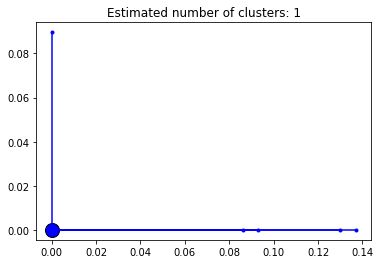

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


damping: 0.8, max_iter: 400, convergence: 15, preference: None
Estimated number of clusters: 180


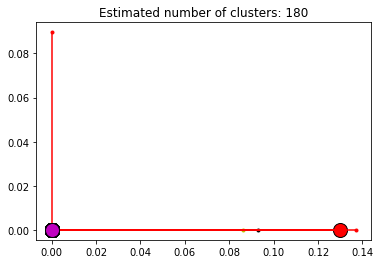

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('density', 'estimation', 'estimator', 'cluster', 'kernel', 'ridge', 'tree', 'rate', 'clustering', 'classification')


Cluster 112:
('community', 'network', 'model', 'detection', 'algorithm', 'method', 'node', 'graph', 'weighted', 'conductance')


Cluster 113:
('data', 'missing', 'imputation', 'datawig', 'value', 'impute', 'method', 'likelihood', 'observed', 'sample')


Cluster 114:
('model', 'mixture', 'side', 'information', 'matrix', 'crosscat', 'problem', 'process', 'gaussian', 'data')


Cluster 115:
('dag', 'learning', 'algorithm', 'model', 'structure', 'method', 'data', 'graph', 'order', 'bayesian')


Cluster 116:
('bootstrap', 'jackknife', 'ij', 'replicates', 'give', 'regression', 'estimate', 'study', 'show', 'variance')


Cluster 117:
('gp', 'local', 'regression', 'gaussian', 'method', 'prediction', 'region', 'process', 'approach', 'code')


Cluster 118:
('linear', 'thundergbm', 'thundersvm', 'svr', 'training', 'aesvm', 'set', 'svc', 'support', 'svms')


Cluster 119:
('estimator

('newton', 'method', 'nesterov', 'approximate', 'ode', 'algorithm', 'scheme', 'accelerated', 'hessian', 'mdps')


Cluster 177:
('kriging', 'correlation', 'canonical', 'sample', 'function', 'prediction', 'error', 'design', 'metric', 'implementation')


Cluster 178:
('criterion', 'adjustment', 'set', 'graphical', 'graph', 'otr', 'treatment', 'estimator', 'optimal', 'mean')


Cluster 179:
('tree', 'algorithm', 'model', 'mcmc', 'network', 'data', 'number', 'markov', 'learning', 'sne')


damping: 0.8, max_iter: 400, convergence: 15, preference: 50
Estimated number of clusters: 1261


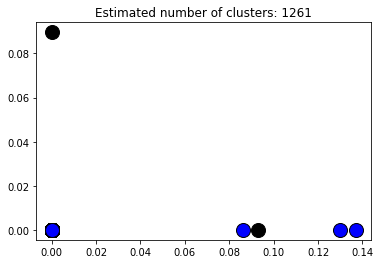

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('matrix', 'factorization', 'nmf', 'data', 'nonnegative', 'sparse', 'technique', 'based', 'ha', 'posed')


Cluster 103:
('algorithm', 'model', 'procedure', 'variable', '2010', 'al', 'causal', 'condition', 'et', 'full')


Cluster 104:
('matrix', 'approximation', 'leverage', 'algorithm', 'score', 'statistical', 'extension', 'analysis', 'application', 'coherence')


Cluster 105:
('prior', 'bound', 'bayes', 'pac', 'data', 'svm', 'algorithm', 'generalization', 'separate', 'set')


Cluster 106:
('learning', 'machine', 'framework', 'computer', 'vision', 'graphical', 'research', 'algorithm', 'application', 'component')


Cluster 107:
('convex', 'non', 'algorithm', 'optimization', 'problem', 'risk', 'learning', 'objective', 'regularized', 'function')


Cluster 108:
('symbolic', 'dynamical', 'mmsr', 'system', 'expression', 'hybrid', 'learning', 'mathematical', 'modal', 'multi')


Cluster 109:
('based', 'feature', 'toolkit', 'collaborative', 'svdfeature', 'designed', 'factorization', 'filtering',

('stochastic', 'gradient', 'logistic', 'observation', 'averaged', 'convexity', 'eigenvalue', 'generalized', 'local', 'regression')


Cluster 206:
('interaction', 'variable', 'computational', 'high', 'order', 'approach', 'class', 'data', 'informative', 'interest')


Cluster 207:
('anesthesia', 'patient', 'rl', 'control', 'human', 'specific', 'closed', 'loop', 'study', 'volunteer')


Cluster 208:
('algorithm', 'model', 'hem', 'variational', 'data', 'hmm', 'cluster', 'group', 'hidden', 'hierarchical')


Cluster 209:
('subspace', 'robust', 'convex', 'data', 'inverse', 'pca', 'recovery', 'algorithm', 'bottom', 'covariance')


Cluster 210:
('comparison', 'difference', 'evaluation', 'policy', 'survey', 'temporal')


Cluster 211:
('active', 'application', 'approximation', 'learning', 'regret', 'relative', 'smooth', 'using')


Cluster 212:
('analysis', 'nonlinear', 'source', 'feature', 'slow', 'algorithm', 'blind', 'extension', 'independent', 'mixture')


Cluster 213:
('distribution', 'natural'

('clustering', 'approach', 'based', 'consistency', 'minimisation', 'probabilistic', 'prototype', 'space', 'strong', 'applied')


Cluster 318:
('bound', 'analysis', 'bayesian', 'pac', 'extensive', 'learning', 'majority', 'mincq', 'propose', 'vote')


Cluster 319:
('algorithmic', 'leverage', 'sampling', 'based', 'data', 'method', 'result', 'leveraging', 'statistical', 'algorithm')


Cluster 320:
('matrix', 'distributed', 'factorization', 'algorithm', 'conquer', 'divide', 'framework', 'learning', 'method', 'present')


Cluster 321:
('regression', 'correntropy', 'loss', 'model', 'learning', 'induced', 'paper', 'analysis', 'associated', 'convergence')


Cluster 322:
('matrix', 'precision', 'common', 'estimation', 'multiple', 'structure', 'estimator', 'article', 'cancer', 'loss')


Cluster 323:
('lasso', 'rule', 'dual', 'inactive', 'screening', 'predictor', 'group', 'polytope', 'problem', 'set')


Cluster 324:
('cross', 'validation', 'candidate', 'computation', 'data', 'full', 'increasing', 

('regret', 'adaptive', 'algorithm', 'expert', 'fixed', 'share', 'interval', 'method', 'tracking', 'based')


Cluster 425:
('learning', 'meta', 'arrive', 'data', 'nfl', 'sacrificial', 'theorem', 'anti', 'atsd', 'machine')


Cluster 426:
('multi', 'learning', 'space', 'svm', 'vector', 'view', 'framework', 'obtained', 'valued', 'approach')


Cluster 427:
('prediction', 'computational', 'confidence', 'demonstrate', 'ensemble', 'estimator', 'feature', 'forest', 'form', 'framework')


Cluster 428:
('cluster', 'computational', 'growing', 'localization', 'number', 'planted', 'problem', 'statistical', 'submatrices', 'submatrix')


Cluster 429:
('causal', 'effect', 'linear', 'cause', 'distribution', 'inference', 'non', 'residual', 'asymmetry', 'direction')


Cluster 430:
('test', 'partition', 'size', 'based', 'consistent', 'data', 'statistic', 'detecting', 'distribution', 'free')


Cluster 431:
('sampler', 'learning', 'dag', 'graph', 'method', 'structure', 'bayesian', 'conditional', 'distributio

('automatic', 'differentiation', 'manifold', 'optimization', 'pymanopt', 'python', 'toolbox', 'using')


Cluster 530:
('crosscat', 'data', 'mixture', 'model', 'bayesian', 'method', 'modeling', 'multiple', 'nonparametric', 'paper')


Cluster 531:
('policy', 'space', 'function', 'algorithm', 'bound', 'evaluation', 'iteration', 'nonparametric', 'reg', 'work')


Cluster 532:
('covariance', 'pca', 'sparse', 'thresholding', 'via')


Cluster 533:
('image', 'label', 'large', 'level', 'learning', 'available', 'detector', 'joint', 'labeled', 'method')


Cluster 534:
('data', 'covariance', 'algorithm', 'clustering', 'functional', 'propose', 'also', 'distance', 'estimation', 'estimator')


Cluster 535:
('optimization', 'problem', 'term', 'convex', 'nonconvex', 'algorithm', 'composite', 'function', 'may', 'approach')


Cluster 536:
('method', 'online', 'true', 'learning', 'regular', 'difference', 'forward', 'sarsa', 'td', 'temporal')


Cluster 537:
('layer', 'likelihood', 'estimator', 'graphical', 

('pattern', 'temporal', 'number', 'conceptors', 'large', 'network', 'neural', 'stored', 'account', 'addressed')


Cluster 634:
('model', 'algorithm', 'classification', 'formulation', 'svm', 'various', 'given', 'method', 'unified', 'accelerated')


Cluster 635:
('learn', 'imbalanced', 'scikit', 'learning', 'method', 'sampling', 'toolbox', 'contrib', 'documentation', 'machine')


Cluster 636:
('algorithm', 'geometric', 'information', 'invariance', 'optimization', 'picture', 'principle', 'unifying', 'via')


Cluster 637:
('kernel', 'approximation', 'low', 'memory', 'rank', 'matrix', 'meka', 'structure', 'achieve', 'efficient')


Cluster 638:
('result', 'kernel', 'bound', 'feature', 'random', 'based', 'case', 'integral', 'lower', 'quadrature')


Cluster 639:
('tensor', 'model', 'power', 'analysis', 'iteration', 'component', 'latent', 'overcomplete', 'sample', 'variable')


Cluster 640:
('java', 'jsat', 'library', '2009', 'al', 'analysis', 'et', 'learning', 'machine', 'statistical')


Clust

('complex', 'embeddings', 'graph', 'matrix', 'approach', 'expressiveness', 'knowledge', 'real', 'completion', 'complexity')


Cluster 738:
('sparse', 'gradient', 'learning', 'sparsity', 'truncated', 'vector', 'weight', 'algorithm', 'better', 'convergence')


Cluster 739:
('algorithm', 'function', 'problem', 'submodular', 'total', 'variation', 'sfm', 'denoising', 'active', 'cut')


Cluster 740:
('trajectory', 'model', 'progression', 'individual', 'transformation', 'bayesian', 'change', 'cognitive', 'effect', 'estimate')


Cluster 741:
('stochastic', 'gradient', 'constant', 'sgd', 'algorithm', 'approximate', 'distribution', 'show', 'bayesian', 'descent')


Cluster 742:
('tensor', 'error', 'neuroimaging', 'response', 'analysis', 'estimation', 'non', 'regression', 'sparse', 'store')


Cluster 743:
('reward', 'learning', 'pbrl', 'preference', 'task', 'problem', 'reinforcement', 'ability', 'algorithm', 'based')


Cluster 744:
('matrix', 'data', 'singular', 'value', 'denoising', 'distributed'

('strategy', 'bound', 'optimal', 'bandit', 'confidence', 'constant', 'factor', 'finite', 'regret', 'time')


Cluster 840:
('thundersvm', 'svms', 'libsvm', 'svm', 'class', 'classification', 'cpu', 'gpus', 'high', 'identical')


Cluster 841:
('synthetic', 'control', 'robust', 'algorithm', 'counterfactual', 'data', 'estimation', 'method', 'classical', 'demonstrate')


Cluster 842:
('sampling', 'volume', 'response', 'linear', 'point', 'square', 'least', 'regression', 'solution', 'technique')


Cluster 843:
('affine', 'fading', 'homogeneous', 'input', 'memory', 'non', 'reservoir', 'state', 'time', 'class')


Cluster 844:
('nonlinear', 'deep', 'dynamic', 'equation', 'network', 'approach', 'differential', 'help', 'learning', 'partial')


Cluster 845:
('clustering', 'ensemble', 'openensembles', 'solution', 'data', 'python', 'example', 'given', 'individual', 'visualizing')


Cluster 846:
('sampling', 'importance', 'training', 'popular', 'data', 'due', 'improvement', 'magnitude', 'minibatches', 

('empirical', 'variance', 'minimization', 'performance', 'risk', 'sample', 'approach', 'convex', 'estimator', 'number')


Cluster 958:
('vertex', 'nomination', 'scheme', 'network', 'consistent', 'framework', 'interest', 'problem', 'bayes', 'corresponding')


Cluster 959:
('lasso', 'method', 'resampling', 'variable', 'datasets', 'analytic', 'computational', 'dataset', 'distributed', 'numerical')


Cluster 960:
('oracle', 'algorithm', 'linear', 'optimization', 'conditional', 'gradient', 'actual', 'also', 'achieved', 'call')


Cluster 961:
('learning', 'optimization', 'regression', 'data', 'delay', 'distributed', 'encoding', 'loss', 'node', 'redundancy')


Cluster 962:
('algorithm', 'langevin', 'method', 'optimization', 'analysis', 'new', 'non', 'asymptotic', 'convex', 'distribution')


Cluster 963:
('stopping', 'optimal', 'problem', 'deep', 'pricing', 'situation', 'three', 'accurate', 'applicable', 'approach')


Cluster 964:
('decision', 'unfairness', 'based', 'constraint', 'fair', 'fram

('classifier', 'type', 'class', 'error', 'np', 'sample', 'parametric', 'proposed', 'algorithm', 'application')


Cluster 1077:
('factor', 'data', 'likelihood', 'marginal', 'principal', 'analysis', 'component', 'correlated', 'latent', 'pca')


Cluster 1078:
('svm', 'dual', 'kernel', 'norm', 'problem', 'case', 'data', 'general', 'machine', 'original')


Cluster 1079:
('bound', 'learning', 'dimensional', 'manifold', 'perturbation', 'classical', 'isomap', 'localization', 'low', 'problem')


Cluster 1080:
('time', 'algorithm', 'heavy', 'hitter', 'private', 'running', 'user', 'local', 'locally', 'optimal')


Cluster 1081:
('data', 'inference', 'local', 'bayesian', 'method', 'approximation', 'ep', 'framework', 'prior', 'algorithm')


Cluster 1082:
('clustering', 'margin', 'maximum', 'density', 'level', 'set', 'estimate', 'function', 'point', 'solution')


Cluster 1083:
('interaction', 'detecting', 'estimator', 'hessian', 'matrix', 'principal', 'dimensional', 'high', 'method', 'problem')


Clu

('group', 'clustering', 'algorithm', 'overlap', 'estimated', 'structure', 'syncytial', 'used', 'approach', 'burst')


Cluster 1179:
('layer', 'tensor', 'activation', 'connected', 'fully', 'multilinear', 'regression', 'structure', 'contraction', 'convolutional')


Cluster 1180:
('automatic', 'model', 'sparsity', 'art', 'bisn', 'dimension', 'gradient', 'graphical', 'method', 'sparse')


Cluster 1181:
('algorithm', 'coordinate', 'submodular', 'approximation', 'function', 'continuous', 'maximization', 'monotone', 'problem', 'wise')


Cluster 1182:
('data', 'learning', 'distributed', 'unlabeled', 'dmee', 'node', 'rate', 'supervised', 'algorithm', 'error')


Cluster 1183:
('mahout', 'apache', 'dataflow', 'system', 'learning', 'machine', 'distributed', 'offering', 'scalable', 'several')


Cluster 1184:
('test', 'high', 'dimensional', 'alternative', 'parameter', 'adaptive', 'aispu', 'alzheimer', 'data', 'disease')


Cluster 1185:
('algorithm', 'system', 'adaptive', 'differential', 'convergence

damping: 0.8, max_iter: 400, convergence: 30, preference: -50
Estimated number of clusters: 1


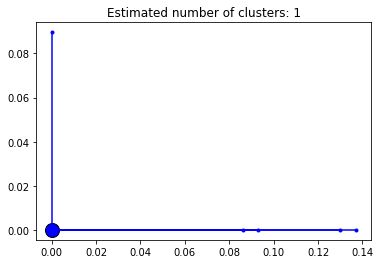

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


damping: 0.8, max_iter: 400, convergence: 30, preference: None
Estimated number of clusters: 180


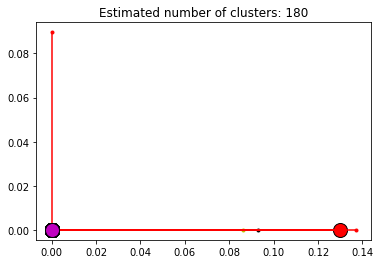

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('pal', 'pareto', 'learning', 'set', 'objective', 'design', 'policy', 'algorithm', 'mechanism', 'accuracy')


Cluster 73:
('domain', 'distribution', 'algorithm', 'target', 'adaptation', 'discrepancy', 'source', 'feature', 'sdas', 'data')


Cluster 74:
('signal', 'noise', 'latent', 'regression', 'model', 'accumulation', 'observation', 'memory', 'factor', 'data')


Cluster 75:
('dantzig', 'selector', 'sparse', 'factor', 'method', 'recovery', 'signal', 'approach', 'effect', 'exhibiting')


Cluster 76:
('control', 'learning', 'exploration', 'reinforcement', 'rl', 'problem', 'function', 'process', 'value', 'dynamic')


Cluster 77:
('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 78:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 79:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')



('hmc', 'subsampling', 'data', 'method', 'step', 'metropolized', 'estimator', 'parameter', 'algorithm', 'carlo')


Cluster 144:
('pattern', 'attribute', 'latent', 'model', 'feature', 'temporal', 'bayes', 'naive', 'weighting', 'data')


Cluster 145:
('learning', 'concept', 'private', 'sample', 'privacy', 'time', 'algorithm', 'class', 'complexity', 'method')


Cluster 146:
('risk', 'score', 'method', 'algorithm', 'learning', 'prediction', 'breast', 'structed', 'task', 'structured')


Cluster 147:
('uncertainty', 'market', 'prediction', 'set', 'approach', 'function', 'statistical', 'artificial', 'quantifying', 'loss')


Cluster 148:
('function', 'communication', 'algorithm', 'optimization', 'network', 'decentralized', 'distributed', 'model', 'problem', 'learning')


Cluster 149:
('change', 'point', 'model', 'algorithm', 'system', 'data', 'graphical', 'penalty', 'surface', 'method')


Cluster 150:
('gabp', 'algorithm', 'convergence', 'gaussian', 'definite', 'positive', 'multivariate', 'nod

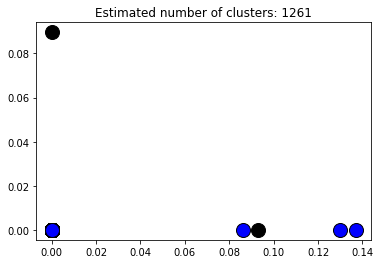

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('cpms', 'method', 'iteration', 'multivariate', 'performance', 'problem', 'smoothing', 'accurate', 'measure', 'optimizing')


Cluster 111:
('detection', 'attack', 'anomaly', 'bound', 'learning', 'analysis', 'centroid', 'issue', 'security', 'attacker')


Cluster 112:
('relational', 'exploration', 'model', 'context', 'count', 'domain', 'learning', 'problem', 'reinforcement', 'state')


Cluster 113:
('manifold', 'regularization', 'supervised', 'example', 'learning', 'result', 'semi', 'algorithm', 'analysis', 'labeled')


Cluster 114:
('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'ba

('inversion', 'lasso', 'matrix', 'scaled', 'sparse')


Cluster 176:
('selection', 'model', 'tuning', 'parameter', 'variable', 'criterion', 'data', 'fitting', 'penalized', 'regression')


Cluster 177:
('machine', 'robustness', '10', '1485', '1510', '2009', 'al', 'comment', 'et', 'journal')


Cluster 178:
('graph', 'function', 'svm', 'clique', 'common', 'labellings', 'large', 'lovã', 'multiple', 'orthogonal')


Cluster 179:
('learning', 'grammar', 'language', 'string', 'context', 'free', 'strong', 'algorithm', 'correct', 'corresponding')


Cluster 180:
('data', 'incomplete', 'label', 'reliability', 'time', 'complete', 'class', 'classify', 'given', 'goal')


Cluster 181:
('median', 'algorithm', 'approach', 'distribution', 'finding', 'however', 'hypothesis', 'map', 'one', 'present')


Cluster 182:
('norm', 'max', 'bit', 'bound', 'completion', 'constrained', 'convergence', 'estimate', 'general', 'lower')


Cluster 183:
('constraint', 'nrsample', 'program', 'synthesis', 'time', 'accuracy', '

('learning', 'active', 'imitation', 'policy', 'reduction', 'based', 'contribution', 'effort', 'expert', 'first')


Cluster 295:
('budget', 'labeling', 'worker', 'policy', 'allocation', 'crowdsourcing', 'decision', 'instance', 'computationally', 'data')


Cluster 296:
('rank', 'low', 'sparseness', 'subproblem', 'decomposition', 'exact', 'matrix', 'pursuit', 'solution', 'structure')


Cluster 297:
('summary', 'statistical', 'topological', 'data', 'landscape', 'number', 'persistence', 'space', 'standard', 'used')


Cluster 298:
('automaton', 'framework', 'learning', 'link', 'model', 'multiplicity', 'observable', 'operator', 'predictive', 'representation')


Cluster 299:
('samoa', 'advanced', 'algorithm', 'analysis', 'data', 'distributed', 'massive', 'mining', 'online', 'scalable')


Cluster 300:
('learning', 'sequential', 'complexity', 'online', 'learnability', 'measure', 'prediction', 'problem', 'setting', 'several')


Cluster 301:
('gesture', 'component', 'character', 'kinect', 'layer',

('vb', 'learning', 'pca', 'bayesian', 'dimensionality', 'performance', 'condition', 'low', 'matrix', 'perfect')


Cluster 399:
('model', 'graphical', 'distribution', 'class', 'exponential', 'family', 'estimator', 'gaussian', 'include', 'instance')


Cluster 400:
('sdas', 'mslda', 'denoising', 'learn', 'linear', 'representation', 'stacked', 'accuracy', 'autoencoders', 'benchmark')


Cluster 401:
('optimal', 'simulator', 'confidence', 'heuristic', 'interval', 'mdp', 'policy', 'two', 'approximately', 'call')


Cluster 402:
('tree', 'package', 'method', 'model', 'along', 'available', 'dedicated', 'leaf', 'originally', 'party')


Cluster 403:
('fixed', 'bandit', 'complexity', 'setting', 'confidence', 'model', 'armed', 'budget', 'lemma', 'two')


Cluster 404:
('asymptotic', 'bound', 'dictionary', 'learning', 'multiscale', 'non', 'robustness')


Cluster 405:
('time', 'series', 'algorithm', 'assumption', 'consistent', 'cluster', 'clustering', 'distribution', 'allowed', 'considered')


Cluster 

('factor', 'dantzig', 'ha', 'logarithmic', 'method', 'sample', 'selector', 'size', 'accuracy', 'constrained')


Cluster 519:
('optimization', 'bound', 'lower', 'algorithm', 'convex', 'dimensionality', 'framework', 'natural', 'novel', 'polynomial')


Cluster 520:
('control', 'approximate', 'bayesian', 'exploration', 'regression', 'approach', 'dual', 'framework', 'intractable', 'learning')


Cluster 521:
('instance', 'learning', 'bag', 'new', 'theoretical', 'function', 'algorithm', 'correctly', 'framework', 'learn')


Cluster 522:
('convex', 'algorithm', 'approachability', 'set', 'vector', 'blackwell', 'oco', 'online', 'payoff', 'along')


Cluster 523:
('covariance', 'matrix', 'inverse', 'estimator', 'proposed', 'method', 'sparse', 'conditioned', 'estimation', 'well')


Cluster 524:
('string', 'data', 'process', 'gaussian', 'gp', 'gps', 'input', 'approach', 'bayesian', 'distributed')


Cluster 525:
('pico', 'review', 'supervision', 'article', 'clinical', 'distant', 'element', 'evidence',

('pi', 'vector', 'data', 'machine', 'pd', 'persistence', 'representation', 'tool', 'discriminatory', 'equation')


Cluster 629:
('clustering', 'spectral', 'algorithm', 'based', 'local', 'pca', 'method', 'neighborhood', 'principal', 'able')


Cluster 630:
('carlo', 'monte', 'size', 'batch', 'gradient', 'algorithm', 'derive', 'model', 'proximal', 'sparse')


Cluster 631:
('privacy', 'data', 'differential', 'posterior', 'provide', 'bound', 'metric', 'sampling', 'set', 'access')


Cluster 632:
('topic', 'model', 'refinery', 'learning', 'open', 'platform', 'source', 'web', 'adapt', 'algorithm')


Cluster 633:
('pattern', 'temporal', 'number', 'conceptors', 'large', 'network', 'neural', 'stored', 'account', 'addressed')


Cluster 634:
('model', 'algorithm', 'classification', 'formulation', 'svm', 'various', 'given', 'method', 'unified', 'accelerated')


Cluster 635:
('learn', 'imbalanced', 'scikit', 'learning', 'method', 'sampling', 'toolbox', 'contrib', 'documentation', 'machine')


Cluster

('stochastic', 'gradient', 'constant', 'sgd', 'algorithm', 'approximate', 'distribution', 'show', 'bayesian', 'descent')


Cluster 742:
('tensor', 'error', 'neuroimaging', 'response', 'analysis', 'estimation', 'non', 'regression', 'sparse', 'store')


Cluster 743:
('reward', 'learning', 'pbrl', 'preference', 'task', 'problem', 'reinforcement', 'ability', 'algorithm', 'based')


Cluster 744:
('matrix', 'data', 'singular', 'value', 'denoising', 'distributed', 'estimator', 'generalized', 'lead', 'low')


Cluster 745:
('information', 'dimension', 'estimator', 'model', 'approach', 'connection', 'data', 'distance', 'intrinsic', 'random')


Cluster 746:
('slab', 'spike', 'algorithm', 'ep', 'inference', 'model', 'prior', 'problem', 'proposed', 'address')


Cluster 747:
('rwf', 'flow', 'measurement', 'wf', 'wirtinger', 'algorithm', 'incremental', 'loss', 'phase', '2015')


Cluster 748:
('rimle', 'gaussian', 'improper', 'likelihood', 'robust', 'algorithm', 'breakdown', 'clustering', 'consistency

('algorithm', 'problem', 'library', 'optimization', 'stochastic', 'matlab', 'ml', 'sgdlibrary', 'use', 'approach')


Cluster 807:
('network', 'policy', 'action', 'bound', 'observation', 'side', 'structure', 'asymptotic', 'common', 'example')


Cluster 808:
('graphical', 'algorithm', 'cluster', 'dimensional', 'ecm', 'error', 'heterogeneous', 'high', 'model', 'cancer')


Cluster 809:
('mrr', 'sketched', 'sketch', 'problem', 'solution', 'classical', 'lsr', 'optimal', 'statistical', 'averaging')


Cluster 810:
('criterion', 'graph', 'adjustment', 'set', 'ancestral', 'class', 'graphical', 'acyclic', 'complete', 'covariate')


Cluster 811:
('stability', 'data', 'rate', 'preconditioning', 'risk', 'algorithm', 'analyzing', 'average', 'concave', 'empirical')


Cluster 812:
('averaging', 'batching', 'descent', 'gradient', 'least', 'mini', 'model', 'parallelizing', 'regression', 'square')


Cluster 813:
('dag', 'model', 'algorithm', 'learning', 'qvf', 'variance', 'class', 'data', 'distribution', 

('language', 'learning', 'iterated', 'network', 'agent', 'dynamic', 'learned', 'show', 'social', 'sustained')


Cluster 923:
('cluster', 'graph', 'subgraphs', 'weight', 'disjoint', 'semidefinite', 'clustering', 'distribution', 'edge', 'establish')


Cluster 924:
('kernel', 'sequence', 'data', 'domain', 'ordered', 'path', 'sequentialized', 'algorithm', 'arise', 'associated')


Cluster 925:
('data', 'sdm', 'netsdm', 'semantic', 'background', 'knowledge', 'mining', 'network', 'rule', 'algorithm')


Cluster 926:
('classifier', 'rejection', 'disagreement', 'algorithm', 'called', 'fast', 'pc', 'rate', 'active', 'coefficient')


Cluster 927:
('model', 'bipartite', 'community', 'addition', 'covariates', 'data', 'degree', 'detection', 'fitting', 'matched')


Cluster 928:
('policy', 'problem', 'cost', 'index', 'observation', 'optimal', 'posterior', 'threshold', 'time', 'variance')


Cluster 929:
('graph', 'algorithm', 'flow', 'min', 'problem', 'sum', 'walk', 'analyze', 'defined', 'framework')




('algorithm', 'pc', 'proposed', 'common', 'dimensional', 'estimation', 'gene', 'graph', 'high', 'large')


Cluster 1047:
('gabp', 'convergence', 'gaussian', 'extension', 'marginals', 'mg', 'multivariate', 'pairwise', 'paper', 'also')


Cluster 1048:
('ensemble', 'algorithm', 'classifier', 'sample', 'summa', 'unsupervised', 'aggregation', 'base', 'data', 'estimate')


Cluster 1049:
('canonical', 'sample', 'correlation', 'accuracy', 'achieve', 'algorithm', 'analysis', 'complexity', 'covariance', 'data')


Cluster 1050:
('model', 'gaussian', 'process', 'matrix', 'mixture', 'computational', 'embarrassingly', 'expert', 'inference', 'inversion')


Cluster 1051:
('density', 'cluster', 'estimation', 'rate', 'dbscan', 'optimal', 'tree', 'algorithm', 'minimax', 'al')


Cluster 1052:
('group', 'model', 'covariance', 'subspace', 'dimensional', 'eigenvectors', 'method', 'use', 'across', 'algorithm')


Cluster 1053:
('non', 'constraint', 'convex', 'differentiable', 'optimization', 'goal', 'problem',

('gabp', 'algorithm', 'convergence', 'node', 'regularization', 'extension', 'gaussian', 'inference', 'mg', 'multivariate')


Cluster 1159:
('ai', 'toolbox', 'library', 'contains', 'learning', 'planning', 'python', 'reinforcement', 'software', 'support')


Cluster 1160:
('gradient', 'stochastic', 'algorithm', 'nonconvex', 'optimization', 'variance', 'function', 'complexity', 'nested', 'point')


Cluster 1161:
('forest', 'decision', 'tree', 'axis', 'oblique', 'projection', 'sparse', 'split', 'sporf', 'aligned')


Cluster 1162:
('stochastic', 'gradient', 'submodular', 'continuous', 'convex', 'function', 'guarantee', 'method', 'monotone', 'approximation')


Cluster 1163:
('function', 'hypergraph', 'submodular', 'algorithm', 'decomposable', 'learning', 'loop', 'minimization', 'new', 'problem')


Cluster 1164:
('point', 'change', 'community', 'model', 'structure', 'block', 'condition', 'method', 'network', 'stochastic')


Cluster 1165:
('thundergbm', 'gbdts', 'gpus', 'high', 'problem', 'dime

damping: 0.8, max_iter: 600, convergence: 8, preference: -50
Estimated number of clusters: 1261


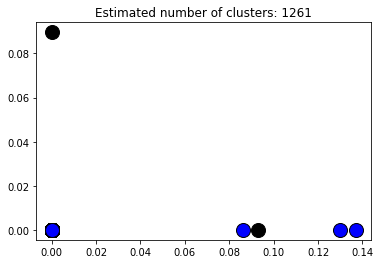

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'l

('search', 'space', 'structured', 'function', 'output', 'approach', 'cost', 'prediction', 'loss', 'procedure')


Cluster 225:
('feature', 'selection', 'data', 'method', 'paradigm', 'proposed', 'approach', 'based', 'big', 'dimensional')


Cluster 226:
('boosting', 'example', 'method', 'training', 'algorithm', 'feature', 'sampling', 'adaptive', 'case', 'computer')


Cluster 227:
('manifold', 'manopt', 'matlab', 'optimization', 'toolbox')


Cluster 228:
('time', 'process', 'change', 'covariance', 'interval', 'locally', 'mean', 'multivariate', 'smoothness', 'varying')


Cluster 229:
('convex', 'complexity', 'problem', 'algorithm', 'descent', 'dual', 'method', 'optimization', 'strongly', 'applied')


Cluster 230:
('model', 'sparse', 'markov', 'covariance', 'independence', 'matrix', 'data', 'dimensional', 'gaussian', 'high')


Cluster 231:
('step', 'algorithm', 'hmc', 'method', 'nut', 'carlo', 'monte', 'parameter', 'random', 'sampler')


Cluster 232:
('jackknife', 'ij', 'replicates', 'bootst

('learning', 'rlpy', 'function', 'reinforcement', 'value', 'allow', 'based', 'framework', 'library', 'package')


Cluster 337:
('cmr', 'regression', 'method', 'multivariate', 'calibrated', 'camel', 'convergence', 'dimensional', 'high', 'model')


Cluster 338:
('iteration', 'algorithm', 'policy', 'approximate', 'mpi', 'value', 'analysis', 'dp', 'tetri', 'approximation')


Cluster 339:
('issue', 'preface', 'special')


Cluster 340:
('equation', 'method', 'inference', 'matrix', 'solving', 'statistical', 'operator', 'problem', 'rigorous', 'solution')


Cluster 341:
('learning', 'poem', 'risk', 'ad', 'bandit', 'counterfactual', 'crm', 'feedback', 'minimization', 'principle')


Cluster 342:
('distance', 'bound', 'matrix', 'density', 'quantum', 'rank', 'entropy', 'estimation', 'low', 'lower')


Cluster 343:
('condition', 'learning', 'fast', 'central', 'rate', 'mixability', 'statistical', 'algorithm', 'online', 'show')


Cluster 344:
('asymptotic', 'regression', 'estimate', 'function', 'normal

('gp', 'latent', 'non', 'variable', 'gaussian', 'learning', 'linear', 'lvm', 'method', 'process')


Cluster 444:
('density', 'algorithm', 'estimation', 'gradient', 'line', 'mean', 'shift', '1975', 'bound', 'cluster')


Cluster 445:
('learner', 'classification', 'classifier', 'core', 'data', 'bayesian', 'ever', 'kdb', 'linear', 'pas')


Cluster 446:
('class', 'classification', 'multi', 'support', 'unified', 'vector', 'view')


Cluster 447:
('addressing', 'environment', 'learning', 'non', 'repeating', 'stationarity', 'update')


Cluster 448:
('online', 'kernel', 'learning', 'large', 'algorithm', 'scale', 'approach', 'budget', 'applies', 'classification')


Cluster 449:
('kernel', 'estimator', 'mean', 'empirical', 'method', 'shrinkage', 'standard', 'used', 'algorithm', 'also')


Cluster 450:
('model', 'approximation', 'bound', 'matrix', 'algorithm', 'error', 'extension', 'prototype', 'spsd', 'column')


Cluster 451:
('query', 'mechanism', 'data', 'smooth', 'continuous', 'answer', 'functio

('algorithm', 'basic', 'learner', 'learning', 'machine', 'mlr', 'package', 'provides', 'selection', 'want')


Cluster 561:
('domain', 'transfer', 'adaptation', 'data', 'feature', 'model', 'classifier', 'flda', 'level', 'loss')


Cluster 562:
('online', 'optimal', 'pca', 'regret')


Cluster 563:
('local', 'gp', 'region', 'regression', 'data', 'boundary', 'prediction', 'two', 'set', 'gaussian')


Cluster 564:
('bandicoot', 'mobile', 'phone', 'extract', 'feature', 'metadata', 'python', 'toolbox', '1442', 'analyze')


Cluster 565:
('output', 'kernel', 'regression', 'input', 'structured', 'supervised', 'model', 'problem', 'space', 'approach')


Cluster 566:
('algorithm', 'er', 'matrix', 'spielman', 'spud', 'wang', 'wright', 'based', 'column', 'complexity')


Cluster 567:
('network', 'performance', 'echo', 'linear', 'mse', 'neural', 'setting', 'state', 'aforementioned', 'article')


Cluster 568:
('vertex', 'nomination', 'ml', 'scheme', 'based', 'graph', 'likelihood', 'prove', 'approach', 'ba

('lda', 'sample', 'cgs', 'collapsed', 'parameter', 'approach', 'estimator', 'gibbs', 'computational', 'condition')


Cluster 677:
('tensor', 'completability', 'cp', 'rank', 'sampling', 'completion', 'entry', 'finite', 'number', 'polynomial')


Cluster 678:
('learning', 'approach', 'example', 'rule', 'class', 'data', 'description', 'exception', 'expression', 'general')


Cluster 679:
('search', 'learning', 'partial', 'policy', 'tree', 'action', 'algorithm', 'branching', 'contribution', 'making')


Cluster 680:
('kernel', 'data', 'proposed', 'rank', 'approximation', 'complexity', 'hierarchical', 'learning', 'low', 'method')


Cluster 681:
('root', 'square', 'norm', 'al', 'estimator', 'et', 'decomposable', 'slope', 'sparsity', 'weakly')


Cluster 682:
('dpvi', 'based', 'particle', 'search', 'variational', 'approximation', 'carlo', 'like', 'model', 'monte')


Cluster 683:
('model', 'rule', 'set', 'condition', 'form', 'method', 'advantage', 'bayesian', 'classification', 'classifier')


Clus

('ontology', 'query', 'description', 'logic', 'formulated', 'learning', 'case', 'dl', 'equivalence', 'exact')


Cluster 795:
('decision', 'optimal', 'algorithm', 'assisted', 'concordance', 'function', 'learning', 'proposed', 'rule', 'treatment')


Cluster 796:
('model', 'dimensional', 'high', 'correlation', 'estimator', 'graphical', 'index', 'kernel', 'latent', 'matrix')


Cluster 797:
('bayesian', 'multinomial', 'regression', 'stick', 'construction', 'one', 'permuted', 'probability', 'augmented', 'binary')


Cluster 798:
('activity', 'social', 'user', 'action', 'algorithm', 'level', 'increase', 'online', 'point', 'process')


Cluster 799:
('model', 'mixture', 'problem', 'algorithm', 'information', 'side', 'component', 'one', 'parameter', 'search')


Cluster 800:
('matrix', 'bound', 'perturbation', 'covariance', 'eigenvectors', 'vector', 'new', 'norm', 'perturbed', 'random')


Cluster 801:
('hard', 'thresholding', 'bound', 'learning', 'sparsity', 'algorithm', 'machine', 'model', 'param

('convolutional', 'kernel', 'representation', 'stability', 'analysis', 'deep', 'model', 'network', 'rkhs', 'signal')


Cluster 919:
('tensorly', 'tensor', 'deep', 'learning', 'method', 'python', 'allows', 'backend', 'library', 'machine')


Cluster 920:
('network', 'node', 'function', 'model', 'algorithm', 'associated', 'bias', 'class', 'constraint', 'edge')


Cluster 921:
('probabilistic', 'pyro', 'model', 'behavior', 'built', 'deep', 'programming', 'accelerated', 'accommodate', 'advanced')


Cluster 922:
('language', 'learning', 'iterated', 'network', 'agent', 'dynamic', 'learned', 'show', 'social', 'sustained')


Cluster 923:
('cluster', 'graph', 'subgraphs', 'weight', 'disjoint', 'semidefinite', 'clustering', 'distribution', 'edge', 'establish')


Cluster 924:
('kernel', 'sequence', 'data', 'domain', 'ordered', 'path', 'sequentialized', 'algorithm', 'arise', 'associated')


Cluster 925:
('data', 'sdm', 'netsdm', 'semantic', 'background', 'knowledge', 'mining', 'network', 'rule', 'al

('private', 'class', 'complexity', 'sample', 'concept', 'learning', 'privacy', 'differential', 'learner', 'pure')


Cluster 1031:
('data', 'group', 'ica', 'noise', 'wise', 'component', 'confounding', 'coroica', 'independent', 'model')


Cluster 1032:
('matrix', 'completion', 'collective', 'setting', 'based', 'considered', 'data', 'distribution', 'entry', 'exponential')


Cluster 1033:
('bayesian', 'predictor', 'may', 'probability', 'realizable', 'time', 'asymptotic', 'data', 'finite', 'given')


Cluster 1034:
('risk', 'score', 'method', 'algorithm', 'application', 'learn', 'constraint', 'data', 'integer', 'learning')


Cluster 1035:
('persistence', 'density', 'diagram', 'data', 'feature', 'kernel', 'topological', 'describe', 'diagonal', 'estimate')


Cluster 1036:
('clustering', 'algorithm', 'approximation', 'better', 'good', 'number', 'setting', 'stochastic', 'user', 'additionally')


Cluster 1037:
('function', 'non', 'problem', 'smooth', 'algorithm', 'class', 'convergence', 'convex',

('graphical', 'model', 'change', 'network', 'high', 'work', 'algorithm', 'application', 'class', 'detection')


Cluster 1142:
('model', 'analysis', 'probability', 'conditional', 'distribution', 'independence', 'original', 'sensitivity', 'using', 'variation')


Cluster 1143:
('model', 'survival', 'individual', 'probability', 'distribution', 'patient', 'provide', 'time', 'evaluate', 'motivates')


Cluster 1144:
('convergence', 'rate', 'distribution', 'measure', 'optimal', 'performance', 'quantization', 'empirical', 'also', 'application')


Cluster 1145:
('data', 'algorithm', 'detection', 'peak', 'penalty', 'supervised', 'count', 'dynamic', 'genomic', 'pattern')


Cluster 1146:
('estimator', 'inference', 'tabi', 'target', 'framework', 'aware', 'bayesian', 'expectation', 'limit', 'show')


Cluster 1147:
('network', 'neural', 'invariant', 'symmetry', 'group', 'probabilistic', 'action', 'characterize', 'compact', 'data')


Cluster 1148:
('model', 'graphical', 'parameter', 'estimator', 'infer

('exploration', 'problem', 'lq', 'continuous', 'control', 'entropy', 'exploitation', 'gaussian', 'learning', 'classical')


Cluster 1247:
('algorithm', 'gradient', 'statistical', 'stochastic', 'analysis', 'asymptotic', 'descent', 'behavior', 'computational', 'limit')


Cluster 1248:
('algorithm', 'approximation', 'function', 'loss', 'polynomial', 'attempt', 'complexity', 'efficient', 'error', 'interactive')


Cluster 1249:
('algorithm', 'tree', 'model', 'regression', 'bayesian', 'birth', 'death', 'search', 'time', 'continuous')


Cluster 1250:
('control', 'cell', 'drug', 'policy', 'stochastic', 'system', 'dynamic', 'event', 'robust', 'application')


Cluster 1251:
('permutation', 'regression', 'assumption', 'response', 'stage', 'approach', 'data', 'estimated', 'linear', 'match')


Cluster 1252:
('norm', 'rate', 'sobolev', 'space', 'stronger', 'used', 'algorithm', 'bound', 'case', 'combination')


Cluster 1253:
('model', 'averaging', 'cv', 'prediction', 'high', 'method', 'cox', 'dimensi

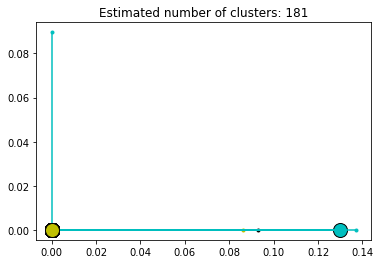

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('domain', 'distribution', 'algorithm', 'target', 'adaptation', 'discrepancy', 'source', 'feature', 'sdas', 'data')


Cluster 75:
('signal', 'noise', 'latent', 'regression', 'model', 'accumulation', 'observation', 'memory', 'factor', 'data')


Cluster 76:
('dantzig', 'selector', 'sparse', 'factor', 'method', 'recovery', 'signal', 'approach', 'effect', 'exhibiting')


Cluster 77:
('control', 'learning', 'exploration', 'reinforcement', 'rl', 'problem', 'function', 'process', 'value', 'dynamic')


Cluster 78:
('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 79:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 80:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')


Cluster 81:
('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluste

('change', 'point', 'model', 'algorithm', 'system', 'data', 'graphical', 'penalty', 'surface', 'method')


Cluster 151:
('gabp', 'algorithm', 'convergence', 'gaussian', 'definite', 'positive', 'multivariate', 'node', 'extension', 'mg')


Cluster 152:
('function', 'data', 'coherence', 'ica', 'sparse', 'coding', 'hinge', 'overcomplete', 'algorithm', 'learning')


Cluster 153:
('convergence', 'stochastic', 'sgd', 'algorithm', 'gradient', 'function', 'method', 'problem', 'learning', 'rate')


Cluster 154:
('state', 'reservoir', 'system', 'input', 'memory', 'space', 'time', 'fading', 'filter', 'feature')


Cluster 155:
('image', 'convolutional', 'invariance', 'network', 'information', 'representation', 'model', 'data', 'neural', 'patch')


Cluster 156:
('constraint', 'algorithm', 'problem', 'convex', 'time', 'optimization', 'regret', 'online', 'set', 'pesc')


Cluster 157:
('regression', 'modal', 'loss', 'learning', 'model', 'symbolic', 'correntropy', 'risk', 'dynamical', 'mmsr')


Cluster 

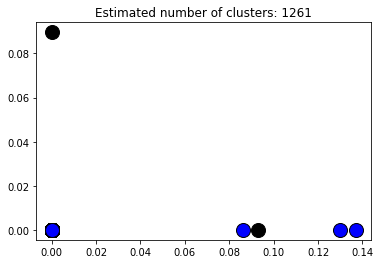

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('market', 'prediction', 'artificial', 'data', 'real', 'aggregation', 'classifier', 'detection', 'equation', 'estimator')


Cluster 67:
('topic', 'model', 'algorithm', 'bp', 'toolbox', 'lda', 'modeling', 'based', 'allocation', 'belief')


Cluster 68:
('model', 'topic', 'margin', 'medlda', 'representation', 'supervised', 'data', 'discriminative', 'max', 'maximum')


Cluster 69:
('classification', 'pairwise', 'class', 'example', 'machine', 'pair', 'particular', 'problem', 'result', 'support')


Cluster 70:
('model', 'algorithm', 'condition', 'graphical', 'number', 'sparsistency', 'based', 'dimensional', 'gaussian', 'graph')


Cluster 71:
('graph', 'local', 'eigenvector', 'locally', 'second', 'biased', 'data', 'information', 'input', 'manner')


Cluster 72:
('rule', 'ensemble', 'regression', 'target', 'multi', 'algorithm', 'problem', 'accuracy', 'tree', 'accurate')


Cluster 73:
('markov', 'equivalence', 'interventional', 'graph', 'dag', 'observational', 'algorithm', 'case', 'class', 'int

('machine', 'robustness', '10', '1485', '1510', '2009', 'al', 'comment', 'et', 'journal')


Cluster 178:
('graph', 'function', 'svm', 'clique', 'common', 'labellings', 'large', 'lovã', 'multiple', 'orthogonal')


Cluster 179:
('learning', 'grammar', 'language', 'string', 'context', 'free', 'strong', 'algorithm', 'correct', 'corresponding')


Cluster 180:
('data', 'incomplete', 'label', 'reliability', 'time', 'complete', 'class', 'classify', 'given', 'goal')


Cluster 181:
('median', 'algorithm', 'approach', 'distribution', 'finding', 'however', 'hypothesis', 'map', 'one', 'present')


Cluster 182:
('norm', 'max', 'bit', 'bound', 'completion', 'constrained', 'convergence', 'estimate', 'general', 'lower')


Cluster 183:
('constraint', 'nrsample', 'program', 'synthesis', 'time', 'accuracy', 'faster', 'problem', 'progol', 'search')


Cluster 184:
('harmonic', 'supervised', 'assumption', 'function', 'estimate', 'cluster', 'joint', 'boundary', 'data', 'estimator')


Cluster 185:
('kernel', '

('gp', 'bucb', 'bound', 'batch', 'experiment', 'gaussian', 'process', 'aucb', 'confidence', 'regret')


Cluster 294:
('learning', 'active', 'imitation', 'policy', 'reduction', 'based', 'contribution', 'effort', 'expert', 'first')


Cluster 295:
('budget', 'labeling', 'worker', 'policy', 'allocation', 'crowdsourcing', 'decision', 'instance', 'computationally', 'data')


Cluster 296:
('rank', 'low', 'sparseness', 'subproblem', 'decomposition', 'exact', 'matrix', 'pursuit', 'solution', 'structure')


Cluster 297:
('summary', 'statistical', 'topological', 'data', 'landscape', 'number', 'persistence', 'space', 'standard', 'used')


Cluster 298:
('automaton', 'framework', 'learning', 'link', 'model', 'multiplicity', 'observable', 'operator', 'predictive', 'representation')


Cluster 299:
('samoa', 'advanced', 'algorithm', 'analysis', 'data', 'distributed', 'massive', 'mining', 'online', 'scalable')


Cluster 300:
('learning', 'sequential', 'complexity', 'online', 'learnability', 'measure', '

('string', 'similarity', 'harry', 'data', 'tool', 'analysis', 'common', 'designed', 'distance', 'kernel')


Cluster 412:
('gibbs', 'herded', 'model', 'algorithm', 'connected', 'convergence', 'graphical', 'probabilistic', 'called', 'crfs')


Cluster 413:
('part', 'level', 'compositional', 'model', 'object', 'complexity', 'executive', 'inference', 'representation', 'sharing')


Cluster 414:
('subspace', 'clustering', 'ssc', 'data', 'noise', 'noisy', 'sparse', 'added', 'adversarial', 'algorithm')


Cluster 415:
('go', 'reward', 'variance', 'algorithm', 'currently', 'domain', 'function', 'known', 'learning', 'mdps')


Cluster 416:
('loss', 'convex', 'multiclass', 'matrix', 'surrogate', 'calibration', 'calibrated', 'dimension', 'general', 'problem')


Cluster 417:
('matrix', 'approximation', 'local', 'low', 'rank', 'observed', 'accuracy', 'analyze', 'approach', 'constructing')


Cluster 418:
('criterion', 'information', 'machine', 'support', 'vector', 'model', 'selection', 'theoretical', 'c

('crosscat', 'data', 'mixture', 'model', 'bayesian', 'method', 'modeling', 'multiple', 'nonparametric', 'paper')


Cluster 531:
('policy', 'space', 'function', 'algorithm', 'bound', 'evaluation', 'iteration', 'nonparametric', 'reg', 'work')


Cluster 532:
('covariance', 'pca', 'sparse', 'thresholding', 'via')


Cluster 533:
('image', 'label', 'large', 'level', 'learning', 'available', 'detector', 'joint', 'labeled', 'method')


Cluster 534:
('data', 'covariance', 'algorithm', 'clustering', 'functional', 'propose', 'also', 'distance', 'estimation', 'estimator')


Cluster 535:
('optimization', 'problem', 'term', 'convex', 'nonconvex', 'algorithm', 'composite', 'function', 'may', 'approach')


Cluster 536:
('method', 'online', 'true', 'learning', 'regular', 'difference', 'forward', 'sarsa', 'td', 'temporal')


Cluster 537:
('layer', 'likelihood', 'estimator', 'graphical', 'layered', 'maximum', 'model', 'multi', 'edge', 'estimation')


Cluster 538:
('community', 'conductance', 'algorithm',

('learning', 'active', 'fir', 'based', 'objective', 'allows', 'analysis', 'existing', 'fisher', 'framework')


Cluster 651:
('algorithm', 'hidden', 'model', 'markov', 'approach', 'based', 'data', 'em', 'hsmms', 'inference')


Cluster 652:
('expression', 'causal', 'algorithm', 'effect', 'inference', 'advantage', 'applicable', 'application', 'automatic', 'available')


Cluster 653:
('compression', 'nearly', 'classification', 'generalization', 'optimal', 'point', 'sample', 'semimetric', 'semimetrics', 'space')


Cluster 654:
('field', 'learning', 'supervised', 'two', 'co', 'concept', 'idea', 'optimization', 'advancement', 'algorithm')


Cluster 655:
('data', 'source', 'analysis', 'factor', 'gfa', 'multiple', 'package', 'allows', 'also', 'biclusters')


Cluster 656:
('gpflow', 'gaussian', 'library', 'process', 'tensorflow', 'us', 'able', 'approximation', 'automatic', 'code')


Cluster 657:
('method', 'dependence', 'data', 'local', 'matrix', 'problem', 'estimation', 'existing', 'gaussian', 

('ad', 'learning', 'machine', 'differentiation', 'automatic', 'technique', 'application', 'autodiffâ', 'computational', 'derivative')


Cluster 758:
('mean', 'population', 'sample', 'unknown', 'finite', 'normal', 'outcome', 'policy', 'problem', 'random')


Cluster 759:
('ranking', 'item', 'model', 'assessor', 'based', 'consensus', 'mallow', 'preference', 'probabilistic', 'rank')


Cluster 760:
('function', 'gradient', 'application', 'compressive', 'evaluation', 'perturbation', 'sensing', 'simultaneous', 'advantage', 'almost')


Cluster 761:
('hyperparameters', 'latent', 'model', 'allocation', 'dirichlet', 'estimate', 'inference', 'lda', 'method', 'prior')


Cluster 762:
('network', 'deep', 'model', 'shallow', 'boltzmann', 'generative', 'ising', 'machine', 'near', 'neural')


Cluster 763:
('pomegranate', 'model', 'learning', 'probabilistic', 'algorithm', 'focus', 'modeling', 'code', 'data', 'present')


Cluster 764:
('risk', 'algorithm', 'constrained', 'gradient', 'mdps', 'percentile', 

('cluster', 'likelihood', 'response', 'variable', 'algorithm', 'penalized', 'regression', 'binomial', 'method', 'penalty')


Cluster 821:
('kernel', 'distance', 'hsic', 'independence', 'mmd', 'product', 'tensor', 'characteristic', 'statistic', 'also')


Cluster 822:
('list', 'rule', 'optimal', 'data', 'categorical', 'interpretable', 'produce', 'risk', 'according', 'accurate')


Cluster 823:
('singularity', 'network', 'learning', 'rbf', 'dynamic', 'result', 'analysis', 'dimensional', 'elimination', 'feedforward')


Cluster 824:
('algorithm', 'greedy', 'submodularity', 'approximation', 'ratio', 'application', 'selection', 'set', 'analysis', 'analyze')


Cluster 825:
('state', 'clinical', 'data', 'patient', 'time', 'hasmm', 'model', 'care', 'ehr', 'markov')


Cluster 826:
('bootstrap', 'give', 'regression', 'dimension', 'high', 'method', 'conservative', 'consider', 'estimate', 'grows')


Cluster 827:
('rsg', 'local', 'method', 'problem', 'bound', 'property', 'set', 'sg', 'complexity', 'co

('policy', 'problem', 'cost', 'index', 'observation', 'optimal', 'posterior', 'threshold', 'time', 'variance')


Cluster 929:
('graph', 'algorithm', 'flow', 'min', 'problem', 'sum', 'walk', 'analyze', 'defined', 'framework')


Cluster 930:
('method', 'subspace', 'condition', 'deterministic', 'gradient', 'recovery', 'size', 'underlying', 'achieves', 'ambient')


Cluster 931:
('problem', 'sparse', 'optimization', 'approximately', 'class', 'function', 'hardness', 'loss', 'np', 'penalty')


Cluster 932:
('method', 'accuracy', 'dimension', 'randomized', 'cost', 'bootstrap', 'computation', 'error', 'general', 'given')


Cluster 933:
('base', 'distribution', 'model', 'problem', 'setting', 'classification', 'contamination', 'general', 'label', 'learning')


Cluster 934:
('method', 'order', 'approach', 'convergence', 'convex', 'empirical', 'fast', 'information', 'iteration', 'minibatch')


Cluster 935:
('distributed', 'optimization', 'model', 'algorithm', 'dscovr', 'parameter', 'coordinate', 'm

('matrix', 'convex', 'problem', 'dual', 'factorization', 'non', 'framework', 'condition', 'duality', 'strong')


Cluster 991:
('loss', 'empirical', 'case', 'distribution', 'new', 'regularization', 'worst', 'ball', 'bound', 'data')


Cluster 992:
('computation', 'exact', 'approximation', 'full', 'optimal', 'problem', 'transport', 'accuracy', 'distance', 'end')


Cluster 993:
('algorithm', 'method', 'augmented', 'based', 'computational', 'data', 'dimensional', 'high', 'lagrangian', 'newton')


Cluster 994:
('seed', 'estimation', 'rank', 'scalable', 'sparse', 'matrix', 'regression', 'selection', 'data', 'decomposition')


Cluster 995:
('likelihood', 'case', 'control', 'genetic', 'unit', 'correlated', 'latent', 'sampling', 'setting', 'complex')


Cluster 996:
('separable', 'gaussian', 'graphical', 'model', 'node', 'provide', 'relation', 'strongly', 'algorithm', 'conditional')


Cluster 997:
('deep', 'network', 'function', 'neural', 'spline', 'activation', 'adaptive', 'knot', 'linear', 'mak

('dual', 'solution', 'primal', 'complexity', 'iteration', 'accelerated', 'algorithm', 'ascent', 'coordinate', 'optimal')


Cluster 1098:
('distributed', 'graph', 'regularisation', 'implicit', 'bound', 'dependent', 'establish', 'learning', 'sgd', 'descent')


Cluster 1099:
('signal', 'accumulation', 'noise', 'classifier', 'strength', 'classification', 'developed', 'dimensional', 'high', 'machine')


Cluster 1100:
('causal', 'discovery', 'algorithm', 'end', 'graph', 'package', 'python', 'relationship', 'aimed', 'anm')


Cluster 1101:
('causal', 'variable', 'effect', 'observed', 'among', 'data', 'model', 'latent', 'learning', 'non')


Cluster 1102:
('network', 'algorithm', 'biclustering', 'class', 'optimal', 'average', 'bipartite', 'degree', 'general', 'procedure')


Cluster 1103:
('model', 'causal', 'data', 'discovery', 'method', 'predictor', 'regression', 'switching', 'asymptotic', 'cause')


Cluster 1104:
('verification', 'method', 'model', 'network', 'neural', 'nn', 'previous', 'algor

('tensor', 'problem', 'binary', 'data', 'develop', 'estimation', 'guarantee', 'model', 'according', 'accuracy')


Cluster 1209:
('stochastic', 'algorithm', 'gradient', 'method', 'new', 'noise', 'optimization', 'accelerated', 'composite', 'descent')


Cluster 1210:
('posterior', 'sequence', 'distribution', 'good', 'approximate', 'bayesian', 'consistency', 'divergence', 'property', 'rényi')


Cluster 1211:
('variational', 'level', 'algorithm', 'model', 'effect', 'inference', 'random', 'approach', 'bayes', 'explicit')


Cluster 1212:
('method', 'learning', 'network', 'structure', 'bayesian', 'cluster', 'fusion', 'node', 'partition', 'pef')


Cluster 1213:
('algorithm', 'loop', 'instance', 'hardness', 'max', 'sat', 'frustrated', 'frustration', 'problem', 'random')


Cluster 1214:
('robust', 'estimation', 'matrix', 'covariance', 'estimator', 'framework', 'gans', 'proper', 'rule', 'scoring')


Cluster 1215:
('set', 'data', 'apricot', 'selection', 'submodular', 'using', 'subset', 'algorithm',

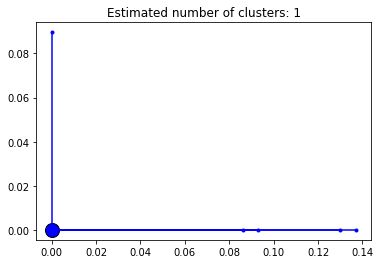

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


damping: 0.8, max_iter: 600, convergence: 15, preference: None
Estimated number of clusters: 180


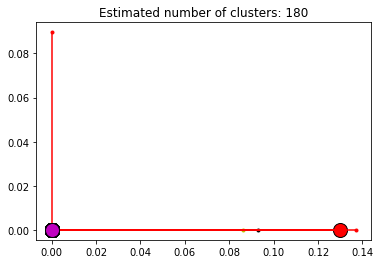

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluster 81:
('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 82:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 83:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 84:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'proposed')


Cluster 85:
('model', 'graphical', 'data', 'network', 'problem', 'method', 'gaussian', 'graph', 'node', 'lasso')


Cluster 86:
('patient', 'model', 'time', 'data', 'image', 'disease', 'risk', 'clinical', 'learning', 'mri')


Cluster 87:
('spurious', 'model', 'valley', 'local', 'recovery', 'fit', 'minimum', 'discovery', 'dimension', 'point')


Cluster 88:
('data', 'de

('interaction', 'high', 'data', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'problem', 'matrix')


Cluster 160:
('graph', 'algorithm', 'problem', 'learning', 'random', 'model', 'data', 'spectral', 'framework', 'time')


Cluster 161:
('data', 'supervised', 'graph', 'unlabeled', 'semi', 'consistency', 'learning', 'cut', 'based', 'harmonic')


Cluster 162:
('dual', 'method', 'convex', 'problem', 'primal', 'complexity', 'algorithm', 'iteration', 'solution', 'optimization')


Cluster 163:
('causal', 'effect', 'variable', 'data', 'model', 'method', 'algorithm', 'discovery', 'approach', 'learning')


Cluster 164:
('attack', 'based', 'detection', 'method', 'random', 'learning', 'distribution', 'image', 'robustness', 'smoothing')


Cluster 165:
('ensemble', 'model', 'relational', 'method', 'learning', 'base', 'learner', 'prediction', 'data', 'exploration')


Cluster 166:
('kernel', 'square', 'least', 'regression', 'approximation', 'gradient', 'model', 'matrix', 'regularized',

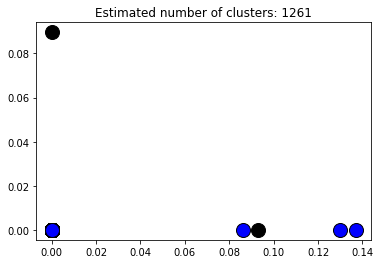

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('graph', 'tree', 'node', 'random', 'spanning', 'weighted', 'algorithm', 'cutsize', 'label', 'method')


Cluster 115:
('curve', 'principal', 'estimation', 'model', 'new', 'point', 'selection', 'demonstrates', 'difficulty', 'distance')


Cluster 116:
('inference', 'model', 'stochastic', 'variational', 'article', 'topic', '8m', 'bayesian', 'data', 'develop')


Cluster 117:
('node', 'algorithm', 'dag', 'optimal', 'space', 'time', 'found', 'network', 'order', 'bayesian')


Cluster 118:
('kernel', 'learning', 'library', 'algorithm', 'computer', 'easily', 'jkernelmachines', 'product', 'standard', 'vision')


Cluster 119:
('set', 'uncertainty', 'approach', 'function', 'statistical', 'loss', 'conjugate', 'property', 'used', 'also')


Cluster 120:
('ideal', 'language', 'shuffle', 'class', 'pac', 'learning', 'polynomial', 'regular', 'time', 'algorithm')


Cluster 121:
('data', 'detection', 'fgss', 'subset', 'pattern', 'scan', 'set', 'anomalous', 'domain', 'fast')


Cluster 122:
('constraint', 'l

('jackknife', 'ij', 'replicates', 'bootstrap', 'estimate', 'study', 'bagged', 'bagging', 'estimator', 'forest')


Cluster 233:
('ranking', 'regret', 'bipartite', 'loss', 'bound', 'proper', 'term', 'pairwise', 'surrogate', '2011')


Cluster 234:
('linear', 'model', 'rate', 'regression', 'achieve', 'aggregation', 'best', 'predictor', 'sparse', 'combination')


Cluster 235:
('structure', 'data', 'estimating', 'graphical', 'model', 'node', 'graph', 'method', 'multi', 'network')


Cluster 236:
('graph', 'time', 'commute', 'hitting', 'distance', 'random', 'vertex', 'degree', 'expected', 'learning')


Cluster 237:
('bayesian', 'posterior', 'latent', 'inference', 'present', 'regbayes', 'regularization', 'distribution', 'infinite', 'prior')


Cluster 238:
('prior', 'model', 'parameter', 'approach', 'nn', 'scale', 'hierarchical', 'network', 'relevance', 'using')


Cluster 239:
('data', 'missing', 'algorithm', 'imputation', 'likelihood', 'observed', 'alternating', 'dimensional', 'high', 'log')




('clustering', 'measure', 'axiom', 'elementary', 'hierarchical', 'notion', 'set', 'user', 'without', 'additivity')


Cluster 349:
('graph', 'bound', 'labelings', 'online', 'problem', 'algorithm', 'labeling', 'latent', 'predicting', 'prediction')


Cluster 350:
('example', 'information', 'student', 'learning', 'privileged', 'teacher', 'describes', 'intelligent', 'knowledge', 'paper')


Cluster 351:
('alexey', 'bibliography', 'chervonenkis', 'comment', 'introductory')


Cluster 352:
('alexey', 'bibliography', 'chervonenkis')


Cluster 353:
('system', 'learning', 'machine', 'common', 'computing', 'delay', 'demonstrate', 'descent', 'encoding', 'far')


Cluster 354:
('beamformers', 'meg', 'vector', 'beamforming', 'proposed', 'activity', 'case', 'covariance', 'data', 'dimension')


Cluster 355:
('data', 'set', 'different', 'combine', 'constraint', 'algorithm', 'causal', 'intervention', 'model', 'overlapping')


Cluster 356:
('entropy', 'function', 'cone', 'proper', 'rule', 'scoring', 'space'

('gesture', 'recognition', 'available', 'challenge', 'multimodal', 'art', 'camera', 'data', 'including', 'overview')


Cluster 470:
('td', 'method', 'parameter', 'step', 'update', 'difference', 'different', 'emphasizing', 'emphatic', 'function')


Cluster 471:
('auction', 'price', 'reserve', 'revenue', 'problem', 'algorithm', 'learning', 'second', 'analysis', 'cast')


Cluster 472:
('coordinate', 'data', 'big', 'descent', 'iteration', 'method', 'node', 'partition', 'problem', '3tb')


Cluster 473:
('empirical', 'learning', 'risk', 'statistic', 'incomplete', 'data', 'erm', 'functionals', 'minimization', 'optimization')


Cluster 474:
('learning', 'regularization', 'iterative', 'consider', 'convex', 'function', 'loss', 'new', 'achieved', 'algorithm')


Cluster 475:
('network', 'community', 'detection', 'internet', 'overlapping', 'scale', 'approach', 'inference', 'latent', 'million')


Cluster 476:
('risk', 'patient', 'model', 'stratification', 'learning', 'time', 'admission', 'outcome', 

('rank', 'spearman', 'list', 'multivariate', 'aggregation', 'correlation', 'missing', 'ranked', 'aggregating', 'best')


Cluster 588:
('link', 'model', 'network', 'nonparametric', 'prediction')


Cluster 589:
('spurious', 'fit', 'model', 'discovery', 'goodness', 'variable', 'algorithm', 'asymptotic', 'better', 'correlation')


Cluster 590:
('data', 'functional', 'markov', 'graphical', 'model', 'prior', 'random', 'hyper', 'multivariate', 'process')


Cluster 591:
('autoregressive', 'distribution', 'estimation', 'nade', 'neural', 'also', 'architecture', 'deep', 'model', 'performance')


Cluster 592:
('algorithm', 'consistency', 'density', 'erratum', 'estimation', 'gradient', 'line', 'mean', 'shift', 'paper')


Cluster 593:
('backtracking', 'data', 'dimensional', 'high', 'interaction', 'modelling')


Cluster 594:
('cross', 'fold', 'validation', 'least', 'variance', 'square', 'also', 'case', 'density', 'estimation')


Cluster 595:
('model', 'method', 'matrix', 'fast', 'nystrã', 'approximat

('method', 'cost', 'algorithm', 'distributed', 'communication', 'existing', 'step', 'system', 'variable', 'block')


Cluster 704:
('learning', 'data', 'least', 'square', 'distributed', 'expectation', 'function', 'output', 'rate', 'regularization')


Cluster 705:
('worker', 'honest', 'algorithm', 'label', 'unreliable', 'adversarial', 'strategy', 'adversary', 'labeling', 'probabilistic')


Cluster 706:
('label', 'class', 'classification', 'easy', 'hard', 'confusing', 'multiclass', 'learning', 'proposed', 'also')


Cluster 707:
('fisher', 'probability', 'consistency', 'prior', 'adjusted', 'algorithm', 'cde', 'class', 'consistent', 'count')


Cluster 708:
('bag', 'openxbow', 'toolkit', 'word', 'feature', 'input', 'acoustic', 'bow', 'classification', 'crossmodal')


Cluster 709:
('rank', 'given', 'tensor', 'completion', 'matrix', 'bound', 'data', 'low', 'view', 'probability')


Cluster 710:
('model', 'network', 'constraint', 'iterative', 'mip', 'order', 'problem', 'topological', 'algorithm'

('corrupted', 'label', 'learning', 'theory')


Cluster 817:
('algorithm', 'stream', 'pool', 'setting', 'based', 'element', 'select', 'interactive', 'precognitive', 'bound')


Cluster 818:
('distributed', 'framework', 'convex', 'efficient', 'general', 'non', 'cocoa', 'communication', 'datasets', 'ha')


Cluster 819:
('process', 'bound', 'empirical', 'probability', 'series', 'tail', 'time', 'class', 'condition', 'dependence')


Cluster 820:
('cluster', 'likelihood', 'response', 'variable', 'algorithm', 'penalized', 'regression', 'binomial', 'method', 'penalty')


Cluster 821:
('kernel', 'distance', 'hsic', 'independence', 'mmd', 'product', 'tensor', 'characteristic', 'statistic', 'also')


Cluster 822:
('list', 'rule', 'optimal', 'data', 'categorical', 'interpretable', 'produce', 'risk', 'according', 'accurate')


Cluster 823:
('singularity', 'network', 'learning', 'rbf', 'dynamic', 'result', 'analysis', 'dimensional', 'elimination', 'feedforward')


Cluster 824:
('algorithm', 'greedy', 

('problem', 'sparse', 'optimization', 'approximately', 'class', 'function', 'hardness', 'loss', 'np', 'penalty')


Cluster 932:
('method', 'accuracy', 'dimension', 'randomized', 'cost', 'bootstrap', 'computation', 'error', 'general', 'given')


Cluster 933:
('base', 'distribution', 'model', 'problem', 'setting', 'classification', 'contamination', 'general', 'label', 'learning')


Cluster 934:
('method', 'order', 'approach', 'convergence', 'convex', 'empirical', 'fast', 'information', 'iteration', 'minibatch')


Cluster 935:
('distributed', 'optimization', 'model', 'algorithm', 'dscovr', 'parameter', 'coordinate', 'machine', 'asynchronous', 'block')


Cluster 936:
('online', 'rfd', 'algorithm', 'learning', 'direction', 'fd', 'frequent', 'application', 'matrix', 'newton')


Cluster 937:
('learning', 'bkrr', 'kernel', 'regression', 'ridge', 'algorithm', 'bias', 'boosted', 'boosting', 'iteration')


Cluster 938:
('spectral', 'clustering', 'general', 'algorithm', 'model', 'adjacency', 'comm

('likelihood', 'case', 'control', 'genetic', 'unit', 'correlated', 'latent', 'sampling', 'setting', 'complex')


Cluster 996:
('separable', 'gaussian', 'graphical', 'model', 'node', 'provide', 'relation', 'strongly', 'algorithm', 'conditional')


Cluster 997:
('deep', 'network', 'function', 'neural', 'spline', 'activation', 'adaptive', 'knot', 'linear', 'make')


Cluster 998:
('change', 'point', 'regression', 'estimate', 'model', 'parameter', 'rate', 'size', 'computational', 'dimensional')


Cluster 999:
('batch', 'training', 'size', 'data', 'network', 'neural', 'model', 'algorithm', 'available', 'effect')


Cluster 1000:
('estimator', 'distributed', 'svm', 'linear', 'inference', 'machine', 'data', 'mdl', 'asymptotic', 'efficiency')


Cluster 1001:
('local', 'recovery', 'minimum', 'spurious', 'point', 'rip', 'constant', 'exact', 'guarantee', 'inexistence')


Cluster 1002:
('attribute', 'latent', 'pattern', 'model', 'slam', 'dimensional', 'high', 'learning', 'selection', 'structured')



('attack', 'based', 'character', 'greedy', 'method', 'adversarial', 'cnn', 'data', 'discrete', 'example')


Cluster 1106:
('state', 'space', 'kernel', 'dynamic', 'feature', 'decaying', 'exponentially', 'input', 'memory', 'model')


Cluster 1107:
('kernel', 'class', 'tk', 'algorithm', 'learning', 'set', 'universal', 'accuracy', 'criterion', 'dense')


Cluster 1108:
('package', 'python', 'pyts', 'classification', 'series', 'time', 'algorithm', 'api', 'bsd', 'clause')


Cluster 1109:
('graph', 'game', 'hypernode', 'problem', 'multiplayer', 'set', 'skill', 'relation', 'algorithm', 'positive')


Cluster 1110:
('ensemble', 'relational', 'learning', 'data', 'framework', 'inference', 'analysis', 'approach', 'collective', 'error')


Cluster 1111:
('data', 'driven', 'interaction', 'penalization', 'result', 'analysis', 'based', 'hawkes', 'low', 'martingale')


Cluster 1112:
('model', 'afdag', 'network', 'aci', 'additive', 'based', 'causal', 'conditional', 'consistency', 'data')


Cluster 1113:
('

('auto', 'cwae', 'cramer', 'kernel', 'mmd', 'model', 'wold', 'closed', 'component', 'distance')


Cluster 1219:
('dictionary', 'algorithm', 'based', 'method', 'guarantee', 'norm', 'orthogonal', 'complete', 'complexity', 'data')


Cluster 1220:
('lag', 'approach', 'order', 'var', 'component', 'forecasting', 'hlag', 'lasso', 'selection', 'structure')


Cluster 1221:
('convex', 'approach', 'non', 'class', 'estimation', 'estimator', 'label', 'problem', 'setting', 'conditional')


Cluster 1222:
('ridge', 'penalty', 'high', 'dimensional', 'model', 'negative', 'optimal', 'real', 'regularization', 'case')


Cluster 1223:
('commenting', 'behavior', 'youtube', 'constraint', 'group', 'user', 'bayesian', 'inattentive', 'inverse', 'learning')


Cluster 1224:
('forest', 'random', 'model', 'regression', 'success', 'based', 'empirical', 'explanation', 'forward', 'procedure')


Cluster 1225:
('operator', 'method', 'system', 'nonlinear', 'arnoldi', 'data', 'dynamical', 'subspace', 'using', 'develop')




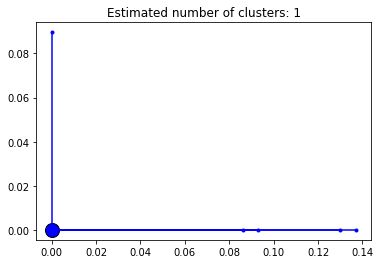

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')


damping: 0.8, max_iter: 600, convergence: 30, preference: None
Estimated number of clusters: 180


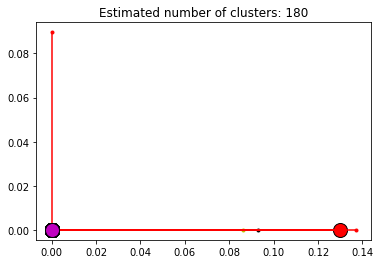

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'model', 'ontology', 'learning', 'query', 'problem', 'label', 'aggregation', 'mallow')


Cluster 1:
('algorithm', 'selective', 'learning', 'setting', 'stream', 'classification', 'classifier', 'active', 'label', 'pool')


Cluster 2:
('metric', 'learning', 'distance', 'kernel', 'data', 'algorithm', 'ground', 'graph', 'matrix', 'method')


Cluster 3:
('model', 'selection', 'criterion', 'dimension', 'information', 'distribution', 'algorithm', 'feature', 'value', 'minimal')


Cluster 4:
('task', 'learning', 'transfer', 'problem', 'text', 'framework', 'skill', 'reinforcement', 'data', 'related')


Cluster 5:
('maximum', 'data', 'dimensionality', 'reduction', 'method', 'likelihood', 'analysis', 'linear', 'unfolding', 'approximate')


Cluster 6:
('variational', 'approximation', 'gaussian', 'model', 'inference', 'process', 'method', 'likelihood', 'algorithm', 'distribution')


Cluster 7:
('dimensional', 'coefficient', 'model', 'data',

('matrix', 'covariance', 'estimator', 'sparse', 'model', 'estimation', 'method', 'data', 'algorithm', 'inverse')


Cluster 78:
('pca', 'thresholding', 'sparse', 'via', 'online', 'optimal', 'regret', 'covariance', 'data', 'consistency')


Cluster 79:
('reward', 'strategy', 'problem', 'profile', 'bandit', 'optimal', 'allocation', 'bound', 'learning', 'stochastic')


Cluster 80:
('norm', 'learning', 'matrix', 'method', 'regularization', 'tv', 'problem', 'square', 'max', 'rate')


Cluster 81:
('machine', 'boltzmann', 'restricted', 'model', 'conditional', 'discrete', 'classification', 'universal', 'rbm', 'dbms')


Cluster 82:
('learner', 'teaching', 'dimension', 'class', 'training', 'infinite', 'pbtd', 'data', 'linear', 'classification')


Cluster 83:
('layer', 'network', 'multilayer', 'bottleneck', 'hidden', 'tensor', 'community', 'data', 'extraction', 'model')


Cluster 84:
('regression', 'derivative', 'method', 'asymptotic', 'estimator', 'function', 'linear', 'estimate', 'variance', 'pro

('constraint', 'algorithm', 'problem', 'convex', 'time', 'optimization', 'regret', 'online', 'set', 'pesc')


Cluster 156:
('regression', 'modal', 'loss', 'learning', 'model', 'symbolic', 'correntropy', 'risk', 'dynamical', 'mmsr')


Cluster 157:
('factor', 'data', 'outcome', 'principal', 'marginal', 'analysis', 'model', 'curve', 'latent', 'correlated')


Cluster 158:
('data', 'bayesian', 'inference', 'approximation', 'ep', 'framework', 'model', 'imaging', 'correction', 'method')


Cluster 159:
('interaction', 'high', 'data', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'problem', 'matrix')


Cluster 160:
('graph', 'algorithm', 'problem', 'learning', 'random', 'model', 'data', 'spectral', 'framework', 'time')


Cluster 161:
('data', 'supervised', 'graph', 'unlabeled', 'semi', 'consistency', 'learning', 'cut', 'based', 'harmonic')


Cluster 162:
('dual', 'method', 'convex', 'problem', 'primal', 'complexity', 'algorithm', 'iteration', 'solution', 'optimization')


Clust

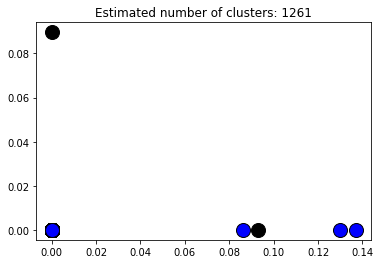

Top terms per cluster:
Cluster 0:
('learning', 'metric', 'eigenvalue', 'optimization', 'called', 'new', 'novel', 'algorithm', 'approach', 'data')


Cluster 1:
('criterion', 'feature', 'selection', 'information', 'conditional', 'framework', 'heuristic', 'likelihood', 'based', 'decade')


Cluster 2:
('active', 'bound', 'learning', 'rate', 'achievable', 'algorithm', 'almost', 'also', 'approach', 'based')


Cluster 3:
('preference', 'label', 'pairwise', 'learning', 'problem', 'query', 'algorithm', 'complexity', 'element', 'given')


Cluster 4:
('distributed', 'prediction', 'algorithm', 'method', 'online', 'problem', 'processor', 'asymptotically', 'batch', 'input')


Cluster 5:
('point', 'clustering', 'distance', 'given', 'query', 'sequence', 'set', 'active', 'cluster', 'efficiently')


Cluster 6:
('classification', 'learning', 'selective', 'active', 'case', 'complexity', 'label', 'model', 'perfect', 'reduction')


Cluster 7:
('search', 'hyper', 'parameter', 'grid', 'random', 'optimization'

('matrix', 'cluster', 'similarity', 'clustering', 'factorization', 'given', 'based', 'left', 'stochastic', 'algorithm')


Cluster 127:
('consistent', 'convergence', 'maximum', 'unfolding', 'variance', 'assumption', 'convex', 'dimensionality', 'example', 'fails')


Cluster 128:
('coefficient', 'design', 'performance', 'selection', 'variable', 'vector', 'also', 'analyzed', 'matching', 'omp')


Cluster 129:
('kernel', 'learning', 'random', 'curve', 'graph', 'prior', 'vertex', 'gaussian', 'large', 'process')


Cluster 130:
('angle', 'distribution', 'random', 'limiting', 'setting', 'vector', 'almost', 'also', 'always', 'among')


Cluster 131:
('clustering', 'learning', 'analysis', 'cluster', 'method', 'regression', 'classification', 'convex', 'generalized', 'non')


Cluster 132:
('group', 'prior', 'feature', 'bayesian', 'generalized', 'problem', 'selection', 'slab', 'spike', 'method')


Cluster 133:
('attribute', 'bayes', 'naive', 'weighting', 'classifier', 'ha', 'algorithm', 'approach', 'a

('graph', 'ugms', 'junction', 'tree', 'algorithm', 'undirected', 'framework', 'graphical', 'model', 'different')


Cluster 193:
('axiom', 'clustering', 'function', 'graph', 'quality')


Cluster 194:
('convex', 'glasso', 'problem', 'ard', 'known', 'regression', 'variable', 'approach', 'bayesian', 'error')


Cluster 195:
('model', 'policy', 'bo', 'rl', 'bayesian', 'contribution', 'learning', 'new', 'show', 'trajectory')


Cluster 196:
('information', 'theoretical', 'estimator', 'ite', 'application', 'problem', 'toolbox', 'additionally', 'also', 'analysis')


Cluster 197:
('policy', 'learning', 'algorithm', 'algorithmic', 'approach', 'based', 'eligibility', 'known', 'least', 'linear')


Cluster 198:
('stopping', 'data', 'early', 'kernel', 'rule', 'based', 'form', 'regression', 'bound', 'class')


Cluster 199:
('network', 'problem', 'data', 'difference', 'node', 'set', 'condition', 'two', 'across', 'algorithm')


Cluster 200:
('package', 'linear', 'problem', 'solving', 'clime', 'efficientl

('samoa', 'advanced', 'algorithm', 'analysis', 'data', 'distributed', 'massive', 'mining', 'online', 'scalable')


Cluster 300:
('learning', 'sequential', 'complexity', 'online', 'learnability', 'measure', 'prediction', 'problem', 'setting', 'several')


Cluster 301:
('gesture', 'component', 'character', 'kinect', 'layer', 'layered', 'motion', 'multi', 'proposed', 'recognition')


Cluster 302:
('gesture', 'multimodal', 'based', 'hypothesis', 'multiple', 'recognition', 'data', 'model', 'rescoring', 'approach')


Cluster 303:
('function', 'algorithm', 'asynchronous', 'constrained', 'coordinate', 'descent', 'describe', 'linear', 'number', 'parallel')


Cluster 304:
('framework', 'concordant', 'function', 'self', 'smooth', 'algorithmic', 'analytic', 'application', 'assumption', 'based')


Cluster 305:
('consistency', 'network', 'structure', 'framework', 'granger', 'group', 'grouping', 'inherent', 'model', 'study')


Cluster 306:
('cluster', 'graph', 'large', 'algorithm', 'based', 'iterativ

('loss', 'convex', 'multiclass', 'matrix', 'surrogate', 'calibration', 'calibrated', 'dimension', 'general', 'problem')


Cluster 417:
('matrix', 'approximation', 'local', 'low', 'rank', 'observed', 'accuracy', 'analyze', 'approach', 'constructing')


Cluster 418:
('criterion', 'information', 'machine', 'support', 'vector', 'model', 'selection', 'theoretical', 'consistency', 'diverging')


Cluster 419:
('privacy', 'mechanism', 'utility', 'data', 'differential', 'local', 'information', 'optimal', 'privatization', 'solving')


Cluster 420:
('estimation', 'loss', 'technique', 'application', 'bounded', 'distribution', 'estimator', 'generalization', 'heavy', 'least')


Cluster 421:
('policy', 'based', 'classification', 'iteration', 'algorithm', 'action', 'analysis', 'capacity', 'space', 'value')


Cluster 422:
('multi', 'label', 'meka', 'learning', 'target', 'weka', 'application', 'attracted', 'based', 'classification')


Cluster 423:
('regression', 'weighting', 'approach', 'classification'

('lmrl2', 'game', 'learning', 'stochastic', 'algorithm', 'cooperative', 'discus', 'independent', 'learner', 'lenient')


Cluster 481:
('breast', 'cancer', 'risk', 'structure', 'feature', 'mammography', 'method', 'prediction', 'approach', 'descriptor')


Cluster 482:
('support', 'algorithm', 'model', 'recovery', 'based', 'lasso', 'assumption', 'class', 'covariance', 'design')


Cluster 483:
('ranking', 'seriation', 'comparison', 'pairwise', 'spectral', 'algorithm', 'item', 'method', 'based', 'classical')


Cluster 484:
('sparsity', 'analysis', 'kernel', 'based', 'concave', 'empirical', 'error', 'feature', 'learning', 'regularization')


Cluster 485:
('network', 'cascade', 'structure', 'algorithm', 'diffusion', 'hidden', 'inference', 'recover', 'condition', 'data')


Cluster 486:
('move', 'algorithm', 'making', 'metric', 'rounding', 'semi', 'function', 'labeling', 'procedure', 'arbitrary')


Cluster 487:
('rate', 'denoising', 'low', 'matrix', 'optimal', 'rank', 'simultaneously', 'sparse'

('link', 'model', 'network', 'nonparametric', 'prediction')


Cluster 589:
('spurious', 'fit', 'model', 'discovery', 'goodness', 'variable', 'algorithm', 'asymptotic', 'better', 'correlation')


Cluster 590:
('data', 'functional', 'markov', 'graphical', 'model', 'prior', 'random', 'hyper', 'multivariate', 'process')


Cluster 591:
('autoregressive', 'distribution', 'estimation', 'nade', 'neural', 'also', 'architecture', 'deep', 'model', 'performance')


Cluster 592:
('algorithm', 'consistency', 'density', 'erratum', 'estimation', 'gradient', 'line', 'mean', 'shift', 'paper')


Cluster 593:
('backtracking', 'data', 'dimensional', 'high', 'interaction', 'modelling')


Cluster 594:
('cross', 'fold', 'validation', 'least', 'variance', 'square', 'also', 'case', 'density', 'estimation')


Cluster 595:
('model', 'method', 'matrix', 'fast', 'nystrã', 'approximation', 'prototype', 'efficient', 'spsd', 'accuracy')


Cluster 596:
('decision', 'data', 'different', 'objective', 'support', 'approach

('algorithm', 'cost', 'clustering', 'hierarchical', 'approximation', 'problem', '2016', 'also', 'constant', 'cut')


Cluster 701:
('decision', 'multiagent', 'system', 'learning', 'planning', 'provides', 'support', 'agent', 'environment', 'library')


Cluster 702:
('algorithm', 'analysis', 'descent', 'bound', 'ftrl', 'mirror', 'adaptive', 'learning', 'regret', 'allows')


Cluster 703:
('method', 'cost', 'algorithm', 'distributed', 'communication', 'existing', 'step', 'system', 'variable', 'block')


Cluster 704:
('learning', 'data', 'least', 'square', 'distributed', 'expectation', 'function', 'output', 'rate', 'regularization')


Cluster 705:
('worker', 'honest', 'algorithm', 'label', 'unreliable', 'adversarial', 'strategy', 'adversary', 'labeling', 'probabilistic')


Cluster 706:
('label', 'class', 'classification', 'easy', 'hard', 'confusing', 'multiclass', 'learning', 'proposed', 'also')


Cluster 707:
('fisher', 'probability', 'consistency', 'prior', 'adjusted', 'algorithm', 'cde', 

('cluster', 'likelihood', 'response', 'variable', 'algorithm', 'penalized', 'regression', 'binomial', 'method', 'penalty')


Cluster 821:
('kernel', 'distance', 'hsic', 'independence', 'mmd', 'product', 'tensor', 'characteristic', 'statistic', 'also')


Cluster 822:
('list', 'rule', 'optimal', 'data', 'categorical', 'interpretable', 'produce', 'risk', 'according', 'accurate')


Cluster 823:
('singularity', 'network', 'learning', 'rbf', 'dynamic', 'result', 'analysis', 'dimensional', 'elimination', 'feedforward')


Cluster 824:
('algorithm', 'greedy', 'submodularity', 'approximation', 'ratio', 'application', 'selection', 'set', 'analysis', 'analyze')


Cluster 825:
('state', 'clinical', 'data', 'patient', 'time', 'hasmm', 'model', 'care', 'ehr', 'markov')


Cluster 826:
('bootstrap', 'give', 'regression', 'dimension', 'high', 'method', 'conservative', 'consider', 'estimate', 'grows')


Cluster 827:
('rsg', 'local', 'method', 'problem', 'bound', 'property', 'set', 'sg', 'complexity', 'co

('method', 'accuracy', 'dimension', 'randomized', 'cost', 'bootstrap', 'computation', 'error', 'general', 'given')


Cluster 933:
('base', 'distribution', 'model', 'problem', 'setting', 'classification', 'contamination', 'general', 'label', 'learning')


Cluster 934:
('method', 'order', 'approach', 'convergence', 'convex', 'empirical', 'fast', 'information', 'iteration', 'minibatch')


Cluster 935:
('distributed', 'optimization', 'model', 'algorithm', 'dscovr', 'parameter', 'coordinate', 'machine', 'asynchronous', 'block')


Cluster 936:
('online', 'rfd', 'algorithm', 'learning', 'direction', 'fd', 'frequent', 'application', 'matrix', 'newton')


Cluster 937:
('learning', 'bkrr', 'kernel', 'regression', 'ridge', 'algorithm', 'bias', 'boosted', 'boosting', 'iteration')


Cluster 938:
('spectral', 'clustering', 'general', 'algorithm', 'model', 'adjacency', 'community', 'detection', 'matrix', 'regularization')


Cluster 939:
('treatment', 'rule', 'individualized', 'data', 'estimator', 'pr

('canonical', 'sample', 'correlation', 'accuracy', 'achieve', 'algorithm', 'analysis', 'complexity', 'covariance', 'data')


Cluster 1050:
('model', 'gaussian', 'process', 'matrix', 'mixture', 'computational', 'embarrassingly', 'expert', 'inference', 'inversion')


Cluster 1051:
('density', 'cluster', 'estimation', 'rate', 'dbscan', 'optimal', 'tree', 'algorithm', 'minimax', 'al')


Cluster 1052:
('group', 'model', 'covariance', 'subspace', 'dimensional', 'eigenvectors', 'method', 'use', 'across', 'algorithm')


Cluster 1053:
('non', 'constraint', 'convex', 'differentiable', 'optimization', 'goal', 'problem', 'solution', 'churn', 'constrained')


Cluster 1054:
('model', 'additive', 'algorithm', 'analysis', 'automatic', 'data', 'degree', 'empirical', 'fast', 'function')


Cluster 1055:
('data', 'ica', 'overcomplete', 'coherence', 'linear', 'algorithm', 'control', 'learning', 'representation', 'show')


Cluster 1056:
('data', 'datawig', 'missing', 'value', 'imputation', 'learning', 'tabl

('forest', 'decision', 'tree', 'axis', 'oblique', 'projection', 'sparse', 'split', 'sporf', 'aligned')


Cluster 1162:
('stochastic', 'gradient', 'submodular', 'continuous', 'convex', 'function', 'guarantee', 'method', 'monotone', 'approximation')


Cluster 1163:
('function', 'hypergraph', 'submodular', 'algorithm', 'decomposable', 'learning', 'loop', 'minimization', 'new', 'problem')


Cluster 1164:
('point', 'change', 'community', 'model', 'structure', 'block', 'condition', 'method', 'network', 'stochastic')


Cluster 1165:
('thundergbm', 'gbdts', 'gpus', 'high', 'problem', 'dimensional', 'existing', 'forest', 'library', 'machine')


Cluster 1166:
('model', 'algorithm', 'bayesian', 'framework', 'selection', 'data', 'graph', 'using', '2014', 'algebra')


Cluster 1167:
('step', 'algorithm', 'nonconvex', 'size', 'composite', 'stochastic', 'bound', 'case', 'complexity', 'constant')


Cluster 1168:
('meta', 'learning', 'feature', 'algorithm', 'machine', 'package', 'automated', 'deal', 'ex

In [15]:
dampings = [0.5, 0.8]
max_iters = [200, 400, 600]
convergences = [8, 15, 30]
preferences = [-50, None, 50]

for damping in dampings:
    for max_iter in max_iters:
        for convergence in convergences:
            for preference in preferences:
                print(f'damping: {damping}, max_iter: {max_iter}, convergence: {convergence}, preference: {preference}')

                tdidf_ap_clustering_alt = AffinityPropagation(damping=damping, max_iter=max_iter, convergence_iter=convergence, preference=preference, random_state=0)
                tdidf_ap_clustering_alt.fit(tfidf_corpus.toarray())

                visualize_clustering_result(tdidf_ap_clustering_alt, tfidf_corpus)
                clusters_alt = print_and_get_clusters(tdidf_ap_clustering_alt, corpus)

                pickle.dump(tdidf_ap_clustering_alt, open(f'ap_data/ap_{damping}_{max_iter}_{convergence}_{preference}', 'wb'))

#  Remove words which appear often in all clusters

In [22]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 79, 'model': 75, 'data': 67, 'learning': 66, 'method': 54, 'problem': 40, 'function': 22, 'network': 19, 'graph': 16, 'matrix': 16, 'distribution': 15, 'bound': 15, 'kernel': 14, 'approach': 14, 'regression': 14, 'time': 13, 'optimization': 12, 'classification': 11, 'set': 11, 'machine': 11, 'optimal': 10, 'based': 10, 'prediction': 10, 'feature': 9, 'linear': 9, 'process': 9, 'rate': 9, 'estimator': 9, 'sparse': 9, 'gradient': 9, 'high': 8, 'latent': 8, 'error': 8, 'stochastic': 8, 'class': 8, 'sample': 8, 'information': 7, 'task': 7, 'gaussian': 7, 'dimensional': 7, 'bayesian': 7, 'estimation': 7, 'variable': 7, 'label': 6, 'distance': 6, 'dimension': 6, 'framework': 6, 'analysis': 6, 'local': 6, 'multi': 6, 'clustering': 6, 'proposed': 6, 'regret': 6, 'loss': 6, 'random': 6, 'selection': 5, 'approximation': 5, 'inference': 5, 'markov': 5, 'norm': 5, 'risk': 5, 'convex': 5, 'online': 5, 'neural': 5, 'number': 5, 'statistical'

In [30]:
custom_stopwords = ["algorithm", "model", "data", "learning", "method", "problem", "function", "network", "graph", "matrix", "distribution", "bound", "kernel", "approach", "regression", "time", "optimization", "classification", "set", "machine"]

In [31]:
corpus_stopwords = load_data()

corpus_stopwords = preprocessing(
    corpus_stopwords,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
37it [00:00, 355.77it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:03, 397.54it/s]


In [32]:
vectorizer_stopwords = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_stopwords = vectorizer_stopwords.fit_transform(corpus_stopwords["token"])

In [33]:
tdidf_ap_clustering_stopwords = AffinityPropagation(random_state=0)
tdidf_ap_clustering_stopwords.fit(tfidf_corpus_stopwords.toarray())

AffinityPropagation(random_state=0)

Estimated number of clusters: 182


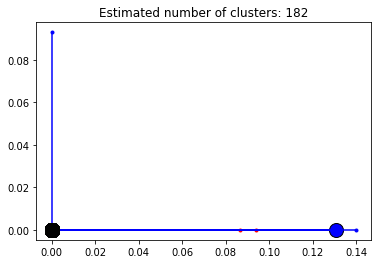

In [34]:
visualize_clustering_result(tdidf_ap_clustering_stopwords, tfidf_corpus_stopwords)

In [35]:
clusters = print_and_get_clusters(tdidf_ap_clustering_stopwords, corpus_stopwords)

Top terms per cluster:
Cluster 0:
('preference', 'pairwise', 'mallow', 'aggregation', 'label', 'supervised', 'result', 'way', 'query', 'particular')


Cluster 1:
('selective', 'setting', 'stream', 'label', 'active', 'pool', 'classifier', 'based', 'rejection', 'element')


Cluster 2:
('metric', 'distance', 'ground', 'framework', 'eigenvalue', 'linear', 'semidefinite', 'move', 'one', 'case')


Cluster 3:
('lasso', 'sparsity', 'regularization', 'group', 'scheme', 'norm', 'tv', 'analysis', 'feature', 'poisson')


Cluster 4:
('selection', 'criterion', 'consistency', 'asymptotic', 'information', 'dimension', 'vector', 'feature', 'support', 'framework')


Cluster 5:
('factor', 'dantzig', 'selector', 'signal', 'proposed', 'log', 'number', 'solution', 'vector', 'sparse')


Cluster 6:
('classifier', 'cost', 'family', 'result', 'taxonomy', 'learnability', 'bayesian', 'query', 'decision', 'convex')


Cluster 7:
('task', 'transfer', 'framework', 'hope', 'text', 'reinforcement', 'skill', 'learn', 'a

('reward', 'strategy', 'bandit', 'profile', 'optimal', 'allocation', 'stochastic', 'arm', 'task', 'pbrl')


Cluster 78:
('boltzmann', 'restricted', 'conditional', 'deep', 'discrete', 'rbm', 'universal', 'shallow', 'generative', 'rbms')


Cluster 79:
('step', 'langevin', 'size', 'sgld', 'gradient', 'stochastic', 'mala', 'performance', 'bias', 'new')


Cluster 80:
('learner', 'teaching', 'dimension', 'class', 'training', 'classifier', 'core', 'linear', 'infinite', 'pbtd')


Cluster 81:
('layer', 'multilayer', 'bottleneck', 'hidden', 'neural', 'tensor', 'topology', 'community', 'activation', 'deep')


Cluster 82:
('graphical', 'gaussian', 'node', 'high', 'dimensional', 'estimation', 'variable', 'structure', 'edge', 'conditional')


Cluster 83:
('domain', 'discrepancy', 'adaptation', 'source', 'target', 'sampled', 'feature', 'sdas', 'transfer', 'mslda')


Cluster 84:
('patient', 'image', 'disease', 'risk', 'clinical', 'mri', 'large', 'state', 'stratification', 'marker')


Cluster 85:
('dec

('coherence', 'ica', 'sparse', 'hinge', 'coding', 'overcomplete', 'linear', 'double', 'dictionary', 'group')


Cluster 152:
('convergence', 'stochastic', 'sgd', 'gradient', 'rate', 'objective', 'descent', 'convex', 'online', 'sparse')


Cluster 153:
('input', 'reservoir', 'system', 'state', 'memory', 'space', 'oger', 'fading', 'feature', 'filter')


Cluster 154:
('image', 'convolutional', 'invariance', 'representation', 'information', 'patch', 'geometric', 'picture', 'principle', 'unifying')


Cluster 155:
('constraint', 'convex', 'non', 'regret', 'online', 'pesc', 'process', 'violation', 'node', 'long')


Cluster 156:
('factor', 'outcome', 'principal', 'marginal', 'analysis', 'curve', 'latent', 'correlated', 'source', 'likelihood')


Cluster 157:
('bayesian', 'approximation', 'inference', 'ep', 'framework', 'correction', 'gaussian', 'expectation', 'local', 'estimator')


Cluster 158:
('interaction', 'high', 'backtracking', 'variable', 'modelling', 'dimensional', 'qda', 'analysis', 'li

# Metrics

In [36]:
def calc_scores(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus.toarray(), model.labels_), metrics.davies_bouldin_score(corpus.toarray(), model.labels_)

scores = []

score = list(calc_scores(tfidf_corpus, tdidf_ap_clustering))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, tdidf_ap_clustering_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                    model type  silhouette_score  calinski_harabasz_score  \
0                 normal model          0.030495                 2.134269   
1  model with custom stopwords          0.031771                 2.076528   

   davies_bouldin_score  
0              2.853512  
1              2.861016  
